# **Eleições 2024**

## **Extração do texto**

In [ ]:
!rm -rf /content/*


In [ ]:
pip install PyDrive PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.7 MB/s eta 0:00:00


In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
import PyPDF2
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Configuração da autenticação com Google Drive
gauth = GoogleAuth()
gauth.LoadClientConfigFile("client_secret.json")  # Carregar o arquivo de configuração

# Tentar carregar as credenciais salvas, se disponíveis
gauth.LoadCredentialsFile("mycreds.json")
if gauth.credentials is None:
    # Autenticação inicial
    gauth.CommandLineAuth()
    gauth.SaveCredentialsFile("mycreds.json")
elif gauth.access_token_expired:
    # Autenticação manual se o token expirar
    print("Token expirado. Refaça a autenticação manual.")
    gauth.CommandLineAuth()
    gauth.SaveCredentialsFile("mycreds.json")
else:
    gauth.Authorize()

drive = GoogleDrive(gauth)

# ID da pasta no Google Drive contendo os estados
folder_id = '1Mw23riegnDGJ0_KomRfYTBbuZKkXUjlJ'
folder_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false and mimeType='application/vnd.google-apps.folder'"}).GetList()

# DataFrame para armazenar o conteúdo por estado
df = pd.DataFrame(columns=['estado', 'texto'])

# Função para extrair texto de um único PDF
def extrair_texto_pdf(file):
    texto = ""
    try:
        # Baixar o PDF temporariamente na memória
        file.GetContentFile("temp.pdf", acknowledge_abuse=True)
        with open("temp.pdf", "rb") as pdf_file:
            pdf_reader = PyPDF2.PdfReader(pdf_file)
            for page in pdf_reader.pages:
                texto += page.extract_text() + "\n"
    except Exception as e:
        print(f"Erro ao processar PDF {file['title']}: {e}")
    return texto

# Processar cada pasta de estado e extrair textos
for folder in folder_list:
    estado = folder['title']
    print(f"\nProcessando estado: {estado}")

    # Listar os arquivos PDF dentro da pasta de estado
    file_list = drive.ListFile({'q': f"'{folder['id']}' in parents and trashed=false and mimeType='application/pdf'"}).GetList()
    estado_texto = ""
    arquivos_processados = 0  # Contador de progresso

    for file in file_list:
        estado_texto += extrair_texto_pdf(file)
        arquivos_processados += 1
        # Exibir progresso para cada PDF processado
        print(f"{arquivos_processados}/{len(file_list)} PDFs processados para o estado {estado}")

    # Adiciona o texto consolidado ao DataFrame usando pd.concat()
    df = pd.concat([df, pd.DataFrame({'estado': [estado], 'texto': [estado_texto]})], ignore_index=True)

# Aplicar TF-IDF nos textos por estado
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['texto'])

# DataFrame com os termos TF-IDF para visualização
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=df['estado'], columns=vectorizer.get_feature_names_out())
print(tfidf_df.head())

# Salvar o DataFrame consolidado em um arquivo CSV
df.to_csv('textos_por_estado.csv', index=False, encoding='utf-8')

## **Tratamento**

In [ ]:
pip install spellchecker pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.5 MB/s eta 0:00:00


In [ ]:
from concurrent.futures import ProcessPoolExecutor
import pandas as pd
from spellchecker import SpellChecker

# Inicializar o corretor
spell = SpellChecker(language='pt')

def corrigir_texto(texto):
    palavras = texto.split()
    return ' '.join([spell.correction(palavra) for palavra in palavras])

# Dividir o DataFrame em partes menores
def processar_parte(df_parte):
    df_parte['texto_corrigido'] = df_parte['texto'].apply(corrigir_texto)
    return df_parte

# Carregar dados
df = pd.read_csv("textos_por_estado.csv")

# Dividir o DataFrame em partes
partes = [df.iloc[i:i + 1000] for i in range(0, len(df), 1000)]  # Dividir em blocos de 1000 linhas

# Usar ProcessPoolExecutor para paralelizar
with ProcessPoolExecutor() as executor:
    resultados = list(executor.map(processar_parte, partes))

# Concatenar os resultados e salvar
df_corrigido = pd.concat(resultados, ignore_index=True)
df_corrigido.to_csv("resultado_corrigido_final.csv", index=False)

Process ForkProcess-2:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 103, in get
    res = self._recv_bytes()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
def corrigir_encoding(texto):
    try:
        return texto.encode('latin1').decode('utf-8')
    except Exception as e:
        print(f"Erro ao corrigir encoding: {e}")
        return texto  # Retorna o texto original se der erro

# Aplicar a correção no texto
df['texto_corrigido'] = df['texto'].apply(corrigir_encoding)

In [ ]:
# Visualizar algumas linhas para verificar possíveis problemas
print(df.head())

  estado                                              texto  \
0     RJ  plano governo andinho brito prefeito ton porto...   
1     TO  comocoraÃ§Ã£o cheio deesperanÃ§a eacerteza deq...   
2     SP  psd mdb psdb coligaÃ§Ã£o unidos Ã¡guas plano g...   
3     SE  pÃ¡gina leiame arquivo zip contÃ©m arquivos pd...   
4     SC  plano governo coligaÃ§Ã£o pp mdb indice introd...   

                                      texto_filtrado  \
0  prevenÃ§Ã£o prevenÃ§Ã£o prevenÃ§Ã£o prevenÃ§Ã£...   
1  prevenÃ§Ã£o prevenÃ§Ã£o rios prevenÃ§Ã£o preve...   
2  prevenÃ§Ã£o prevenÃ§Ã£o rios prevenÃ§Ã£o preve...   
3  prevenÃ§Ã£o prevenÃ§Ã£o rios rios prevenÃ§Ã£o ...   
4  prevenÃ§Ã£o prevenÃ§Ã£o prevenÃ§Ã£o prevenÃ§Ã£...   

                                     texto_corrigido  
0  plano governo andinho brito prefeito ton porto...  
1  comocoração cheio deesperança eacerteza dequej...  
2  psd mdb psdb coligação unidos águas plano gove...  
3  página leiame arquivo zip contém arquivos pdf ...  
4  plano 

## **Filtragem**

In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Carregar o novo arquivo corrigido
df = pd.read_csv("texto_corrigido_utf8.csv")

# Preencher valores nulos no texto corrigido
df['texto_corrigido'] = df['texto_corrigido'].fillna('')

# Lista de palavras relacionadas a enchentes (sem caracteres especiais)
palavras_enchentes = [
    "enchente", "inundacao", "alagamento", "chuva", "tempestade"
]

# Filtrar apenas as palavras de interesse nos textos do DataFrame
def filtrar_palavras_interesse(texto, palavras_chave):
    # Compilar o regex com as palavras-chave, incluindo frases compostas
    palavras_regex = r'\b(?:' + '|'.join(map(re.escape, palavras_chave)) + r')\b'
    # Extrair apenas as palavras que correspondem às palavras-chave
    return ' '.join(re.findall(palavras_regex, str(texto), flags=re.IGNORECASE))

# Aplicar a filtragem no texto corrigido de cada estado
df['texto_filtrado_corrigido'] = df['texto_corrigido'].apply(
    lambda x: filtrar_palavras_interesse(x, palavras_enchentes)
)

# Configurar o CountVectorizer para bigramas (n-grams até o tamanho 2) e usar palavras compostas
vectorizer = CountVectorizer(ngram_range=(1, 2), vocabulary=palavras_enchentes)
contagem_matrix = vectorizer.fit_transform(df['texto_filtrado_corrigido'])

# DataFrame com as contagens de termos específicos para enchentes
contagem_df = pd.DataFrame(contagem_matrix.toarray(), index=df['estado'], columns=vectorizer.get_feature_names_out())

# Garantir que todos os estados apareçam, mesmo que zerados
contagem_df = contagem_df.reindex(df['estado'], fill_value=0)

# Exibir a frequência de termos relacionados a enchentes
print("Frequência de termos sobre enchentes por estado:")
print(contagem_df)

# Salvar o DataFrame de contagens em um arquivo CSV
contagem_df.to_csv("frequencia_termos_enchentes_corrigido.csv")

Frequência de termos sobre enchentes por estado:
        enchente  inundacao  alagamento  chuva  tempestade
estado                                                    
RJ             6         21          25    111           0
TO             1          1           6     25           0
SP            17         52          81    413           6
SE             1          6          13     26           0
SC            18          9          35    115           2
RS           168         31          45    140           0
RR             0          0           5      3           0
RO             0          0           1     13           0
RN             0          3          20     45           0
PR             6          5          34    142           0
PI             0          1           9     38           0
PE             7          5          20     56           0
PB             0          6          13     47           0
PA             1          7          15     33           0
MT     

In [ ]:
# Contagem de PDFs por estado
pdfs_por_estado = df.groupby('estado')['texto_corrigido'].count()

# Função para contar a frequência dos termos de enchentes em um texto consolidado de um estado
def contar_termos_enchentes(texto, palavras_chave):
    palavras_regex = r'\b(?:' + '|'.join(map(re.escape, palavras_chave)) + r')\b'
    return len(re.findall(palavras_regex, texto, flags=re.IGNORECASE))

# Dicionário para armazenar o total de ocorrências dos termos de enchentes por estado
ocorrencias_termos = {}

for estado in df['estado'].unique():
    # Consolida todos os textos corrigidos de um estado
    estado_texto_consolidado = ' '.join(df[df['estado'] == estado]['texto_corrigido'])
    # Conta as ocorrências dos termos de enchentes no texto consolidado
    total_ocorrencias = contar_termos_enchentes(estado_texto_consolidado, palavras_enchentes)
    ocorrencias_termos[estado] = total_ocorrencias

# Criar um DataFrame com as ocorrências e calcular a proporção
ocorrencias_df = pd.DataFrame.from_dict(ocorrencias_termos, orient='index', columns=['total_ocorrencias'])
ocorrencias_df['pdfs_totais'] = pdfs_por_estado
ocorrencias_df['proporcao_termos_por_pdf'] = ocorrencias_df['total_ocorrencias'] / ocorrencias_df['pdfs_totais']

# Exibir o DataFrame final com a proporção de termos por PDF
print("Proporção de termos de enchentes por PDF em cada estado:")
print(ocorrencias_df[['total_ocorrencias', 'pdfs_totais', 'proporcao_termos_por_pdf']])

# Salvar os resultados em um arquivo CSV
ocorrencias_df.to_csv("proporcao_termos_por_estado.csv")

Proporção de termos de enchentes por PDF em cada estado:
    total_ocorrencias  pdfs_totais  proporcao_termos_por_pdf
RJ                163            1                     163.0
TO                 33            1                      33.0
SP                569            1                     569.0
SE                 46            1                      46.0
SC                179            1                     179.0
RS                384            1                     384.0
RR                  8            1                       8.0
RO                 14            1                      14.0
RN                 68            1                      68.0
PR                187            1                     187.0
PI                 48            1                      48.0
PE                 88            1                      88.0
PB                 66            1                      66.0
PA                 56            1                      56.0
MT                 56       

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

# Configuração da autenticação com Google Drive
gauth = GoogleAuth()
gauth.LoadClientConfigFile("client_secret.json")

# Carregar credenciais salvas, se disponíveis
try:
    gauth.LoadCredentialsFile("mycreds.json")
    if gauth.credentials is None:
        gauth.CommandLineAuth()
        gauth.SaveCredentialsFile("mycreds.json")
    elif gauth.access_token_expired:
        gauth.Refresh()
    else:
        gauth.Authorize()
except Exception as e:
    print("Erro durante a autenticação:", e)

drive = GoogleDrive(gauth)

# ID da pasta principal contendo as pastas dos estados
folder_id = '1Mw23riegnDGJ0_KomRfYTBbuZKkXUjlJ'

try:
    folder_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false and mimeType='application/vnd.google-apps.folder'"}).GetList()
except Exception as e:
    print("Erro ao listar as pastas no Google Drive:", e)
    folder_list = []

# Dicionário para armazenar o número de PDFs por estado
pdf_counts = {}

# Contar PDFs em cada pasta de estado
for folder in folder_list:
    try:
        estado = folder['title']
        file_list = drive.ListFile({'q': f"'{folder['id']}' in parents and trashed=false and mimeType='application/pdf'"}).GetList()
        pdf_counts[estado] = len(file_list)  # Conta de PDFs
        print(f"{estado}: {pdf_counts[estado]} PDFs encontrados.")
    except Exception as e:
        print(f"Erro ao processar a pasta '{folder['title']}':", e)

# Exibir a contagem de PDFs por estado
print("\nNúmero de PDFs por estado:")
for estado, count in pdf_counts.items():
    print(f"{estado}: {count}")

# Salvar a contagem em um arquivo CSV para referência futura
import pandas as pd
pdf_counts_df = pd.DataFrame.from_dict(pdf_counts, orient='index', columns=['pdf_count'])
pdf_counts_df.to_csv("pdf_counts_por_estado.csv")
print("\nAs contagens foram salvas no arquivo 'pdf_counts_por_estado.csv'.")

/usr/local/lib/python3.10/dist-packages/oauth2client/_helpers.py:255: UserWarning: Cannot access mycreds.json: No such file or directory
  warnings.warn(_MISSING_FILE_MESSAGE.format(filename))


Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=266329160318-hibsphie1clhka7g0apr71fs14fbdeef.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=online&response_type=code

Enter verification code: 4/1AeanS0boMghExj1GO1StvMqMeFoOiJO4_h2xvVU1S5FSZ419ULEY4sJ-FxI
Authentication successful.
RJ: 384 PDFs encontrados.
TO: 330 PDFs encontrados.
SP: 2112 PDFs encontrados.
SE: 222 PDFs encontrados.
SC: 839 PDFs encontrados.
RS: 1214 PDFs encontrados.
RR: 47 PDFs encontrados.
RO: 170 PDFs encontrados.
RN: 391 PDFs encontrados.
PR: 1153 PDFs encontrados.
PI: 503 PDFs encontrados.
PE: 513 PDFs encontrados.
PB: 527 PDFs encontrados.
PA: 483 PDFs encontrados.
MT: 362 PDFs encontrados.
MS: 248 PDFs encontrados.
MG: 2364 PDFs encontrados.
MA: 656 PDFs encontrados.
GO: 655 PDFs encontrados.
ES: 288 PDFs encontrados.
CE: 512 PDFs encontrados.
BA: 1169 PDFs encontra

In [ ]:
import pandas as pd

# Criar DataFrame de ocorrências de termos, se ainda não existir
ocorrencias_df = pd.DataFrame.from_dict(ocorrencias_termos, orient='index', columns=['total_ocorrencias'])
ocorrencias_df.reset_index(inplace=True)
ocorrencias_df.rename(columns={'index': 'estado'}, inplace=True)

# Criar DataFrame com a contagem de PDFs por estado a partir do dicionário
pdf_counts_df = pd.DataFrame.from_dict(pdf_counts, orient='index', columns=['pdfs_totais'])
pdf_counts_df.reset_index(inplace=True)
pdf_counts_df.rename(columns={'index': 'estado'}, inplace=True)

# Combinar as informações automaticamente
ocorrencias_df = ocorrencias_df.merge(pdf_counts_df, on='estado', how='inner')

# Calcular a proporção de termos por PDF
ocorrencias_df['proporcao_termos_por_pdf'] = ocorrencias_df['total_ocorrencias'] / ocorrencias_df['pdfs_totais']

# Exibir o DataFrame final com a proporção de termos de enchentes por PDF
print("DataFrame final com a proporção de termos de enchentes por PDF em cada estado:")
print(ocorrencias_df)

# Salvar o DataFrame final em um arquivo CSV para análise futura
ocorrencias_df.to_csv('proporcao_termos_enchentes_por_estado.csv', index=False)
print("Arquivo salvo como 'proporcao_termos_enchentes_por_estado.csv'.")

DataFrame final com a proporção de termos de enchentes por PDF em cada estado:
   estado  total_ocorrencias  pdfs_totais  proporcao_termos_por_pdf
0      RJ                163          384                  0.424479
1      TO                 33          330                  0.100000
2      SP                569         2112                  0.269413
3      SE                 46          222                  0.207207
4      SC                179          839                  0.213349
5      RS                384         1214                  0.316310
6      RR                  8           47                  0.170213
7      RO                 14          170                  0.082353
8      RN                 68          391                  0.173913
9      PR                187         1153                  0.162186
10     PI                 48          503                  0.095427
11     PE                 88          513                  0.171540
12     PB                 66         

## **Visualização**

<ipython-input-15-1ca57640931a>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='estado', y='total_ocorrencias', data=ocorrencias_df, palette=colors)


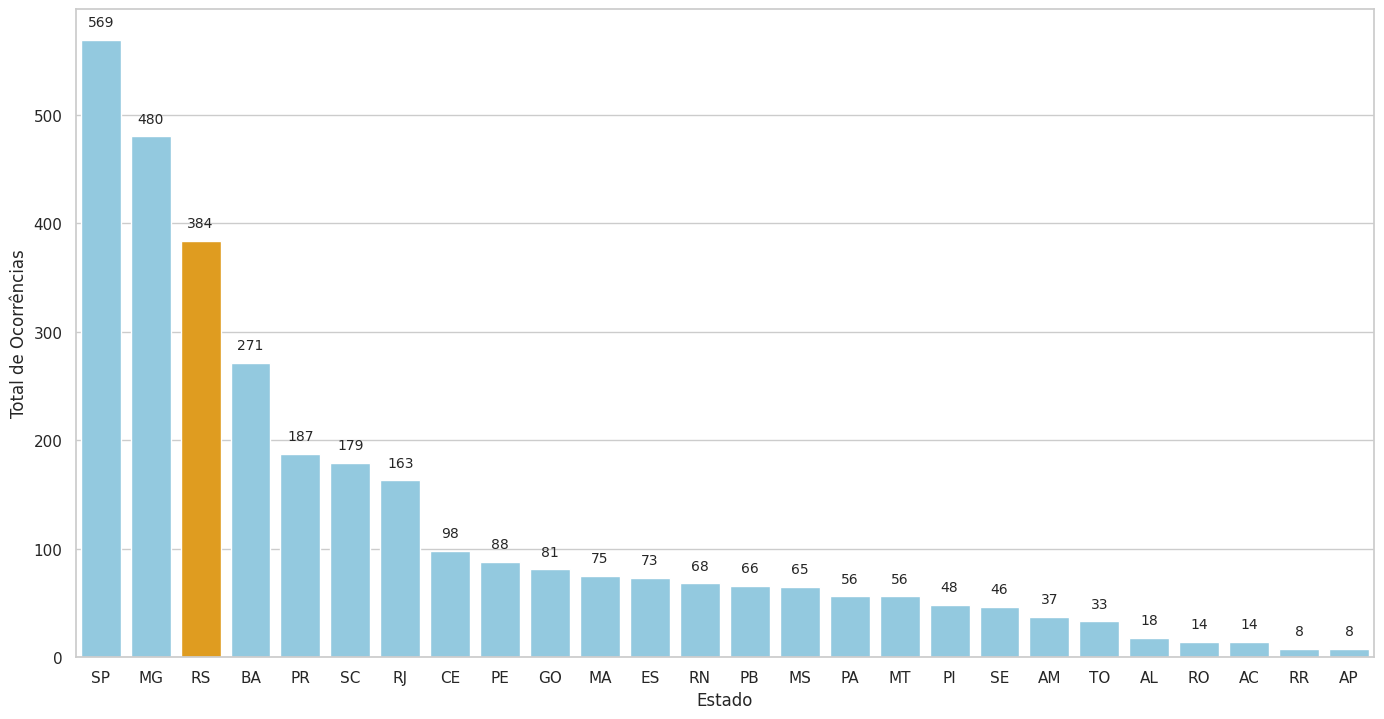

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dados fornecidos
data = {
    'estado': ['RJ', 'TO', 'SP', 'SE', 'SC', 'RS', 'RR', 'RO', 'RN', 'PR', 'PI', 'PE', 'PB', 'PA',
               'MT', 'MS', 'MG', 'MA', 'GO', 'ES', 'CE', 'BA', 'AP', 'AM', 'AL', 'AC'],
    'total_ocorrencias': [163, 33, 569, 46, 179, 384, 8, 14, 68, 187, 48, 88, 66, 56,
                          56, 65, 480, 75, 81, 73, 98, 271, 8, 37, 18, 14]
}

# Criar DataFrame
ocorrencias_df = pd.DataFrame(data)

# Ordenar o DataFrame em ordem decrescente de total_ocorrencias
ocorrencias_df = ocorrencias_df.sort_values(by='total_ocorrencias', ascending=False)

# Configuração de estilo com seaborn
sns.set(style="whitegrid")

# Configurar cores, destacando o RS em uma cor diferente
colors = ['orange' if estado == 'RS' else 'skyblue' for estado in ocorrencias_df['estado']]

# Configurar figura e eixos
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='estado', y='total_ocorrencias', data=ocorrencias_df, palette=colors)

# Adicionar rótulos nas barras
for index, value in enumerate(ocorrencias_df['total_ocorrencias']):
    ax.text(index, value + 10, str(value), ha='center', va='bottom', fontsize=10)

# Título e subtítulo
#plt.title('Total de Ocorrências de Termos Relacionados a Enchentes por Estado', fontsize=14, weight='bold')
#plt.suptitle('Eleições Municipais de 2024', y=0.85, fontsize=10)
plt.xlabel('Estado')
plt.ylabel('Total de Ocorrências')

# Nota de rodapé
#plt.figtext(0.5, 0.01, 'Nota: As enchentes de 2024 no Rio Grande do Sul foram consideradas a maior catástrofe climática da história do estado.', ha='center', fontsize=8)

# Ajuste do layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Reduz espaço em branco

# Exibir gráfico
plt.show()

<ipython-input-16-4774911738c1>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='estado', y='proporcao_termos_por_pdf', data=proporcao_df, palette=colors)


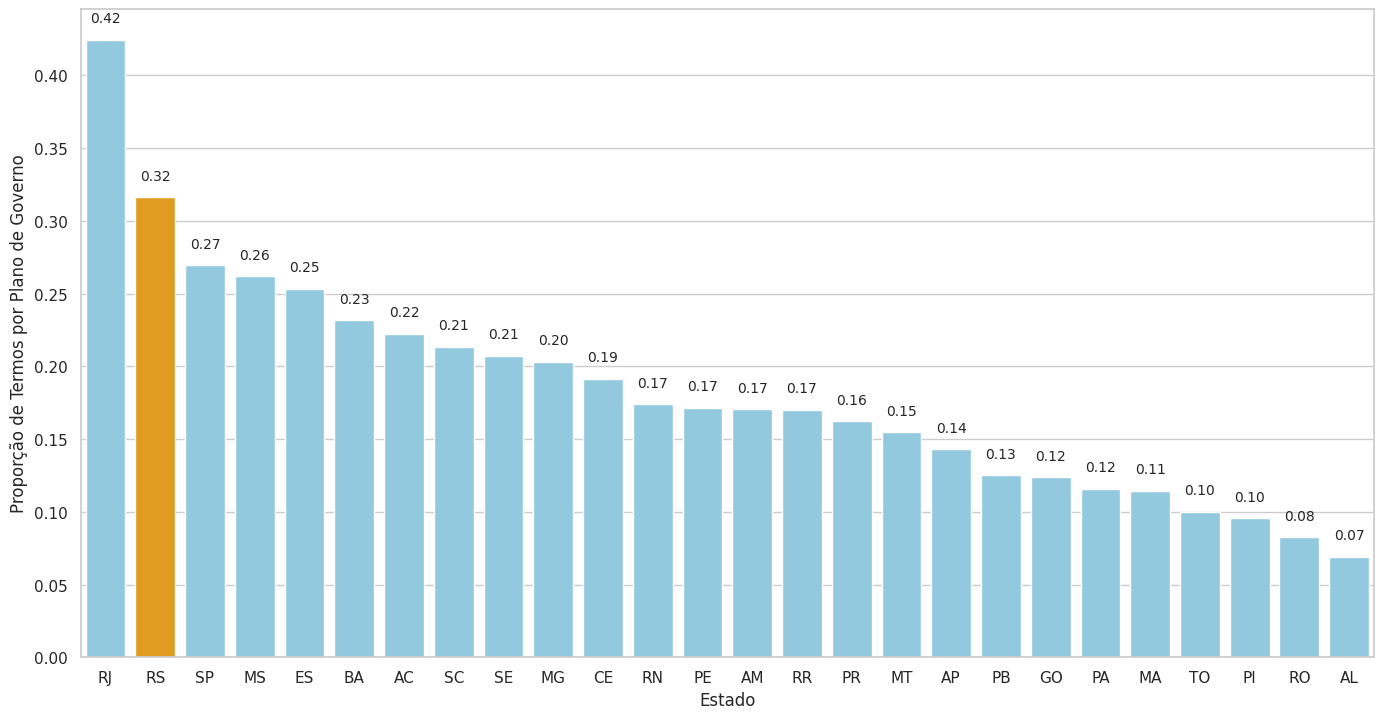

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dados fornecidos
data = {
    'estado': ['RJ', 'TO', 'SP', 'SE', 'SC', 'RS', 'RR', 'RO', 'RN', 'PR', 'PI', 'PE', 'PB', 'PA',
               'MT', 'MS', 'MG', 'MA', 'GO', 'ES', 'CE', 'BA', 'AP', 'AM', 'AL', 'AC'],
    'proporcao_termos_por_pdf': [0.424479, 0.1, 0.269413, 0.207207, 0.213349, 0.31631, 0.170213,
                                 0.082353, 0.173913, 0.162186, 0.095427, 0.17154, 0.125237,
                                 0.115942, 0.154696, 0.262097, 0.203046, 0.114329, 0.123664,
                                 0.253472, 0.191406, 0.231822, 0.142857, 0.170507, 0.068966,
                                 0.222222]
}

# Criar DataFrame
proporcao_df = pd.DataFrame(data)

# Ordenar o DataFrame em ordem decrescente de proporcao_termos_por_pdf
proporcao_df = proporcao_df.sort_values(by='proporcao_termos_por_pdf', ascending=False)

# Configuração de estilo com seaborn
sns.set(style="whitegrid")

# Configurar cores, destacando o RS em uma cor diferente
colors = ['orange' if estado == 'RS' else 'skyblue' for estado in proporcao_df['estado']]

# Configurar figura e eixos
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='estado', y='proporcao_termos_por_pdf', data=proporcao_df, palette=colors)

# Adicionar rótulos nas barras (mais próximos)
for index, value in enumerate(proporcao_df['proporcao_termos_por_pdf']):
    ax.text(index, value + 0.01, f'{value:.2f}', ha='center', va='bottom', fontsize=10)  # Ajuste de deslocamento

# Título e subtítulo
#plt.title('Proporção de Termos Relacionados a Enchentes por Plano de Governo em Cada Estado', fontsize=14, weight='bold')
#plt.suptitle('Eleições Municipais de 2024', y=0.95, fontsize=10)
plt.xlabel('Estado')
plt.ylabel('Proporção de Termos por Plano de Governo')

# Nota de rodapé
#plt.figtext(0.5, 0.01, 'Nota: As enchentes de 2024 no Rio Grande do Sul foram consideradas a maior catástrofe climática da história do estado.', ha='center', fontsize=8)

# Ajuste do layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Reduz espaço em branco

# Exibir gráfico
plt.show()

<ipython-input-17-36f3e1cc8504>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='estado', y='proporcao_termos_por_pdf', data=ocorrencias_df, palette=colors)


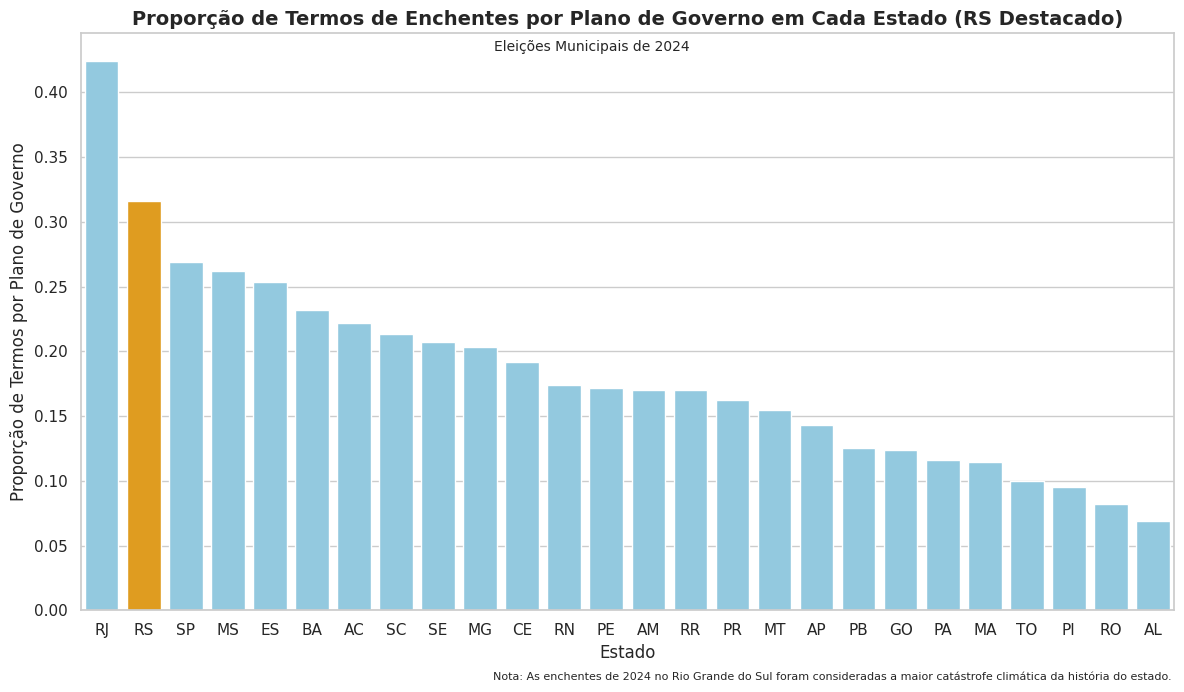

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo com seaborn
sns.set(style="whitegrid")

# Criar DataFrame com as informações combinadas de ocorrências e PDFs
# Supondo que `ocorrencias_termos` e `pdf_counts` já existam como dicionários com valores reais
ocorrencias_df = pd.DataFrame(list(ocorrencias_termos.items()), columns=['estado', 'total_ocorrencias'])
pdf_counts_df = pd.DataFrame(list(pdf_counts.items()), columns=['estado', 'pdfs_totais'])

# Combinar as informações automaticamente usando 'estado' como chave
ocorrencias_df = ocorrencias_df.merge(pdf_counts_df, on='estado')

# Calcular a proporção de termos por PDF
ocorrencias_df['proporcao_termos_por_pdf'] = ocorrencias_df['total_ocorrencias'] / ocorrencias_df['pdfs_totais']

# Ordenar o DataFrame em ordem decrescente de proporção
ocorrencias_df = ocorrencias_df.sort_values(by='proporcao_termos_por_pdf', ascending=False)

# Configurar cores, destacando o RS em uma cor diferente
colors = ['orange' if estado == 'RS' else 'skyblue' for estado in ocorrencias_df['estado']]

# Configurar figura e eixos
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='estado', y='proporcao_termos_por_pdf', data=ocorrencias_df, palette=colors)

# Título e subtítulo
plt.title('Proporção de Termos de Enchentes por Plano de Governo em Cada Estado (RS Destacado)', fontsize=14, weight='bold')
plt.suptitle('Eleições Municipais de 2024', y=0.85, fontsize=10)
plt.xlabel('Estado')
plt.ylabel('Proporção de Termos por Plano de Governo')

# Nota de rodapé posicionada mais próxima ao gráfico
plt.figtext(0.7, 0.05, 'Nota: As enchentes de 2024 no Rio Grande do Sul foram consideradas a maior catástrofe climática da história do estado.', ha='center', fontsize=8)

# Ajuste do layout
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Reduz espaço em branco

# Exibir gráfico
plt.show()

In [ ]:
from collections import Counter
import re

# Juntar todos os textos corrigidos
todos_textos = ' '.join(df['texto_corrigido'].astype(str))

# Tokenizar os textos em palavras
palavras = re.findall(r'\b\w+\b', todos_textos.lower())

# Contar as palavras mais frequentes
contagem_palavras = Counter(palavras)

# Exibir as 50 palavras mais frequentes
mais_frequentes = contagem_palavras.most_common(50)
print("Palavras mais frequentes nos textos corrigidos:")
print(mais_frequentes)

Palavras mais frequentes nos textos corrigidos:
[('saude', 287202), ('municipal', 271633), ('municipio', 255945), ('educacao', 189332), ('programa', 182232), ('cidade', 169329), ('social', 165151), ('desenvolvimento', 156830), ('acoes', 156241), ('atendimento', 146821), ('s', 146169), ('governo', 142625), ('plano', 142244), ('populacao', 139765), ('promover', 133293), ('servicos', 132324), ('gestao', 131724), ('criar', 129953), ('programas', 118344), ('ampliar', 116935), ('criacao', 115799), ('qualidade', 115636), ('garantir', 113298), ('r', 107519), ('publica', 105942), ('construcao', 105635), ('i', 104636), ('todos', 102040), ('seguranca', 100006), ('apoio', 95780), ('acesso', 94369), ('meio', 94333), ('areas', 93844), ('d', 91805), ('cultura', 90339), ('escolas', 87511), ('recursos', 86102), ('publicos', 86094), ('implantar', 84281), ('atraves', 82767), ('c', 81801), ('projetos', 81355), ('politicas', 81271), ('assistencia', 81158), ('parcerias', 80829), ('atividades', 79717), ('pes

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re

# Calcular a participação de cada termo nas ocorrências de enchentes por estado
participacao_df = contagem_df.div(contagem_df.sum(axis=1), axis=0) * 100
participacao_df = participacao_df.fillna(0)

# Exibir os resultados
print("Participação percentual de cada termo nas ocorrências de enchentes por estado:")
print(participacao_df)

# Salvar o resultado como CSV
participacao_df.to_csv("participacao_termos_enchentes_por_estado.csv")

Participação percentual de cada termo nas ocorrências de enchentes por estado:
         enchente  inundacao  alagamento      chuva  tempestade
estado                                                         
RJ       3.680982  12.883436   15.337423  68.098160    0.000000
TO       3.030303   3.030303   18.181818  75.757576    0.000000
SP       2.987698   9.138840   14.235501  72.583480    1.054482
SE       2.173913  13.043478   28.260870  56.521739    0.000000
SC      10.055866   5.027933   19.553073  64.245810    1.117318
RS      43.750000   8.072917   11.718750  36.458333    0.000000
RR       0.000000   0.000000   62.500000  37.500000    0.000000
RO       0.000000   0.000000    7.142857  92.857143    0.000000
RN       0.000000   4.411765   29.411765  66.176471    0.000000
PR       3.208556   2.673797   18.181818  75.935829    0.000000
PI       0.000000   2.083333   18.750000  79.166667    0.000000
PE       7.954545   5.681818   22.727273  63.636364    0.000000
PB       0.000000   9.090

<Figure size 1600x1000 with 0 Axes>

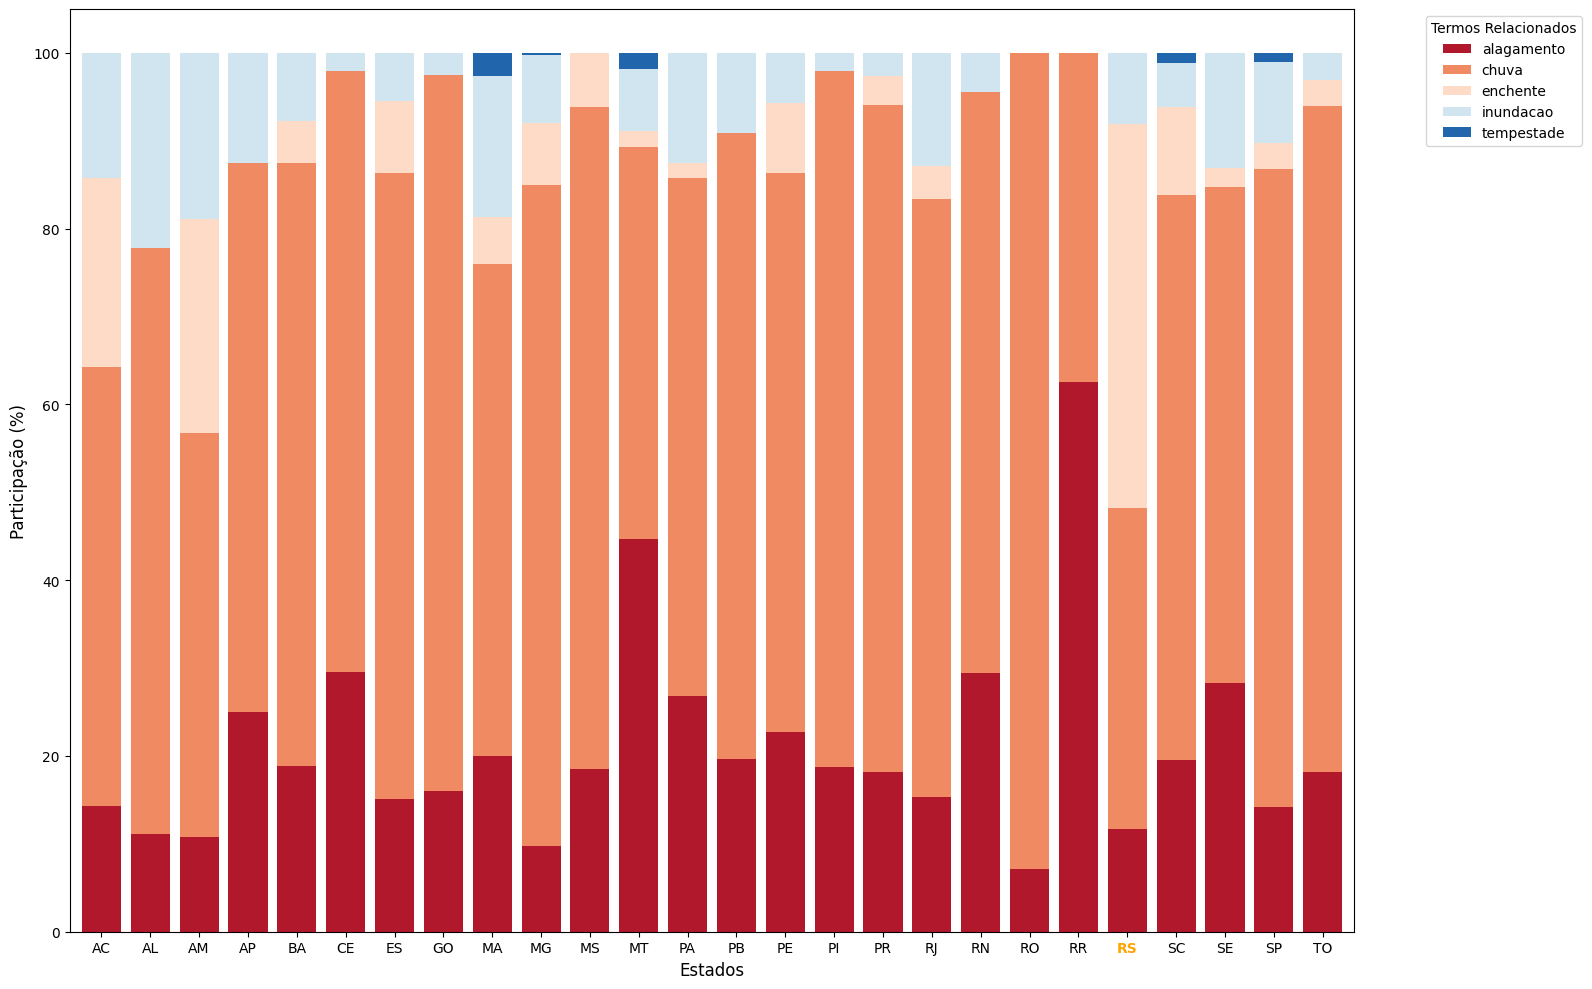

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Dados atualizados
data = {
    "estado": ["RJ", "TO", "SP", "SE", "SC", "RS", "RR", "RO", "RN", "PR", "PI", "PE", "PB", "PA", "MT",
               "MS", "MG", "MA", "GO", "ES", "CE", "BA", "AP", "AM", "AL", "AC"],
    "alagamento": [15.337423, 18.181818, 14.235501, 28.260870, 19.553073, 11.718750, 62.500000, 7.142857, 29.411765,
                   18.181818, 18.750000, 22.727273, 19.696970, 26.785714, 44.642857, 18.461538, 9.791667, 20.000000,
                   16.049383, 15.068493, 29.591837, 18.819188, 25.000000, 10.810811, 11.111111, 14.285714],
    "chuva": [68.098160, 75.757576, 72.583480, 56.521739, 64.245810, 36.458333, 37.500000, 92.857143, 66.176471,
              75.935829, 79.166667, 63.636364, 71.212121, 58.928571, 44.642857, 75.384615, 75.208333, 56.000000,
              81.481481, 71.232877, 68.367347, 68.634686, 62.500000, 45.945946, 66.666667, 50.000000],
    "enchente": [3.680982, 3.030303, 2.987698, 2.173913, 10.055866, 43.750000, 0.000000, 0.000000, 0.000000,
                 3.208556, 0.000000, 7.954545, 0.000000, 1.785714, 1.785714, 6.153846, 7.083333, 5.333333,
                 0.000000, 8.219178, 0.000000, 4.797048, 0.000000, 24.324324, 0.000000, 21.428571],
    "inundacao": [12.883436, 3.030303, 9.138840, 13.043478, 5.027933, 8.072917, 0.000000, 0.000000, 4.411765,
                  2.673797, 2.083333, 5.681818, 9.090909, 12.500000, 7.142857, 0.000000, 7.708333, 16.000000,
                  2.469136, 5.479452, 2.040816, 7.749077, 12.500000, 18.918919, 22.222222, 14.285714],
    "tempestade": [0.000000, 0.000000, 1.054482, 0.000000, 1.117318, 0.000000, 0.000000, 0.000000, 0.000000,
                   0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 1.785714, 0.000000, 0.208333, 2.666667,
                   0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]
}

# Converter para DataFrame
df = pd.DataFrame(data)

# Ordenar os estados em ordem alfabética
df = df.sort_values(by="estado")

# Configuração do gráfico
plt.figure(figsize=(16, 10))

# Criar gráfico de barras empilhadas
ax = df.set_index('estado').plot(kind='bar', stacked=True, figsize=(16, 10),
                                 color=['#b2182b', '#ef8a62', '#fddbc7', '#d1e5f0', '#2166ac'], width=0.8)

# Configurações do gráfico
plt.xlabel("Estados", fontsize=12)
plt.ylabel("Participação (%)", fontsize=12)

# Destaque do RS no eixo X
xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()
for label in xticklabels:
    if label.get_text() == "RS":
        label.set_color("orange")
        label.set_fontweight("bold")
        label.set_fontsize(12)

# Ajustar os rótulos do eixo X
plt.xticks(rotation=0, fontsize=10, ha='center')

# Legenda
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Termos Relacionados")
plt.tight_layout()

# Exibir o gráfico
plt.show()

<Figure size 1600x1000 with 0 Axes>

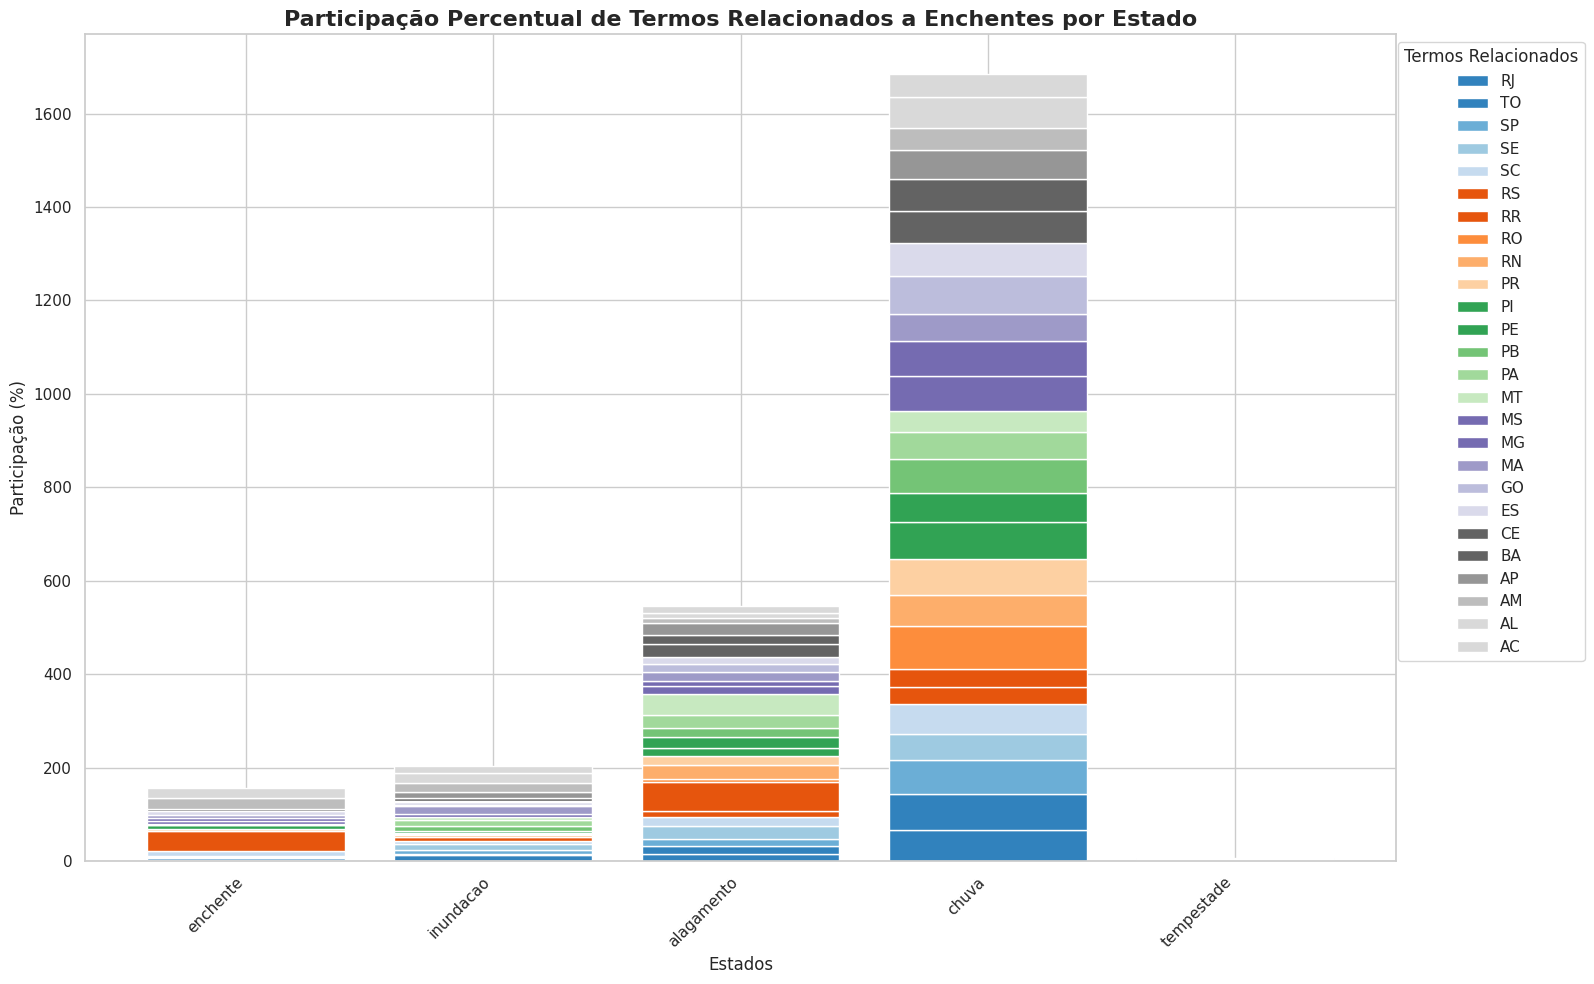

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o arquivo CSV
participacao_df = pd.read_csv("participacao_termos_enchentes_por_estado.csv", index_col=0)

# Configurar o gráfico
plt.figure(figsize=(16, 10))

# Criar o gráfico de barras empilhadas
participacao_df.T.plot(kind='bar', stacked=True, figsize=(16, 10), colormap='tab20c', width=0.8)

# Configurações do gráfico
plt.title("Participação Percentual de Termos Relacionados a Enchentes por Estado", fontsize=16, weight='bold')
plt.xlabel("Estados", fontsize=12)
plt.ylabel("Participação (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')

# Legenda
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), title="Termos Relacionados")
plt.tight_layout()

# Exibir o gráfico
plt.show()

<Figure size 1600x1000 with 0 Axes>

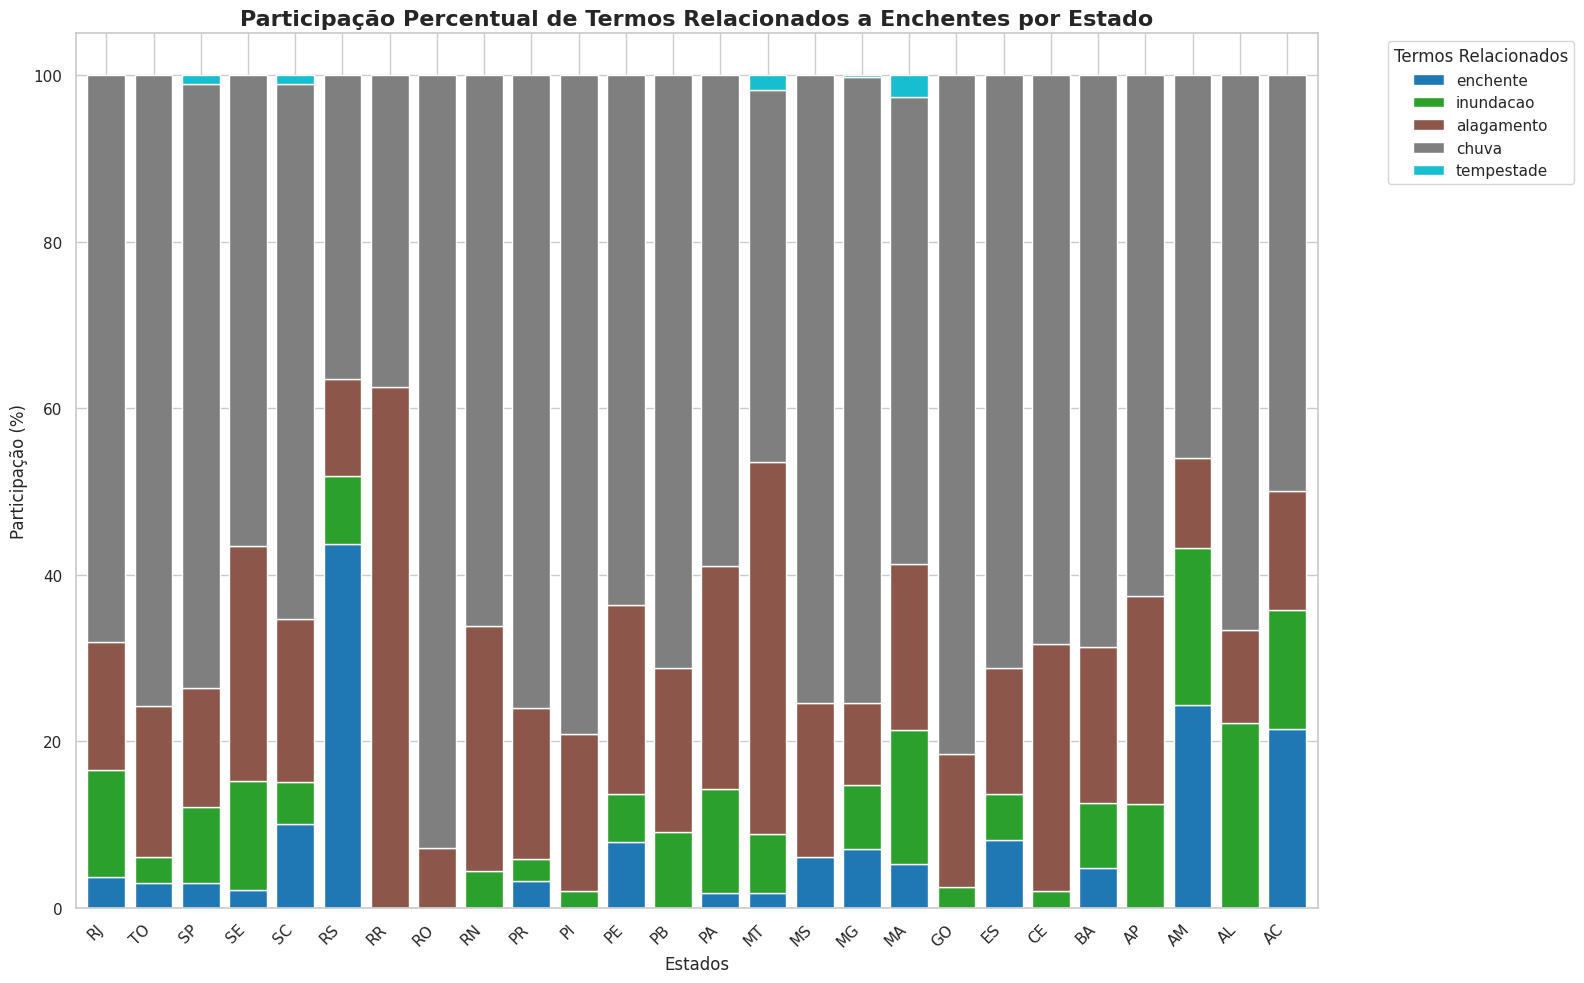

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o arquivo CSV
participacao_df = pd.read_csv("participacao_termos_enchentes_por_estado.csv", index_col=0)

# Configurar o gráfico
plt.figure(figsize=(16, 10))

# Criar o gráfico de barras empilhadas com um colormap mais contrastante
participacao_df.plot(kind='bar', stacked=True, figsize=(16, 10), colormap='tab10', width=0.8)

# Configurações do gráfico
plt.title("Participação Percentual de Termos Relacionados a Enchentes por Estado", fontsize=16, weight='bold')
plt.xlabel("Estados", fontsize=12)
plt.ylabel("Participação (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')

# Legenda
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Termos Relacionados")
plt.tight_layout()

# Exibir o gráfico
plt.show()

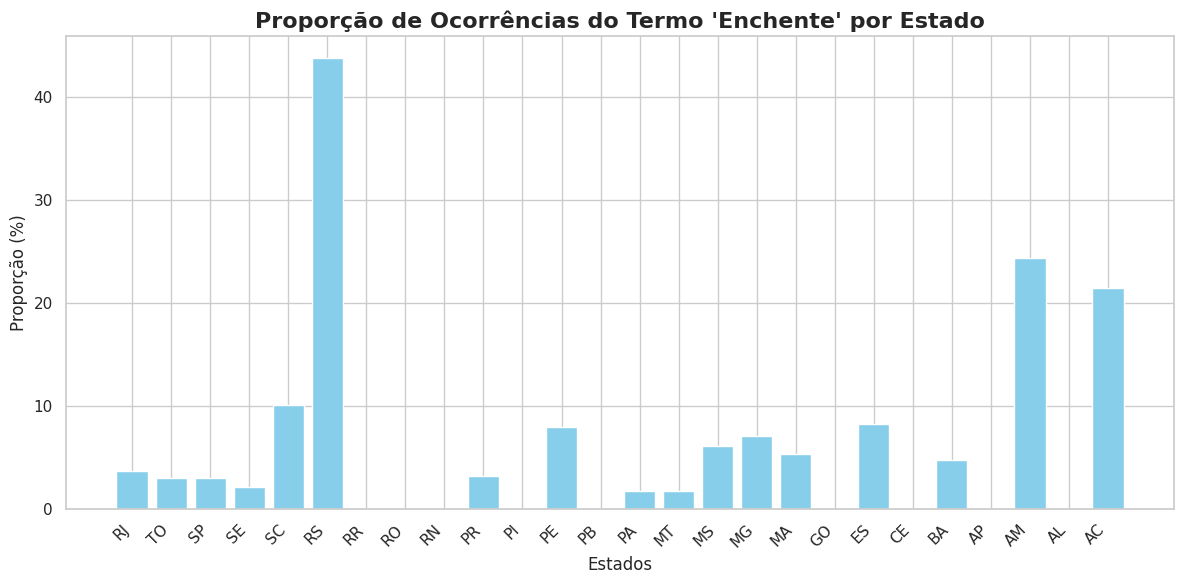

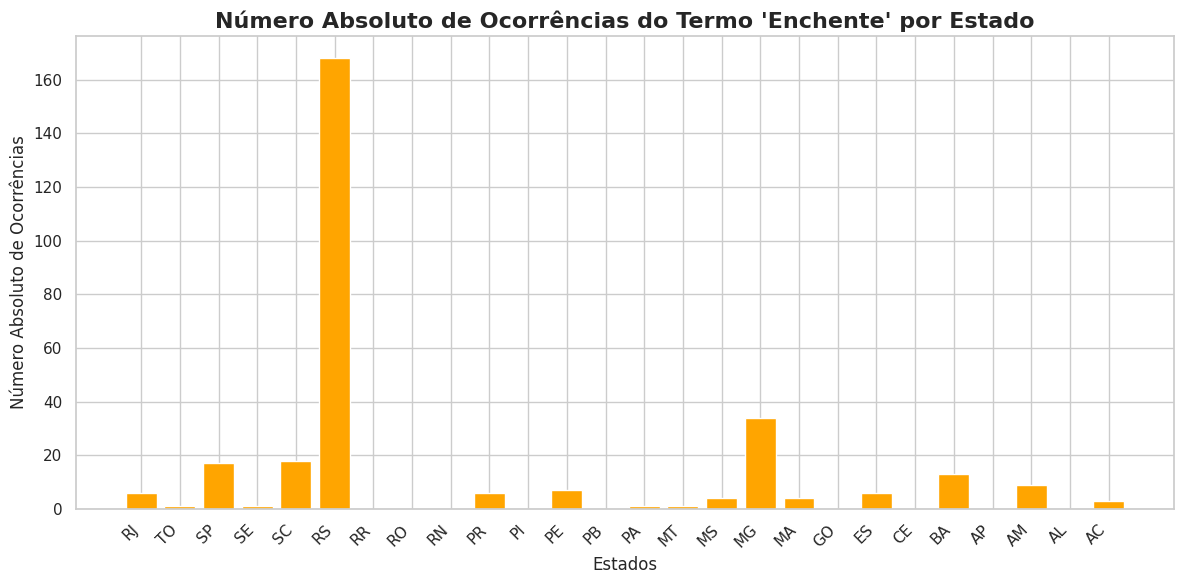

In [ ]:
import matplotlib.pyplot as plt

# Gráfico proporcional ao total de ocorrências (percentual)
total_ocorrencias_por_estado = contagem_df.sum(axis=1)  # Soma total de ocorrências por estado
proporcao_enchente = (contagem_df['enchente'] / total_ocorrencias_por_estado) * 100  # Percentual do termo 'enchente'

plt.figure(figsize=(12, 6))
plt.bar(contagem_df.index, proporcao_enchente, color='skyblue')
plt.title("Proporção de Ocorrências do Termo 'Enchente' por Estado", fontsize=16, weight='bold')
plt.xlabel("Estados", fontsize=12)
plt.ylabel("Proporção (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Gráfico em números absolutos
enchente_abs = contagem_df['enchente']  # Valores absolutos do termo 'enchente'

plt.figure(figsize=(12, 6))
plt.bar(contagem_df.index, enchente_abs, color='orange')
plt.title("Número Absoluto de Ocorrências do Termo 'Enchente' por Estado", fontsize=16, weight='bold')
plt.xlabel("Estados", fontsize=12)
plt.ylabel("Número Absoluto de Ocorrências", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

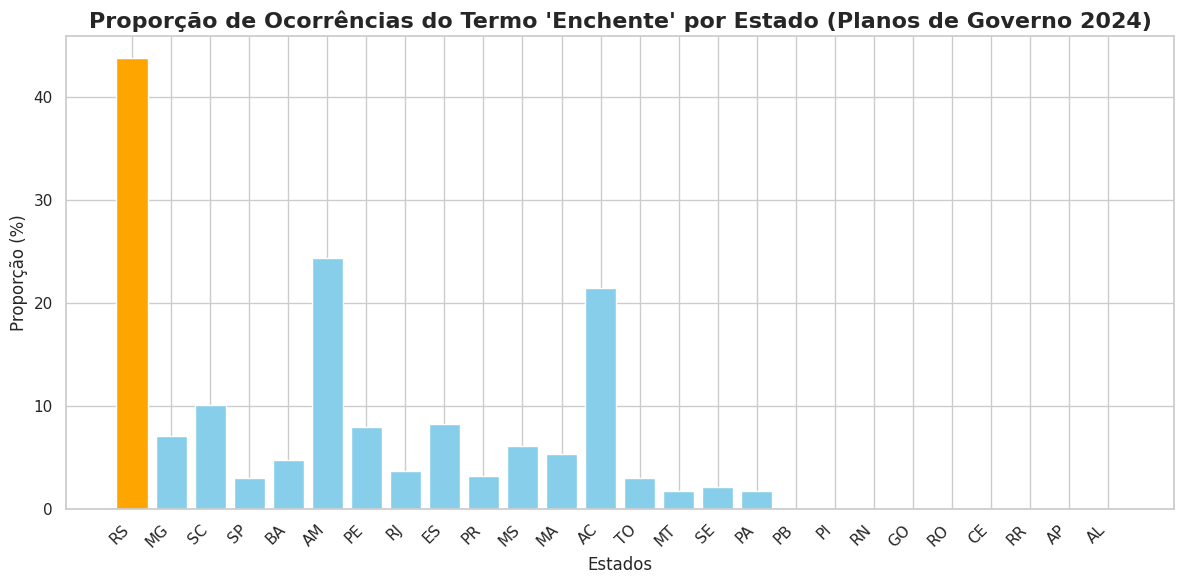

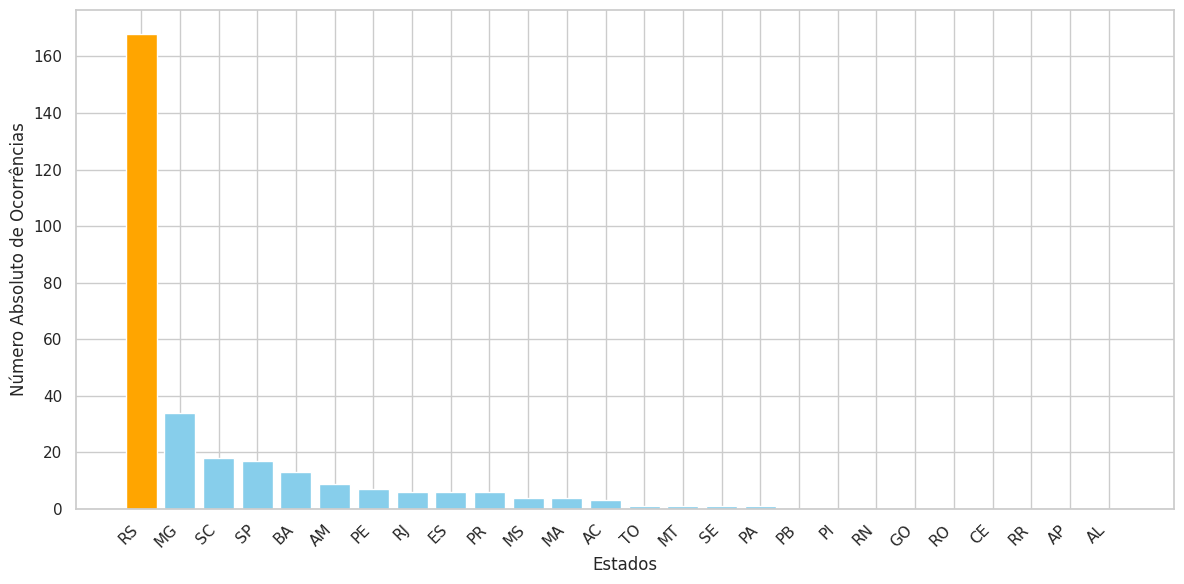

In [ ]:
import matplotlib.pyplot as plt

# Cálculo da proporção do termo 'enchente'
total_ocorrencias_por_estado = contagem_df.sum(axis=1)  # Soma total de ocorrências por estado
proporcao_enchente = (contagem_df['enchente'] / total_ocorrencias_por_estado) * 100  # Percentual do termo 'enchente'

## Criar DataFrame auxiliar para ordenação
enchente_data = pd.DataFrame({
    'estado': contagem_df.index,
    'proporcao_enchente': (contagem_df['enchente'] / total_ocorrencias_por_estado) * 100,
    'enchente_abs': contagem_df['enchente']
}).sort_values(by='enchente_abs', ascending=False)

# Gráfico proporcional ao total de ocorrências (percentual)
plt.figure(figsize=(12, 6))
cores = ['orange' if estado == 'RS' else 'skyblue' for estado in enchente_data['estado']]
plt.bar(enchente_data['estado'], enchente_data['proporcao_enchente'], color=cores)
plt.title("Proporção de Ocorrências do Termo 'Enchente' por Estado (Planos de Governo 2024)", fontsize=16, weight='bold')
plt.xlabel("Estados", fontsize=12)
plt.ylabel("Proporção (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Gráfico em números absolutos
plt.figure(figsize=(12, 6))
plt.bar(enchente_data['estado'], enchente_data['enchente_abs'], color=cores)
#plt.title("Número Absoluto de Ocorrências do Termo 'Enchente' por Estado (Planos de Governo 2024)", fontsize=16, weight='bold')
plt.xlabel("Estados", fontsize=12)
plt.ylabel("Número Absoluto de Ocorrências", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Calcular estatísticas por termo (média e desvio-padrão)
estatisticas_termos = participacao_df.describe().T[['mean', 'std']]

# Função para detectar outliers (valores além de 2 desvios-padrão)
def detectar_outliers(serie, media, desvio):
    limiar_superior = media + 2 * desvio
    return serie > limiar_superior

# DataFrame para armazenar os resultados com NaN para valores que não são outliers
outliers_df = pd.DataFrame(index=participacao_df.index)

# Identificar outliers para cada termo e preencher o DataFrame
for termo in estatisticas_termos.index:
    media = estatisticas_termos.loc[termo, 'mean']
    desvio = estatisticas_termos.loc[termo, 'std']

    # Preencher somente os valores que são outliers, mantendo NaN para os outros
    outliers_df[termo] = participacao_df[termo].where(detectar_outliers(participacao_df[termo], media, desvio))

# Salvar o DataFrame com todos os estados e outliers marcados
outliers_df.to_csv("outliers_completos.csv")

# Exibir os resultados
print("Estados que são outliers por termo:")
print(outliers_df)

Estados que são outliers por termo:
        enchente  inundacao  alagamento      chuva  tempestade
estado                                                        
RJ           NaN        NaN         NaN        NaN         NaN
TO           NaN        NaN         NaN        NaN         NaN
SP           NaN        NaN         NaN        NaN         NaN
SE           NaN        NaN         NaN        NaN         NaN
SC           NaN        NaN         NaN        NaN         NaN
RS         43.75        NaN         NaN        NaN         NaN
RR           NaN        NaN   62.500000        NaN         NaN
RO           NaN        NaN         NaN  92.857143         NaN
RN           NaN        NaN         NaN        NaN         NaN
PR           NaN        NaN         NaN        NaN         NaN
PI           NaN        NaN         NaN        NaN         NaN
PE           NaN        NaN         NaN        NaN         NaN
PB           NaN        NaN         NaN        NaN         NaN
PA           NaN   

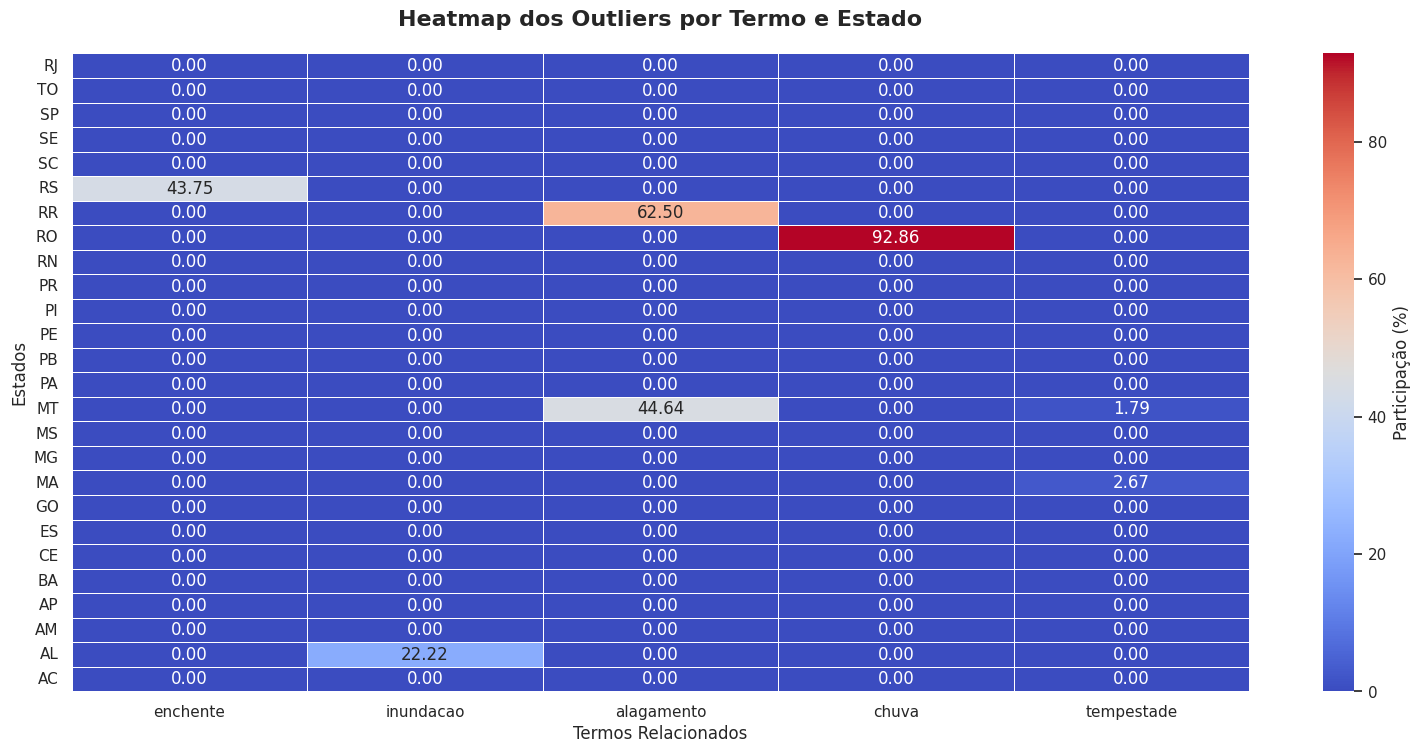

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Substituir NaN por 0 para visualização
outliers_numeric = outliers_df.fillna(0)

# Configurar o tamanho da figura e o heatmap
plt.figure(figsize=(16, 8))
ax = sns.heatmap(
    outliers_numeric,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Participação (%)'},
    linewidths=0.5,
    xticklabels=outliers_numeric.columns,
    yticklabels=outliers_numeric.index
)

# Configurar o título e os eixos
plt.title("Heatmap dos Outliers por Termo e Estado", fontsize=16, weight='bold', pad=20)
plt.xlabel("Termos Relacionados", fontsize=12)
plt.ylabel("Estados", fontsize=12)

# Ajustar o espaço do gráfico
plt.tight_layout(pad=2.0)  # Garantir um espaço adequado ao redor do gráfico

# Adicionar uma nota explicativa acima do eixo X
#plt.figtext(
#    0.5, -0.1,
#    "Nota: Os valores indicam a participação percentual dos estados para cada termo. Valores '0%' representam que o estado não teve destaque suficiente para ser considerado um outlier no termo correspondente.",
#    ha="center", fontsize=10, wrap=True
#)

# Exibir o gráfico
plt.show()


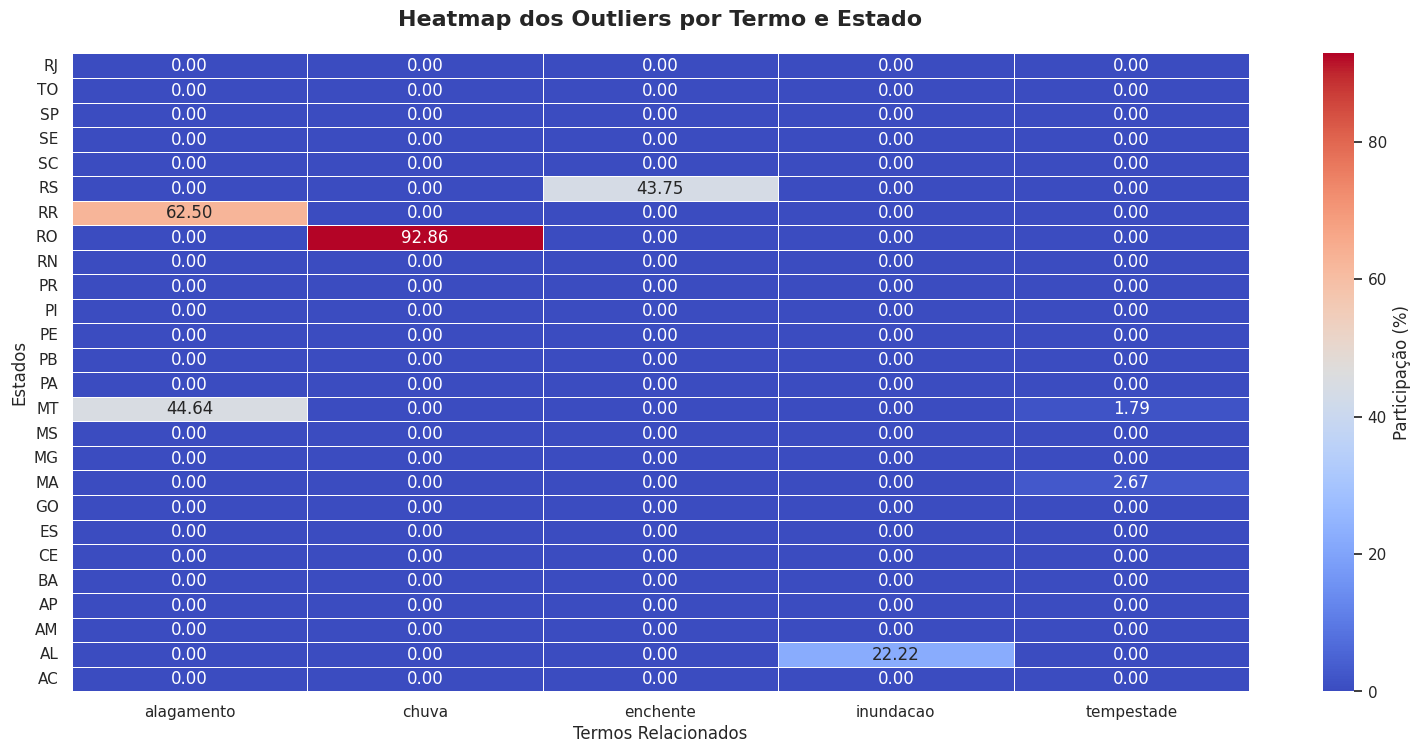

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ordenar os termos em ordem alfabética
outliers_numeric_sorted = outliers_numeric[outliers_numeric.columns.sort_values()]

# Configurar o tamanho da figura e o heatmap
plt.figure(figsize=(16, 8))
ax = sns.heatmap(
    outliers_numeric_sorted,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Participação (%)'},
    linewidths=0.5,
    xticklabels=outliers_numeric_sorted.columns,
    yticklabels=outliers_numeric_sorted.index
)

# Configurar o título e os eixos
plt.title("Heatmap dos Outliers por Termo e Estado", fontsize=16, weight='bold', pad=20)
plt.xlabel("Termos Relacionados", fontsize=12)
plt.ylabel("Estados", fontsize=12)

# Ajustar o espaço do gráfico
plt.tight_layout(pad=2.0)  # Garantir um espaço adequado ao redor do gráfico

# Exibir o gráfico
plt.show()

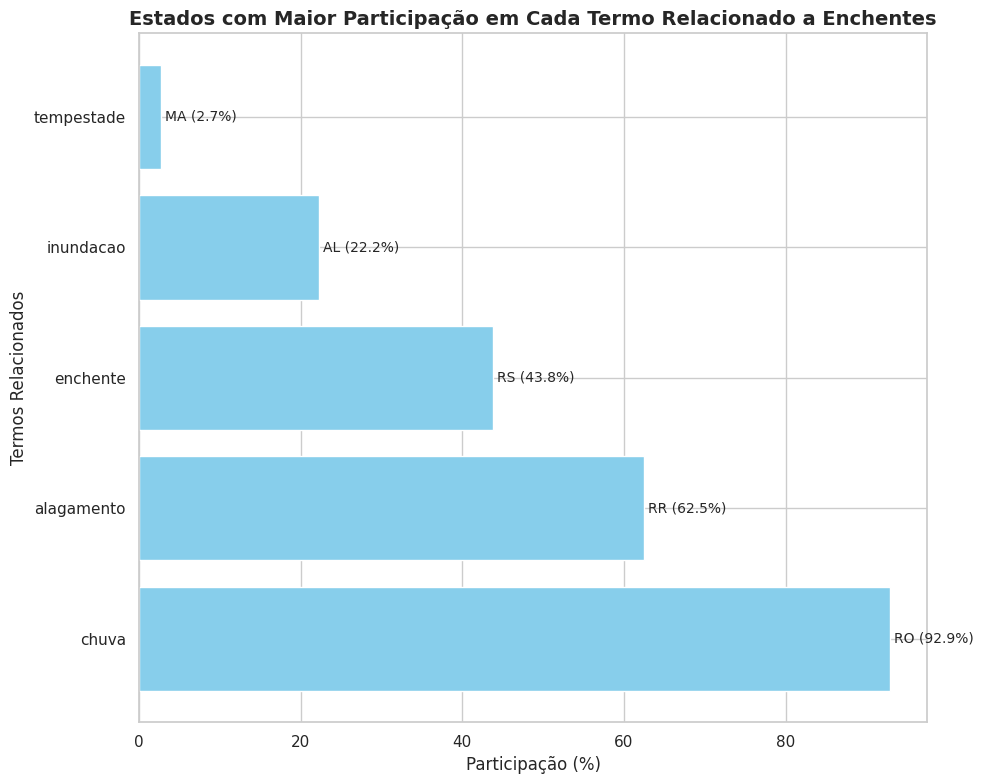

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Remover colunas desnecessárias do DataFrame
colunas_indesejadas = ['soma_total_corrigida_pct', 'soma_total_corrigida', 'soma_total']
participacao_df = participacao_df.drop(columns=colunas_indesejadas, errors='ignore')

# Identificar os estados com maior participação em cada termo (outliers)
outliers_df = participacao_df.idxmax()
outliers_participacao = participacao_df.max()

# Criar DataFrame auxiliar para visualização
outliers_data = pd.DataFrame({
    'Termo': outliers_df.index,
    'Estado': outliers_df.values,
    'Participação (%)': outliers_participacao.values
}).sort_values(by='Participação (%)', ascending=False)

# Visualização simplificada: gráfico de barras horizontais
plt.figure(figsize=(10, 8))
bars = plt.barh(outliers_data['Termo'], outliers_data['Participação (%)'], color='skyblue')

# Destacar estados outliers na barra
for i, (estado, participacao) in enumerate(zip(outliers_data['Estado'], outliers_data['Participação (%)'])):
    plt.text(participacao + 0.5, i, f"{estado} ({participacao:.1f}%)", va='center', fontsize=10)

# Configurações do gráfico
plt.title('Estados com Maior Participação em Cada Termo Relacionado a Enchentes', fontsize=14, weight='bold')
plt.xlabel('Participação (%)', fontsize=12)
plt.ylabel('Termos Relacionados', fontsize=12)
plt.tight_layout()

# Exibir o gráfico
plt.show()

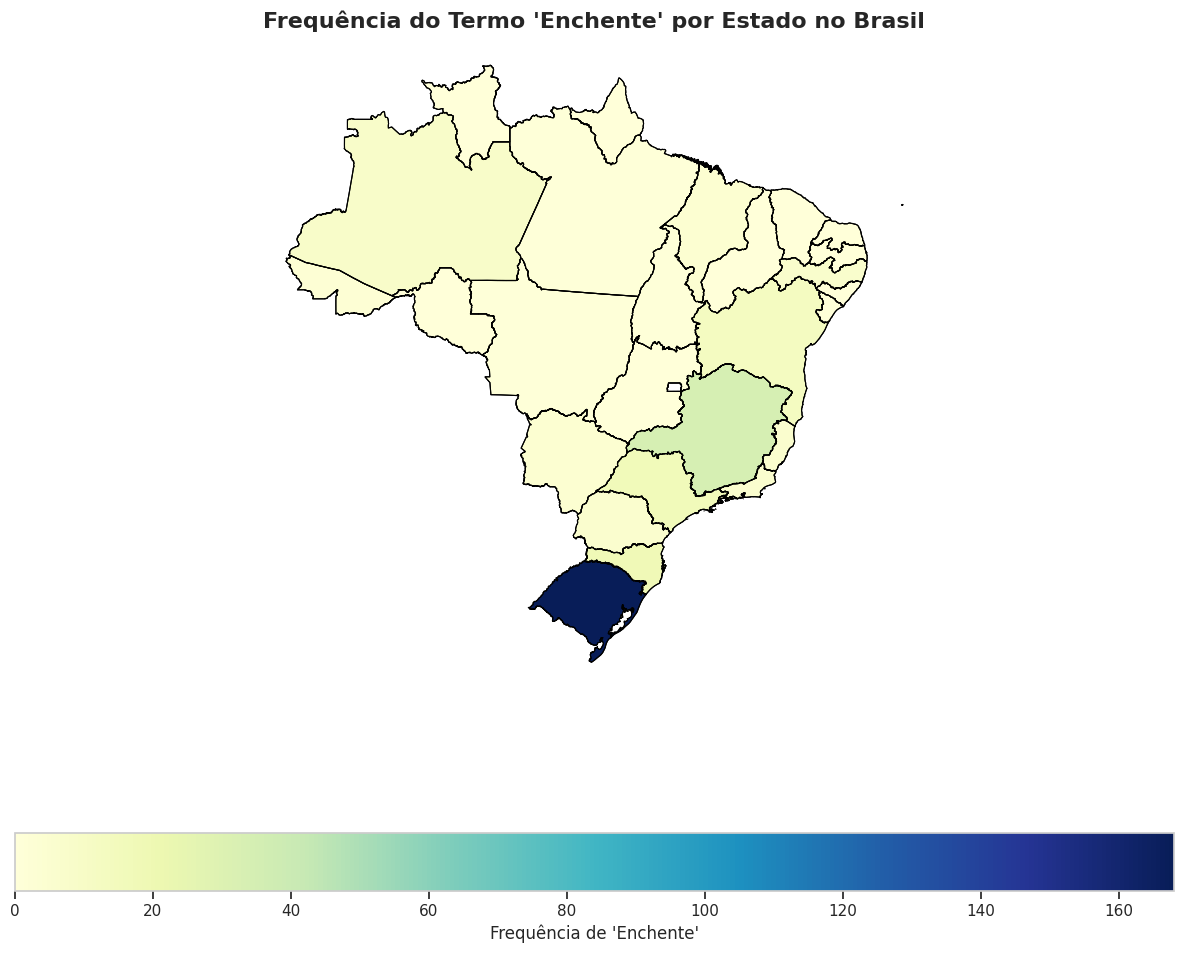

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Supondo que o DataFrame `contagem_df` contém a contagem absoluta do termo "enchente" por estado
# e que a coluna `estado` contém as siglas dos estados brasileiros

# Criar DataFrame auxiliar para o mapa
mapa_data = pd.DataFrame({
    'estado': contagem_df.index,  # Siglas dos estados
    'frequencia_enchente': contagem_df['enchente']  # Frequência do termo 'enchente'
}).reset_index(drop=True)  # Resetar o índice para evitar ambiguidades

# Adicionar nomes completos dos estados para juntar ao GeoDataFrame
estado_nomes = {
    "AC": "Acre", "AL": "Alagoas", "AP": "Amapá", "AM": "Amazonas", "BA": "Bahia",
    "CE": "Ceará", "DF": "Distrito Federal", "ES": "Espírito Santo", "GO": "Goiás",
    "MA": "Maranhão", "MT": "Mato Grosso", "MS": "Mato Grosso do Sul", "MG": "Minas Gerais",
    "PA": "Pará", "PB": "Paraíba", "PR": "Paraná", "PE": "Pernambuco", "PI": "Piauí",
    "RJ": "Rio de Janeiro", "RN": "Rio Grande do Norte", "RS": "Rio Grande do Sul",
    "RO": "Rondônia", "RR": "Roraima", "SC": "Santa Catarina", "SP": "São Paulo",
    "SE": "Sergipe", "TO": "Tocantins"
}
mapa_data['estado_nome'] = mapa_data['estado'].map(estado_nomes)

# Carregar o GeoDataFrame do Brasil com estados
brasil = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")

# Garantir que o GeoDataFrame também não tenha ambiguidades com índices
brasil = brasil.reset_index(drop=True)

# Combinar os dados de frequência com o GeoDataFrame
brasil = brasil.merge(mapa_data, left_on="sigla", right_on="estado", how="left")

# Criar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
brasil.boundary.plot(ax=ax, linewidth=0.8, color="black")  # Fronteiras dos estados
brasil.plot(
    column="frequencia_enchente",  # Coluna para colorir
    cmap="YlGnBu",  # Paleta de cores
    linewidth=0.8,
    ax=ax,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Frequência de 'Enchente'", "orientation": "horizontal"}
)

# Adicionar título
plt.title("Frequência do Termo 'Enchente' por Estado no Brasil", fontsize=16, weight="bold")
plt.axis("off")  # Retirar os eixos
plt.tight_layout()

# Exibir o mapa
plt.show()

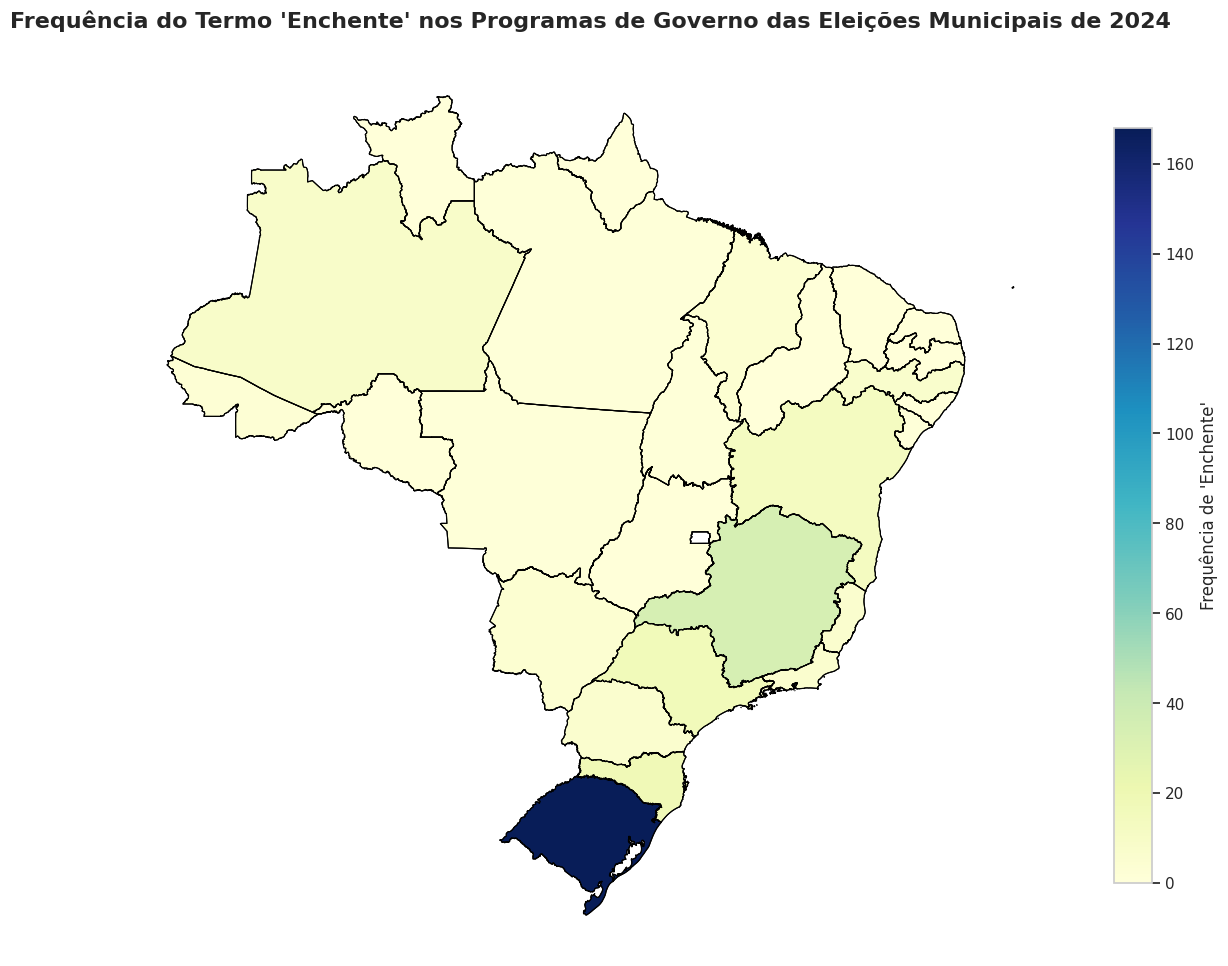

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Supondo que o DataFrame `contagem_df` contém a contagem absoluta do termo "enchente" por estado
# e que a coluna `estado` contém as siglas dos estados brasileiros

# Criar DataFrame auxiliar para o mapa
mapa_data = pd.DataFrame({
    'estado': contagem_df.index,  # Siglas dos estados
    'frequencia_enchente': contagem_df['enchente']  # Frequência do termo 'enchente'
}).reset_index(drop=True)  # Resetar o índice para evitar ambiguidades

# Adicionar nomes completos dos estados para juntar ao GeoDataFrame
estado_nomes = {
    "AC": "Acre", "AL": "Alagoas", "AP": "Amapá", "AM": "Amazonas", "BA": "Bahia",
    "CE": "Ceará", "DF": "Distrito Federal", "ES": "Espírito Santo", "GO": "Goiás",
    "MA": "Maranhão", "MT": "Mato Grosso", "MS": "Mato Grosso do Sul", "MG": "Minas Gerais",
    "PA": "Pará", "PB": "Paraíba", "PR": "Paraná", "PE": "Pernambuco", "PI": "Piauí",
    "RJ": "Rio de Janeiro", "RN": "Rio Grande do Norte", "RS": "Rio Grande do Sul",
    "RO": "Rondônia", "RR": "Roraima", "SC": "Santa Catarina", "SP": "São Paulo",
    "SE": "Sergipe", "TO": "Tocantins"
}
mapa_data['estado_nome'] = mapa_data['estado'].map(estado_nomes)

# Carregar o GeoDataFrame do Brasil com estados
brasil = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")

# Garantir que o GeoDataFrame também não tenha ambiguidades com índices
brasil = brasil.reset_index(drop=True)

# Combinar os dados de frequência com o GeoDataFrame
brasil = brasil.merge(mapa_data, left_on="sigla", right_on="estado", how="left")

# Criar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
brasil.boundary.plot(ax=ax, linewidth=0.8, color="black")  # Fronteiras dos estados
mapa = brasil.plot(
    column="frequencia_enchente",  # Coluna para colorir
    cmap="YlGnBu",  # Paleta de cores
    linewidth=0.8,
    ax=ax,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Frequência de 'Enchente'",
        "orientation": "vertical",
        "shrink": 0.8,  # Reduz o tamanho da barra para posicionar melhor
        "pad": 0.05     # Adiciona espaço entre o gráfico e a barra
    }
)

# Adicionar título
plt.title(
    "Frequência do Termo 'Enchente' nos Programas de Governo das Eleições Municipais de 2024",
    fontsize=16, weight="bold", pad=20  # Adiciona espaço entre o título e o gráfico
)
plt.axis("off")  # Retirar os eixos
plt.tight_layout()

# Exibir o mapa
plt.show()

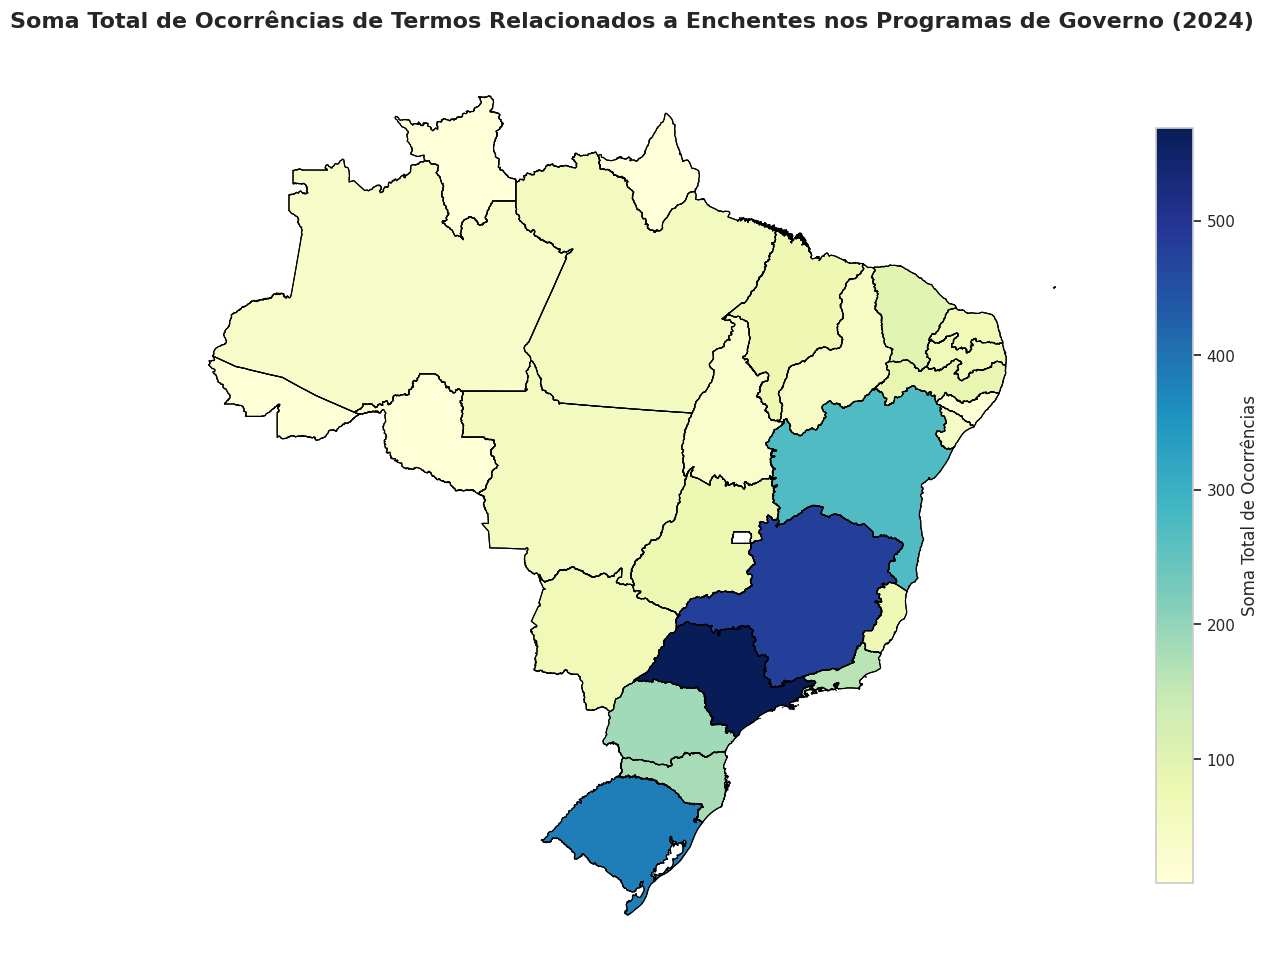

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Carregar os dados de contagem absoluta (contagem_df já contém os valores absolutos)
mapa_data = pd.DataFrame({
    'estado': contagem_df.index,  # Siglas dos estados
    'soma_total': contagem_df.sum(axis=1)  # Soma total de ocorrências de todos os termos por estado
}).reset_index(drop=True)

# Adicionar nomes completos dos estados para juntar ao GeoDataFrame
estado_nomes = {
    "AC": "Acre", "AL": "Alagoas", "AP": "Amapá", "AM": "Amazonas", "BA": "Bahia",
    "CE": "Ceará", "DF": "Distrito Federal", "ES": "Espírito Santo", "GO": "Goiás",
    "MA": "Maranhão", "MT": "Mato Grosso", "MS": "Mato Grosso do Sul", "MG": "Minas Gerais",
    "PA": "Pará", "PB": "Paraíba", "PR": "Paraná", "PE": "Pernambuco", "PI": "Piauí",
    "RJ": "Rio de Janeiro", "RN": "Rio Grande do Norte", "RS": "Rio Grande do Sul",
    "RO": "Rondônia", "RR": "Roraima", "SC": "Santa Catarina", "SP": "São Paulo",
    "SE": "Sergipe", "TO": "Tocantins"
}
mapa_data['estado_nome'] = mapa_data['estado'].map(estado_nomes)

# Carregar o GeoDataFrame do Brasil com estados
brasil = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")

# Garantir que o GeoDataFrame também não tenha ambiguidades com índices
brasil = brasil.reset_index(drop=True)

# Combinar os dados de frequência com o GeoDataFrame
brasil = brasil.merge(mapa_data, left_on="sigla", right_on="estado", how="left")

# Criar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
brasil.boundary.plot(ax=ax, linewidth=0.8, color="black")  # Fronteiras dos estados
mapa = brasil.plot(
    column="soma_total",  # Coluna para colorir
    cmap="YlGnBu",  # Paleta de cores
    linewidth=0.8,
    ax=ax,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Soma Total de Ocorrências",
        "orientation": "vertical",
        "shrink": 0.8,  # Reduz o tamanho da barra para posicionar melhor
        "pad": 0.05     # Adiciona espaço entre o gráfico e a barra
    }
)

# Adicionar título
plt.title(
    "Soma Total de Ocorrências de Termos Relacionados a Enchentes nos Programas de Governo (2024)",
    fontsize=16, weight="bold", pad=20  # Adiciona espaço entre o título e o gráfico
)
plt.axis("off")  # Retirar os eixos
plt.tight_layout()

# Exibir o mapa
plt.show()

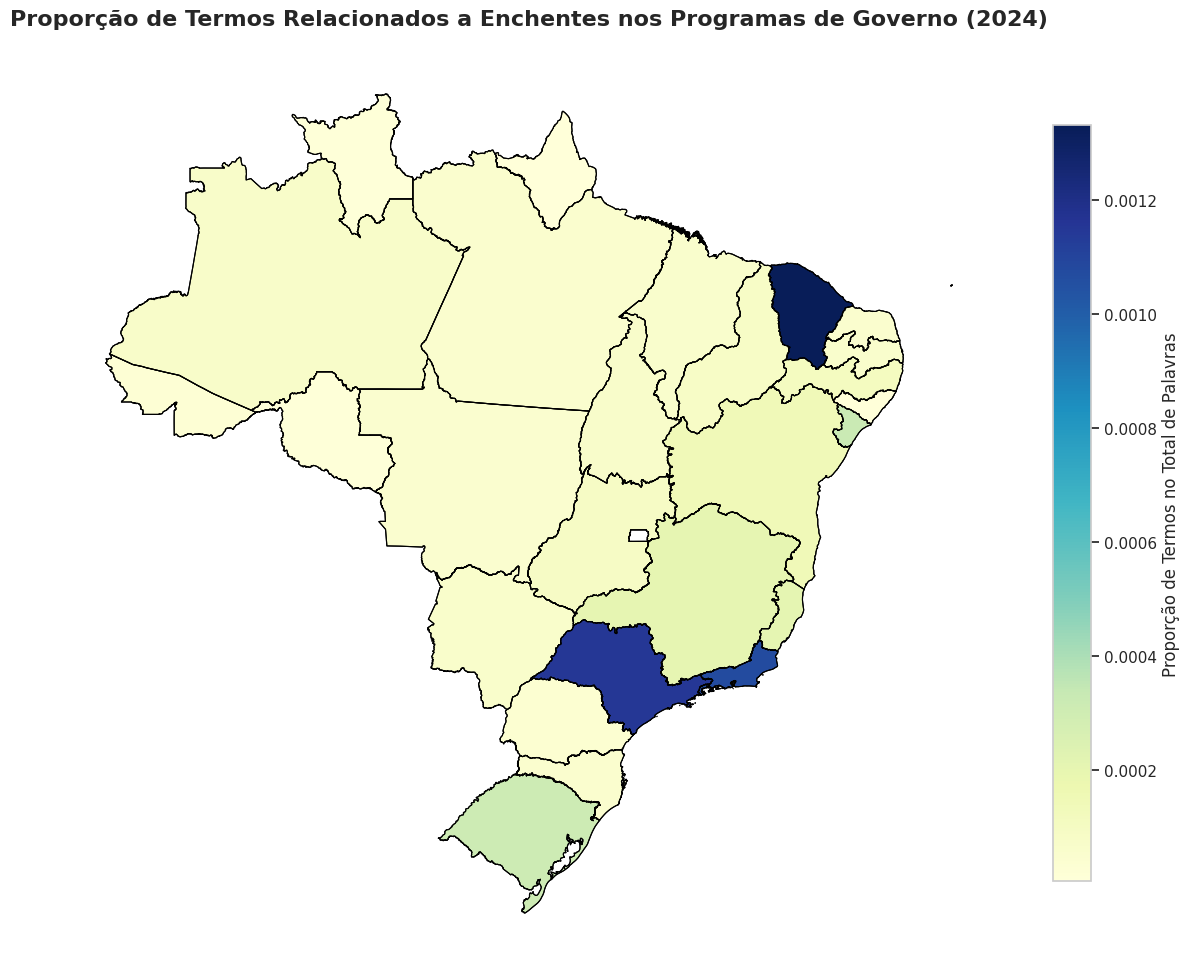

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Supondo que contagem_df contém as contagens de todos os termos e df contém o texto dos programas de governo
# Calcular a soma de termos por estado
mapa_data = pd.DataFrame({
    'estado': contagem_df.index,  # Siglas dos estados
    'soma_total': contagem_df.sum(axis=1)  # Soma total de ocorrências de termos relacionados a enchentes
}).reset_index(drop=True)

# Calcular o total de palavras por estado no texto corrigido
mapa_data['total_palavras'] = df.groupby('estado')['texto_corrigido'].apply(
    lambda x: x.str.split().str.len().sum()  # Contar palavras em cada estado
).reset_index(drop=True)

# Calcular a proporção de termos em relação ao total de palavras
mapa_data['proporcao'] = mapa_data['soma_total'] / mapa_data['total_palavras']

# Adicionar nomes completos dos estados para juntar ao GeoDataFrame
estado_nomes = {
    "AC": "Acre", "AL": "Alagoas", "AP": "Amapá", "AM": "Amazonas", "BA": "Bahia",
    "CE": "Ceará", "DF": "Distrito Federal", "ES": "Espírito Santo", "GO": "Goiás",
    "MA": "Maranhão", "MT": "Mato Grosso", "MS": "Mato Grosso do Sul", "MG": "Minas Gerais",
    "PA": "Pará", "PB": "Paraíba", "PR": "Paraná", "PE": "Pernambuco", "PI": "Piauí",
    "RJ": "Rio de Janeiro", "RN": "Rio Grande do Norte", "RS": "Rio Grande do Sul",
    "RO": "Rondônia", "RR": "Roraima", "SC": "Santa Catarina", "SP": "São Paulo",
    "SE": "Sergipe", "TO": "Tocantins"
}
mapa_data['estado_nome'] = mapa_data['estado'].map(estado_nomes)

# Carregar o GeoDataFrame do Brasil com estados
brasil = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")

# Garantir que o GeoDataFrame também não tenha ambiguidades com índices
brasil = brasil.reset_index(drop=True)

# Combinar os dados de proporção com o GeoDataFrame
brasil = brasil.merge(mapa_data, left_on="sigla", right_on="estado", how="left")

# Criar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
brasil.boundary.plot(ax=ax, linewidth=0.8, color="black")  # Fronteiras dos estados
mapa = brasil.plot(
    column="proporcao",  # Coluna para colorir
    cmap="YlGnBu",  # Paleta de cores
    linewidth=0.8,
    ax=ax,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Proporção de Termos no Total de Palavras",
        "orientation": "vertical",
        "shrink": 0.8,  # Reduz o tamanho da barra para posicionar melhor
        "pad": 0.05     # Adiciona espaço entre o gráfico e a barra
    }
)

# Adicionar título
plt.title(
    "Proporção de Termos Relacionados a Enchentes nos Programas de Governo (2024)",
    fontsize=16, weight="bold", pad=20  # Adiciona espaço entre o título e o gráfico
)
plt.axis("off")  # Retirar os eixos
plt.tight_layout()

# Exibir o mapa
plt.show()

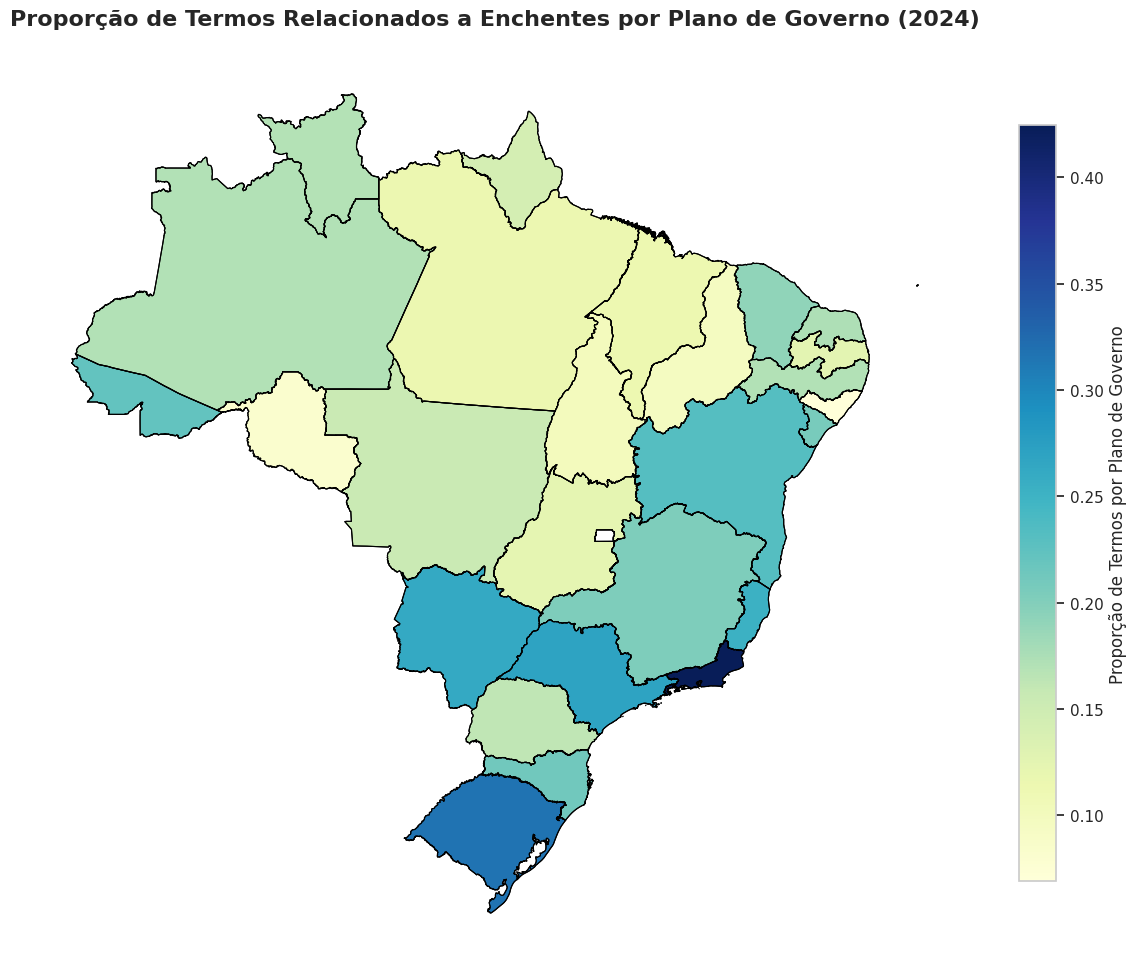

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Supondo que contagem_df contém as contagens de todos os termos e pdf_counts contém a contagem de PDFs por estado
# Calcular a soma de termos por estado
mapa_data = pd.DataFrame({
    'estado': contagem_df.index,  # Siglas dos estados
    'soma_total': contagem_df.sum(axis=1)  # Soma total de ocorrências de termos relacionados a enchentes
}).reset_index(drop=True)

# Adicionar o número de PDFs por estado
mapa_data['pdfs_totais'] = mapa_data['estado'].map(pdf_counts)  # Mapear os PDFs para cada estado

# Calcular a proporção de termos em relação ao total de planos de governo
mapa_data['proporcao_por_pdf'] = mapa_data['soma_total'] / mapa_data['pdfs_totais']

# Adicionar nomes completos dos estados para juntar ao GeoDataFrame
estado_nomes = {
    "AC": "Acre", "AL": "Alagoas", "AP": "Amapá", "AM": "Amazonas", "BA": "Bahia",
    "CE": "Ceará", "DF": "Distrito Federal", "ES": "Espírito Santo", "GO": "Goiás",
    "MA": "Maranhão", "MT": "Mato Grosso", "MS": "Mato Grosso do Sul", "MG": "Minas Gerais",
    "PA": "Pará", "PB": "Paraíba", "PR": "Paraná", "PE": "Pernambuco", "PI": "Piauí",
    "RJ": "Rio de Janeiro", "RN": "Rio Grande do Norte", "RS": "Rio Grande do Sul",
    "RO": "Rondônia", "RR": "Roraima", "SC": "Santa Catarina", "SP": "São Paulo",
    "SE": "Sergipe", "TO": "Tocantins"
}
mapa_data['estado_nome'] = mapa_data['estado'].map(estado_nomes)

# Carregar o GeoDataFrame do Brasil com estados
brasil = gpd.read_file("https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson")

# Garantir que o GeoDataFrame também não tenha ambiguidades com índices
brasil = brasil.reset_index(drop=True)

# Combinar os dados de proporção com o GeoDataFrame
brasil = brasil.merge(mapa_data, left_on="sigla", right_on="estado", how="left")

# Criar o mapa
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
brasil.boundary.plot(ax=ax, linewidth=0.8, color="black")  # Fronteiras dos estados
mapa = brasil.plot(
    column="proporcao_por_pdf",  # Coluna para colorir
    cmap="YlGnBu",  # Paleta de cores
    linewidth=0.8,
    ax=ax,
    edgecolor="black",
    legend=True,
    legend_kwds={
        "label": "Proporção de Termos por Plano de Governo",
        "orientation": "vertical",
        "shrink": 0.8,  # Reduz o tamanho da barra para posicionar melhor
        "pad": 0.05     # Adiciona espaço entre o gráfico e a barra
    }
)

# Adicionar título
plt.title(
    "Proporção de Termos Relacionados a Enchentes por Plano de Governo (2024)",
    fontsize=16, weight="bold", pad=20  # Adiciona espaço entre o título e o gráfico
)
plt.axis("off")  # Retirar os eixos
plt.tight_layout()

# Exibir o mapa
plt.show()

<ipython-input-6-7ed7ffeb099e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


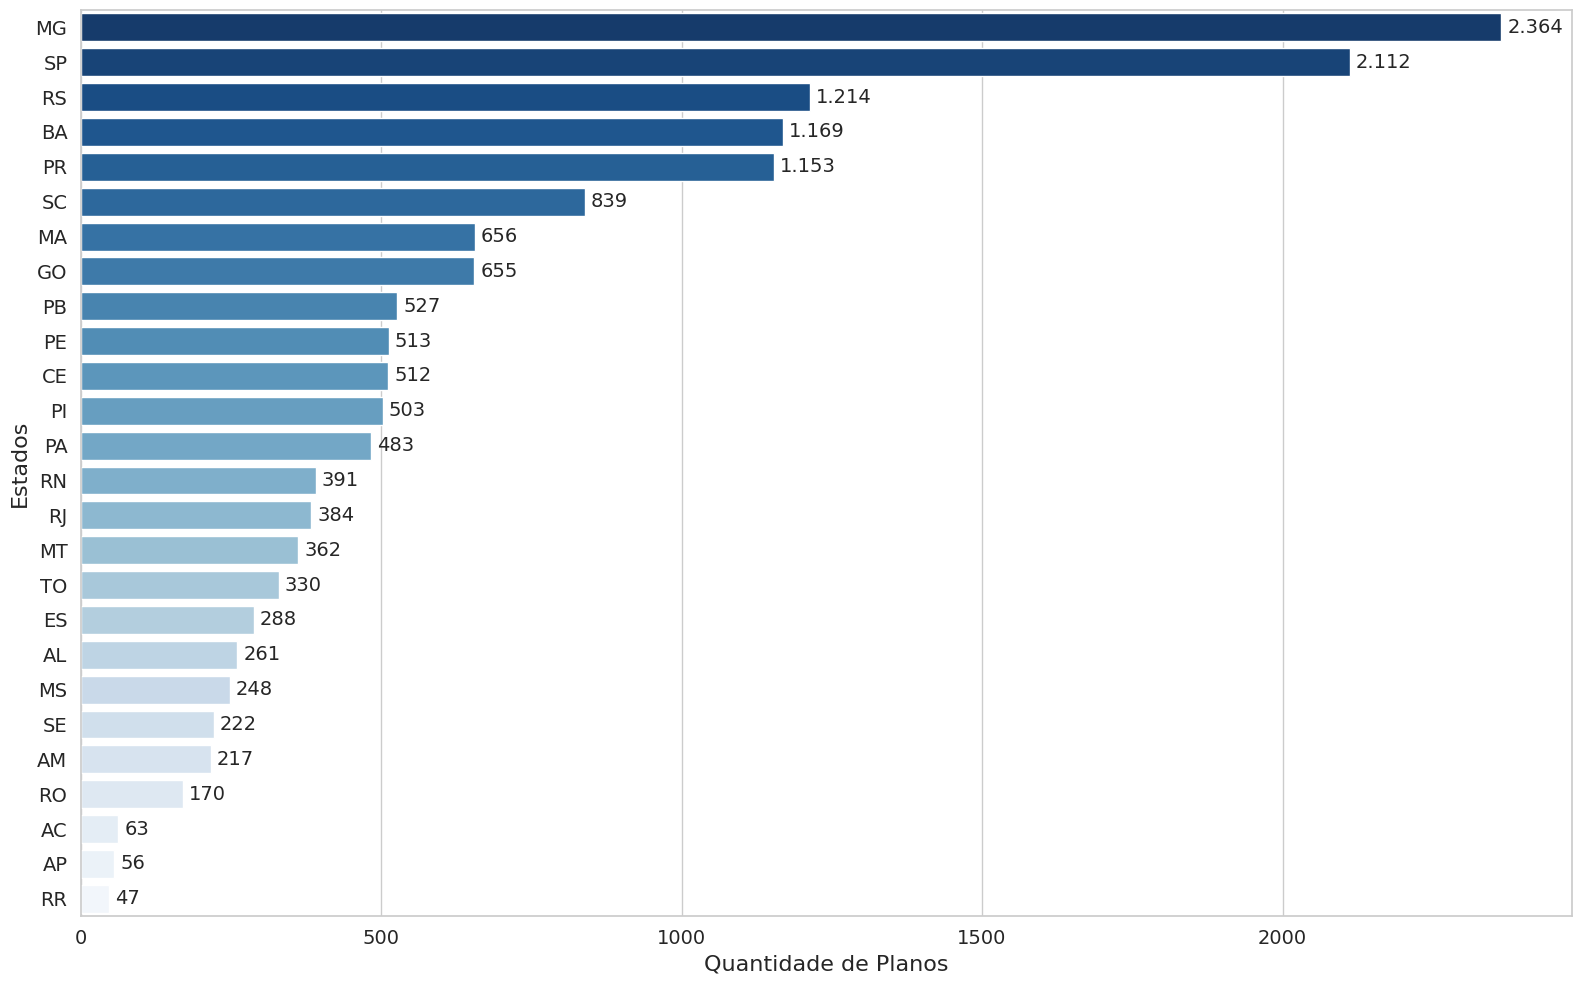

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dados simulados ou carregados anteriormente
pdf_counts = {
    'RJ': 384, 'TO': 330, 'SP': 2112, 'SE': 222, 'SC': 839, 'RS': 1214, 'RR': 47,
    'RO': 170, 'RN': 391, 'PR': 1153, 'PI': 503, 'PE': 513, 'PB': 527, 'PA': 483,
    'MT': 362, 'MS': 248, 'MG': 2364, 'MA': 656, 'GO': 655, 'ES': 288, 'CE': 512,
    'BA': 1169, 'AP': 56, 'AM': 217, 'AL': 261, 'AC': 63
}

# Converter para DataFrame
pdf_counts_df = pd.DataFrame(list(pdf_counts.items()), columns=['Estado', 'Quantidade de Planos'])
pdf_counts_df = pdf_counts_df.sort_values(by='Quantidade de Planos', ascending=False)

# Configuração do estilo do gráfico
sns.set(style="whitegrid")

# Criar o gráfico
plt.figure(figsize=(16, 10))
ax = sns.barplot(
    x="Quantidade de Planos",
    y="Estado",
    data=pdf_counts_df,
    palette="Blues_r"
)

# Adicionar rótulos nas barras com separadores de milhar no formato brasileiro
for index, value in enumerate(pdf_counts_df["Quantidade de Planos"]):
    ax.text(value + 10, index, f'{value:,.0f}'.replace(',', '.'), va='center', fontsize=14)  # Aproximar valores

# Título e rótulos com tamanhos maiores
#plt.title("Quantidade de Planos de Governo por Estado", fontsize=20, weight="bold")
plt.xlabel("Quantidade de Planos", fontsize=16)
plt.ylabel("Estados", fontsize=16)

# Ajustar os ticks do eixo para fontes maiores
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

<ipython-input-117-cc9fb9ca7497>:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




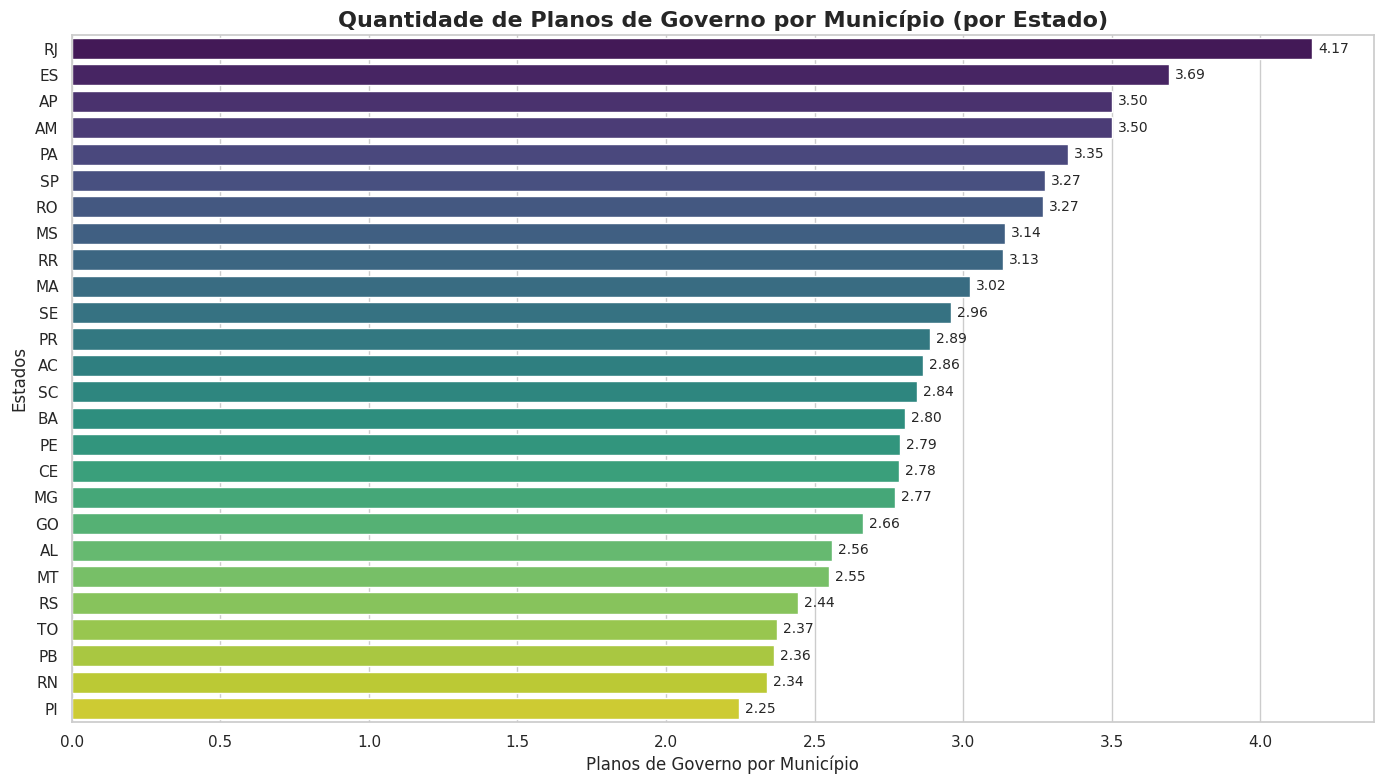

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dados fornecidos
municipios_data = {
    "Estado": ["MG", "SP", "RS", "BA", "PR", "SC", "GO", "PI", "PB", "MA", "PE", "CE", "RN", "PA", "MT", "TO", "AL", "RJ", "MS", "ES", "SE", "AM", "RO", "AC", "AP", "RR"],
    "Numero_Municipios": [853, 645, 497, 417, 399, 295, 246, 224, 223, 217, 184, 184, 167, 144, 142, 139, 102, 92, 79, 78, 75, 62, 52, 22, 16, 15]
}

# Dados de planos de governo por estado
pdf_counts = {
    'RJ': 384, 'TO': 330, 'SP': 2112, 'SE': 222, 'SC': 839, 'RS': 1214, 'RR': 47,
    'RO': 170, 'RN': 391, 'PR': 1153, 'PI': 503, 'PE': 513, 'PB': 527, 'PA': 483,
    'MT': 362, 'MS': 248, 'MG': 2364, 'MA': 656, 'GO': 655, 'ES': 288, 'CE': 512,
    'BA': 1169, 'AP': 56, 'AM': 217, 'AL': 261, 'AC': 63
}

# Criar DataFrame com os dados
municipios_df = pd.DataFrame(municipios_data)
pdf_counts_df = pd.DataFrame(list(pdf_counts.items()), columns=['Estado', 'Planos_Governo'])

# Mesclar os DataFrames
merged_df = municipios_df.merge(pdf_counts_df, on="Estado")

# Calcular a quantidade de planos por município
merged_df['Planos_Por_Municipio'] = merged_df['Planos_Governo'] / merged_df['Numero_Municipios']

# Ordenar os dados
merged_df = merged_df.sort_values(by='Planos_Por_Municipio', ascending=False)

# Visualizar os dados
plt.figure(figsize=(14, 8))
sns.barplot(
    x="Planos_Por_Municipio",
    y="Estado",
    data=merged_df,
    palette="viridis"
)

# Adicionar rótulos nas barras
for index, value in enumerate(merged_df['Planos_Por_Municipio']):
    plt.text(value + 0.02, index, f"{value:.2f}", va='center', fontsize=10)

# Configurar título e rótulos
plt.title("Quantidade de Planos de Governo por Município (por Estado)", fontsize=16, weight="bold")
plt.xlabel("Planos de Governo por Município", fontsize=12)
plt.ylabel("Estados", fontsize=12)

# Ajustar layout
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Carregar o novo arquivo corrigido
df = pd.read_csv("texto_corrigido_utf8.csv")

# Preencher valores nulos no texto corrigido
df['texto_corrigido'] = df['texto_corrigido'].fillna('')

# Lista de palavras relacionadas a enchentes (sem caracteres especiais)
palavras_enchentes = [
    "mudanças climáticas"
]

# Filtrar apenas as palavras de interesse nos textos do DataFrame
def filtrar_palavras_interesse(texto, palavras_chave):
    # Compilar o regex com as palavras-chave, incluindo frases compostas
    palavras_regex = r'\b(?:' + '|'.join(map(re.escape, palavras_chave)) + r')\b'
    # Extrair apenas as palavras que correspondem às palavras-chave
    return ' '.join(re.findall(palavras_regex, str(texto), flags=re.IGNORECASE))

# Aplicar a filtragem no texto corrigido de cada estado
df['texto_filtrado_corrigido'] = df['texto_corrigido'].apply(
    lambda x: filtrar_palavras_interesse(x, palavras_enchentes)
)

# Configurar o CountVectorizer para bigramas (n-grams até o tamanho 2) e usar palavras compostas
vectorizer = CountVectorizer(ngram_range=(1, 2), vocabulary=palavras_enchentes)
contagem_matrix = vectorizer.fit_transform(df['texto_filtrado_corrigido'])

# DataFrame com as contagens de termos específicos para enchentes
contagem_df = pd.DataFrame(contagem_matrix.toarray(), index=df['estado'], columns=vectorizer.get_feature_names_out())

# Garantir que todos os estados apareçam, mesmo que zerados
contagem_df = contagem_df.reindex(df['estado'], fill_value=0)

# Exibir a frequência de termos relacionados a enchentes
print("Frequência de termos sobre enchentes por estado:")
print(contagem_df)

# Salvar o DataFrame de contagens em um arquivo CSV
contagem_df.to_csv("frequencia_termos_enchentes_corrigido.csv")

Frequência de termos sobre enchentes por estado:
        mudanças climáticas
estado                     
RJ                        0
TO                        0
SP                        0
SE                        0
SC                        0
RS                        0
RR                        0
RO                        0
RN                        0
PR                        0
PI                        0
PE                        0
PB                        0
PA                        0
MT                        0
MS                        0
MG                        0
MA                        0
GO                        0
ES                        0
CE                        0
BA                        0
AP                        0
AM                        0
AL                        0
AC                        0


In [ ]:
# Contar a quantidade total de programas de governo (PDFs) por estado
total_planos_governo = sum(pdf_counts.values())

# Exibir o resultado
print(f"Total de Programas de Governo: {total_planos_governo}")

Total de Programas de Governo: 15739


# **Eleições 2020**

## **Extração do texto**

In [ ]:
pip install PyDrive PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 8.3 MB/s eta 0:00:00


In [ ]:
import os
import unicodedata
import PyPDF2
import pandas as pd
import logging
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

# Função para normalizar o texto para UTF-8
def normalizar_texto(texto):
    if texto is None:
        return ""
    return unicodedata.normalize('NFKD', texto).encode('utf-8', errors='ignore').decode('utf-8')

# Configurações do log
logging.basicConfig(filename="processamento.log", level=logging.INFO)

def registrar_log(mensagem):
    logging.info(mensagem)

# Função para autenticar manualmente
def autenticar_drive(gauth):
    if not os.path.exists("mycreds.json"):  # Se as credenciais não existirem
        gauth.CommandLineAuth()  # Autenticação manual
        gauth.SaveCredentialsFile("mycreds.json")  # Salva as credenciais
        registrar_log("Credenciais salvas após autenticação manual.")
    else:
        gauth.LoadCredentialsFile("mycreds.json")  # Carrega as credenciais salvas
        if gauth.access_token_expired:  # Se o token expirou
            print("Token expirado. Renovando token...")
            gauth.CommandLineAuth()  # Solicita nova autenticação manual
            gauth.SaveCredentialsFile("mycreds.json")  # Salva as novas credenciais
            registrar_log("Token renovado e credenciais salvas.")
        else:
            gauth.Authorize()  # Autoriza com o token atual

# Função para extrair texto de um único PDF
def extrair_texto_pdf(file):
    texto = ""
    try:
        file.GetContentFile("temp.pdf", acknowledge_abuse=True)
        with open("temp.pdf", "rb") as pdf_file:
            pdf_reader = PyPDF2.PdfReader(pdf_file)
            for page in pdf_reader.pages:
                texto += page.extract_text() + "\n"
    except Exception as e:
        print(f"Erro ao processar PDF {file['title']}: {e}")
        registrar_log(f"Erro ao processar PDF {file['title']}: {e}")
        return None  # Retorna None se não puder processar
    return texto

# Salvar progresso em um arquivo CSV
def salvar_progresso(df, caminho_arquivo="textos_por_estado_2020.csv"):
    try:
        df.to_csv(caminho_arquivo, index=False, escapechar="\\", encoding="utf-8")
        print(f"Progresso salvo em {caminho_arquivo}")
        registrar_log(f"Progresso salvo em {caminho_arquivo}")
    except Exception as e:
        print(f"Erro ao salvar progresso: {e}")
        registrar_log(f"Erro ao salvar progresso: {e}")

# Configuração da autenticação com Google Drive
gauth = GoogleAuth()
gauth.LoadClientConfigFile("client_secret.json")

# Chamada inicial da autenticação
autenticar_drive(gauth)
drive = GoogleDrive(gauth)

# ID da pasta no Google Drive contendo os estados
folder_id = '1D-rffJjcOqJeJz2RiqaFQmv13xrU8y8P'

# Listar as pastas dentro da pasta principal
folder_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false and mimeType='application/vnd.google-apps.folder'"}).GetList()

# DataFrame para armazenar os textos
df = pd.DataFrame(columns=['estado', 'texto'])

# Processar os arquivos PDF em cada estado
for folder in folder_list:
    estado = folder['title']
    print(f"Processando estado: {estado}")
    registrar_log(f"Iniciando o processamento do estado: {estado}")

    try:
        file_list = drive.ListFile({'q': f"'{folder['id']}' in parents and trashed=false and mimeType='application/pdf'"}).GetList()
    except Exception as e:
        print(f"Erro ao listar arquivos na pasta {estado}: {e}")
        registrar_log(f"Erro ao listar arquivos na pasta {estado}: {e}")
        continue

    estado_texto = ""
    for idx, file in enumerate(file_list):
        # Renovar o token antes de cada operação
        autenticar_drive(gauth)
        drive = GoogleDrive(gauth)

        texto_pdf = extrair_texto_pdf(file)
        if texto_pdf is not None:
            estado_texto += texto_pdf
        else:
            print(f"Erro ao processar o PDF {file['title']}, pulando.")
            registrar_log(f"Erro ao processar o PDF {file['title']}, pulando.")

        print(f"{idx + 1}/{len(file_list)} PDFs processados para o estado {estado}")
        registrar_log(f"{idx + 1}/{len(file_list)} PDFs processados para o estado {estado}")

    # Normalizar o texto consolidado antes de salvar no DataFrame
    texto_normalizado = normalizar_texto(estado_texto)
    df = pd.concat([df, pd.DataFrame({'estado': [estado], 'texto': [texto_normalizado]})], ignore_index=True)

    # Salvar progresso a cada 10 estados processados
    if len(df) % 10 == 0:
        salvar_progresso(df)

# Salvar o DataFrame final em CSV
salvar_progresso(df)
print("Processo concluído. Dados salvos em 'textos_por_estado_2020.csv'")



Token expirado. Renovando token...
Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=266329160318-hibsphie1clhka7g0apr71fs14fbdeef.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=online&response_type=code

Authentication successful.
Processando estado: TO
1/396 PDFs processados para o estado TO
2/396 PDFs processados para o estado TO
3/396 PDFs processados para o estado TO
4/396 PDFs processados para o estado TO
5/396 PDFs processados para o estado TO
6/396 PDFs processados para o estado TO
7/396 PDFs processados para o estado TO
8/396 PDFs processados para o estado TO
9/396 PDFs processados para o estado TO
10/396 PDFs processados para o estado TO
11/396 PDFs processados para o estado TO
12/396 PDFs processados para o estado TO
13/396 PDFs processados para o estado TO
14/396 PDFs processados para o estado TO
15/396 PDFs processados para o estad

193/2360 PDFs processados para o estado SP
194/2360 PDFs processados para o estado SP
195/2360 PDFs processados para o estado SP
196/2360 PDFs processados para o estado SP
197/2360 PDFs processados para o estado SP
198/2360 PDFs processados para o estado SP
199/2360 PDFs processados para o estado SP
200/2360 PDFs processados para o estado SP
201/2360 PDFs processados para o estado SP
202/2360 PDFs processados para o estado SP


/usr/local/lib/python3.10/dist-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /SymbolSetEncoding not implemented yet
  warnings.warn(


203/2360 PDFs processados para o estado SP
204/2360 PDFs processados para o estado SP
205/2360 PDFs processados para o estado SP
206/2360 PDFs processados para o estado SP
207/2360 PDFs processados para o estado SP
208/2360 PDFs processados para o estado SP
209/2360 PDFs processados para o estado SP
210/2360 PDFs processados para o estado SP
211/2360 PDFs processados para o estado SP
212/2360 PDFs processados para o estado SP
213/2360 PDFs processados para o estado SP
214/2360 PDFs processados para o estado SP
215/2360 PDFs processados para o estado SP
216/2360 PDFs processados para o estado SP
217/2360 PDFs processados para o estado SP
218/2360 PDFs processados para o estado SP
219/2360 PDFs processados para o estado SP
220/2360 PDFs processados para o estado SP
221/2360 PDFs processados para o estado SP
222/2360 PDFs processados para o estado SP
223/2360 PDFs processados para o estado SP
224/2360 PDFs processados para o estado SP
225/2360 PDFs processados para o estado SP
226/2360 PD

227/2360 PDFs processados para o estado SP
228/2360 PDFs processados para o estado SP
229/2360 PDFs processados para o estado SP
230/2360 PDFs processados para o estado SP
231/2360 PDFs processados para o estado SP
232/2360 PDFs processados para o estado SP
233/2360 PDFs processados para o estado SP
234/2360 PDFs processados para o estado SP
235/2360 PDFs processados para o estado SP
236/2360 PDFs processados para o estado SP
237/2360 PDFs processados para o estado SP
238/2360 PDFs processados para o estado SP
239/2360 PDFs processados para o estado SP
240/2360 PDFs processados para o estado SP
241/2360 PDFs processados para o estado SP
242/2360 PDFs processados para o estado SP
243/2360 PDFs processados para o estado SP
244/2360 PDFs processados para o estado SP
245/2360 PDFs processados para o estado SP
246/2360 PDFs processados para o estado SP
247/2360 PDFs processados para o estado SP
248/2360 PDFs processados para o estado SP
249/2360 PDFs processados para o estado SP
250/2360 PD

407/2360 PDFs processados para o estado SP
408/2360 PDFs processados para o estado SP
409/2360 PDFs processados para o estado SP
410/2360 PDFs processados para o estado SP
411/2360 PDFs processados para o estado SP
412/2360 PDFs processados para o estado SP
413/2360 PDFs processados para o estado SP
414/2360 PDFs processados para o estado SP
415/2360 PDFs processados para o estado SP
416/2360 PDFs processados para o estado SP
417/2360 PDFs processados para o estado SP
418/2360 PDFs processados para o estado SP
419/2360 PDFs processados para o estado SP
420/2360 PDFs processados para o estado SP
421/2360 PDFs processados para o estado SP
422/2360 PDFs processados para o estado SP
423/2360 PDFs processados para o estado SP
424/2360 PDFs processados para o estado SP
425/2360 PDFs processados para o estado SP
426/2360 PDFs processados para o estado SP
427/2360 PDFs processados para o estado SP
428/2360 PDFs processados para o estado SP
429/2360 PDFs processados para o estado SP
430/2360 PD

505/2360 PDFs processados para o estado SP
506/2360 PDFs processados para o estado SP
507/2360 PDFs processados para o estado SP
508/2360 PDFs processados para o estado SP
509/2360 PDFs processados para o estado SP
510/2360 PDFs processados para o estado SP
511/2360 PDFs processados para o estado SP
512/2360 PDFs processados para o estado SP
513/2360 PDFs processados para o estado SP
514/2360 PDFs processados para o estado SP
515/2360 PDFs processados para o estado SP
516/2360 PDFs processados para o estado SP
517/2360 PDFs processados para o estado SP
518/2360 PDFs processados para o estado SP
519/2360 PDFs processados para o estado SP
520/2360 PDFs processados para o estado SP
521/2360 PDFs processados para o estado SP
522/2360 PDFs processados para o estado SP
523/2360 PDFs processados para o estado SP
524/2360 PDFs processados para o estado SP
525/2360 PDFs processados para o estado SP
526/2360 PDFs processados para o estado SP
527/2360 PDFs processados para o estado SP
528/2360 PD

Erro ao processar PDF 2020SP250001094095.pdf: argument should be integer or None, not 'NullObject'
Erro ao processar o PDF 2020SP250001094095.pdf, pulando.
719/2360 PDFs processados para o estado SP
720/2360 PDFs processados para o estado SP
721/2360 PDFs processados para o estado SP
722/2360 PDFs processados para o estado SP
723/2360 PDFs processados para o estado SP
724/2360 PDFs processados para o estado SP
725/2360 PDFs processados para o estado SP
726/2360 PDFs processados para o estado SP
727/2360 PDFs processados para o estado SP
728/2360 PDFs processados para o estado SP
729/2360 PDFs processados para o estado SP
730/2360 PDFs processados para o estado SP
731/2360 PDFs processados para o estado SP
732/2360 PDFs processados para o estado SP
733/2360 PDFs processados para o estado SP
734/2360 PDFs processados para o estado SP
735/2360 PDFs processados para o estado SP
736/2360 PDFs processados para o estado SP
737/2360 PDFs processados para o estado SP
738/2360 PDFs processados p

995/2360 PDFs processados para o estado SP
996/2360 PDFs processados para o estado SP
997/2360 PDFs processados para o estado SP
998/2360 PDFs processados para o estado SP
999/2360 PDFs processados para o estado SP
1000/2360 PDFs processados para o estado SP
1001/2360 PDFs processados para o estado SP
1002/2360 PDFs processados para o estado SP
1003/2360 PDFs processados para o estado SP
1004/2360 PDFs processados para o estado SP
1005/2360 PDFs processados para o estado SP
1006/2360 PDFs processados para o estado SP
1007/2360 PDFs processados para o estado SP


Erro ao processar PDF 2020SP250001168550.pdf: argument should be integer or None, not 'NullObject'
Erro ao processar o PDF 2020SP250001168550.pdf, pulando.
1008/2360 PDFs processados para o estado SP
1009/2360 PDFs processados para o estado SP
1010/2360 PDFs processados para o estado SP
1011/2360 PDFs processados para o estado SP
1012/2360 PDFs processados para o estado SP
1013/2360 PDFs processados para o estado SP
1014/2360 PDFs processados para o estado SP
1015/2360 PDFs processados para o estado SP
1016/2360 PDFs processados para o estado SP
1017/2360 PDFs processados para o estado SP
1018/2360 PDFs processados para o estado SP
1019/2360 PDFs processados para o estado SP
1020/2360 PDFs processados para o estado SP
1021/2360 PDFs processados para o estado SP
1022/2360 PDFs processados para o estado SP
1023/2360 PDFs processados para o estado SP
1024/2360 PDFs processados para o estado SP
1025/2360 PDFs processados para o estado SP
1026/2360 PDFs processados para o estado SP
1027/236

1031/2360 PDFs processados para o estado SP
1032/2360 PDFs processados para o estado SP
1033/2360 PDFs processados para o estado SP
1034/2360 PDFs processados para o estado SP
1035/2360 PDFs processados para o estado SP
1036/2360 PDFs processados para o estado SP
1037/2360 PDFs processados para o estado SP
1038/2360 PDFs processados para o estado SP
1039/2360 PDFs processados para o estado SP
1040/2360 PDFs processados para o estado SP
1041/2360 PDFs processados para o estado SP
1042/2360 PDFs processados para o estado SP
1043/2360 PDFs processados para o estado SP
1044/2360 PDFs processados para o estado SP
1045/2360 PDFs processados para o estado SP
1046/2360 PDFs processados para o estado SP
1047/2360 PDFs processados para o estado SP
1048/2360 PDFs processados para o estado SP
1049/2360 PDFs processados para o estado SP
1050/2360 PDFs processados para o estado SP
1051/2360 PDFs processados para o estado SP
1052/2360 PDFs processados para o estado SP
1053/2360 PDFs processados para 

1063/2360 PDFs processados para o estado SP
1064/2360 PDFs processados para o estado SP
1065/2360 PDFs processados para o estado SP
1066/2360 PDFs processados para o estado SP
1067/2360 PDFs processados para o estado SP
1068/2360 PDFs processados para o estado SP
1069/2360 PDFs processados para o estado SP
1070/2360 PDFs processados para o estado SP
1071/2360 PDFs processados para o estado SP
1072/2360 PDFs processados para o estado SP
1073/2360 PDFs processados para o estado SP
1074/2360 PDFs processados para o estado SP
1075/2360 PDFs processados para o estado SP
1076/2360 PDFs processados para o estado SP
1077/2360 PDFs processados para o estado SP
1078/2360 PDFs processados para o estado SP
1079/2360 PDFs processados para o estado SP
1080/2360 PDFs processados para o estado SP
1081/2360 PDFs processados para o estado SP
1082/2360 PDFs processados para o estado SP
1083/2360 PDFs processados para o estado SP
1084/2360 PDFs processados para o estado SP
1085/2360 PDFs processados para 

1127/2360 PDFs processados para o estado SP
1128/2360 PDFs processados para o estado SP
1129/2360 PDFs processados para o estado SP
1130/2360 PDFs processados para o estado SP
1131/2360 PDFs processados para o estado SP
1132/2360 PDFs processados para o estado SP
1133/2360 PDFs processados para o estado SP
1134/2360 PDFs processados para o estado SP
1135/2360 PDFs processados para o estado SP
1136/2360 PDFs processados para o estado SP
1137/2360 PDFs processados para o estado SP
1138/2360 PDFs processados para o estado SP
1139/2360 PDFs processados para o estado SP
1140/2360 PDFs processados para o estado SP
1141/2360 PDFs processados para o estado SP
1142/2360 PDFs processados para o estado SP
1143/2360 PDFs processados para o estado SP
1144/2360 PDFs processados para o estado SP
1145/2360 PDFs processados para o estado SP
1146/2360 PDFs processados para o estado SP
1147/2360 PDFs processados para o estado SP
1148/2360 PDFs processados para o estado SP
1149/2360 PDFs processados para 

[3, 3, IndirectObject(113, 0, 134458408335056), 4, 4, 578, 17, 17, 543, 18, 18, 533, 24, 24, 615, 28, 28, 488, 38, 38, 459, 39, 39, 630, 47, 47, 251, 58, 58, 318, 62, 62, 420, 68, 68, IndirectObject(88, 0, 134458408335056), 69, 69, 645, 75, 75, 662, 87, 87, 516, 90, 90, 542, 94, 94, 459, 100, 100, 487, 115, 115, 567, 258, 258, 479, 259, 259, 479, 260, 260, 479, 261, 261, 479, 262, 262, 479, 271, 271, 525, 272, 272, 422, IndirectObject(123, 0, 134458408335056), IndirectObject(123, 0, 134458408335056), 422, 282, 282, 525, 286, 286, 497, 288, 288, 497, 289, 289, 497, 296, 296, 305, 336, 336, 470, 346, 346, 525, 349, 349, 229, 351, 351, 229, 361, 361, 239, 367, 367, 229, 373, 373, 798, 374, 374, 525, 381, 381, 527, 383, 383, 527, 384, 384, 527, 385, 385, 527, 393, 393, 525, 395, 395, 525, 396, 396, 348, 400, 400, 391, 410, 410, 334, 437, 437, 525, 439, 439, 525, 448, 448, 451, 454, 454, 433, 455, 455, 452, 460, 460, 395, 853, 853, 249, IndirectObject(88, 0, 134458408335056), IndirectObject

1283/2360 PDFs processados para o estado SP
1284/2360 PDFs processados para o estado SP
1285/2360 PDFs processados para o estado SP
1286/2360 PDFs processados para o estado SP
1287/2360 PDFs processados para o estado SP
1288/2360 PDFs processados para o estado SP
1289/2360 PDFs processados para o estado SP
1290/2360 PDFs processados para o estado SP
1291/2360 PDFs processados para o estado SP
1292/2360 PDFs processados para o estado SP
1293/2360 PDFs processados para o estado SP
1294/2360 PDFs processados para o estado SP
1295/2360 PDFs processados para o estado SP
1296/2360 PDFs processados para o estado SP
1297/2360 PDFs processados para o estado SP
1298/2360 PDFs processados para o estado SP


1299/2360 PDFs processados para o estado SP
1300/2360 PDFs processados para o estado SP
1301/2360 PDFs processados para o estado SP
1302/2360 PDFs processados para o estado SP
1303/2360 PDFs processados para o estado SP
1304/2360 PDFs processados para o estado SP
1305/2360 PDFs processados para o estado SP
1306/2360 PDFs processados para o estado SP
1307/2360 PDFs processados para o estado SP
1308/2360 PDFs processados para o estado SP
1309/2360 PDFs processados para o estado SP
1310/2360 PDFs processados para o estado SP
1311/2360 PDFs processados para o estado SP
1312/2360 PDFs processados para o estado SP
1313/2360 PDFs processados para o estado SP
1314/2360 PDFs processados para o estado SP
1315/2360 PDFs processados para o estado SP
1316/2360 PDFs processados para o estado SP
1317/2360 PDFs processados para o estado SP
1318/2360 PDFs processados para o estado SP
1319/2360 PDFs processados para o estado SP
1320/2360 PDFs processados para o estado SP
1321/2360 PDFs processados para 

1326/2360 PDFs processados para o estado SP
1327/2360 PDFs processados para o estado SP
1328/2360 PDFs processados para o estado SP
1329/2360 PDFs processados para o estado SP
1330/2360 PDFs processados para o estado SP
1331/2360 PDFs processados para o estado SP
1332/2360 PDFs processados para o estado SP
1333/2360 PDFs processados para o estado SP
1334/2360 PDFs processados para o estado SP
1335/2360 PDFs processados para o estado SP
1336/2360 PDFs processados para o estado SP
1337/2360 PDFs processados para o estado SP
1338/2360 PDFs processados para o estado SP
1339/2360 PDFs processados para o estado SP
1340/2360 PDFs processados para o estado SP


1341/2360 PDFs processados para o estado SP


1342/2360 PDFs processados para o estado SP
1343/2360 PDFs processados para o estado SP
1344/2360 PDFs processados para o estado SP
1345/2360 PDFs processados para o estado SP
1346/2360 PDFs processados para o estado SP
1347/2360 PDFs processados para o estado SP
1348/2360 PDFs processados para o estado SP
1349/2360 PDFs processados para o estado SP
1350/2360 PDFs processados para o estado SP
1351/2360 PDFs processados para o estado SP
1352/2360 PDFs processados para o estado SP
1353/2360 PDFs processados para o estado SP
1354/2360 PDFs processados para o estado SP
1355/2360 PDFs processados para o estado SP
1356/2360 PDFs processados para o estado SP
1357/2360 PDFs processados para o estado SP
1358/2360 PDFs processados para o estado SP
1359/2360 PDFs processados para o estado SP
1360/2360 PDFs processados para o estado SP
1361/2360 PDFs processados para o estado SP
1362/2360 PDFs processados para o estado SP
1363/2360 PDFs processados para o estado SP
1364/2360 PDFs processados para 

1429/2360 PDFs processados para o estado SP
1430/2360 PDFs processados para o estado SP
1431/2360 PDFs processados para o estado SP
1432/2360 PDFs processados para o estado SP
1433/2360 PDFs processados para o estado SP
1434/2360 PDFs processados para o estado SP
1435/2360 PDFs processados para o estado SP
1436/2360 PDFs processados para o estado SP
1437/2360 PDFs processados para o estado SP
1438/2360 PDFs processados para o estado SP
1439/2360 PDFs processados para o estado SP
1440/2360 PDFs processados para o estado SP
1441/2360 PDFs processados para o estado SP
1442/2360 PDFs processados para o estado SP
1443/2360 PDFs processados para o estado SP
1444/2360 PDFs processados para o estado SP
1445/2360 PDFs processados para o estado SP
1446/2360 PDFs processados para o estado SP
1447/2360 PDFs processados para o estado SP
1448/2360 PDFs processados para o estado SP
1449/2360 PDFs processados para o estado SP
1450/2360 PDFs processados para o estado SP
1451/2360 PDFs processados para 

1632/2360 PDFs processados para o estado SP
1633/2360 PDFs processados para o estado SP
1634/2360 PDFs processados para o estado SP
1635/2360 PDFs processados para o estado SP
1636/2360 PDFs processados para o estado SP
1637/2360 PDFs processados para o estado SP
1638/2360 PDFs processados para o estado SP
1639/2360 PDFs processados para o estado SP
1640/2360 PDFs processados para o estado SP
1641/2360 PDFs processados para o estado SP
1642/2360 PDFs processados para o estado SP
1643/2360 PDFs processados para o estado SP
1644/2360 PDFs processados para o estado SP
1645/2360 PDFs processados para o estado SP
1646/2360 PDFs processados para o estado SP
1647/2360 PDFs processados para o estado SP
1648/2360 PDFs processados para o estado SP
1649/2360 PDFs processados para o estado SP
1650/2360 PDFs processados para o estado SP
1651/2360 PDFs processados para o estado SP
1652/2360 PDFs processados para o estado SP
1653/2360 PDFs processados para o estado SP
1654/2360 PDFs processados para 

1686/2360 PDFs processados para o estado SP
1687/2360 PDFs processados para o estado SP
1688/2360 PDFs processados para o estado SP
1689/2360 PDFs processados para o estado SP
1690/2360 PDFs processados para o estado SP
1691/2360 PDFs processados para o estado SP
1692/2360 PDFs processados para o estado SP
1693/2360 PDFs processados para o estado SP
1694/2360 PDFs processados para o estado SP
1695/2360 PDFs processados para o estado SP
1696/2360 PDFs processados para o estado SP
1697/2360 PDFs processados para o estado SP
1698/2360 PDFs processados para o estado SP
1699/2360 PDFs processados para o estado SP
1700/2360 PDFs processados para o estado SP
1701/2360 PDFs processados para o estado SP
1702/2360 PDFs processados para o estado SP
1703/2360 PDFs processados para o estado SP
1704/2360 PDFs processados para o estado SP
1705/2360 PDFs processados para o estado SP
1706/2360 PDFs processados para o estado SP
1707/2360 PDFs processados para o estado SP
1708/2360 PDFs processados para 

1890/2360 PDFs processados para o estado SP
1891/2360 PDFs processados para o estado SP
1892/2360 PDFs processados para o estado SP
1893/2360 PDFs processados para o estado SP
1894/2360 PDFs processados para o estado SP
1895/2360 PDFs processados para o estado SP
1896/2360 PDFs processados para o estado SP
1897/2360 PDFs processados para o estado SP
1898/2360 PDFs processados para o estado SP
1899/2360 PDFs processados para o estado SP
1900/2360 PDFs processados para o estado SP
1901/2360 PDFs processados para o estado SP
1902/2360 PDFs processados para o estado SP
1903/2360 PDFs processados para o estado SP
1904/2360 PDFs processados para o estado SP
1905/2360 PDFs processados para o estado SP
1906/2360 PDFs processados para o estado SP
1907/2360 PDFs processados para o estado SP
1908/2360 PDFs processados para o estado SP
1909/2360 PDFs processados para o estado SP
1910/2360 PDFs processados para o estado SP
1911/2360 PDFs processados para o estado SP
1912/2360 PDFs processados para 

1996/2360 PDFs processados para o estado SP
1997/2360 PDFs processados para o estado SP
1998/2360 PDFs processados para o estado SP
1999/2360 PDFs processados para o estado SP
2000/2360 PDFs processados para o estado SP
2001/2360 PDFs processados para o estado SP
2002/2360 PDFs processados para o estado SP
2003/2360 PDFs processados para o estado SP
2004/2360 PDFs processados para o estado SP
2005/2360 PDFs processados para o estado SP
2006/2360 PDFs processados para o estado SP
2007/2360 PDFs processados para o estado SP
2008/2360 PDFs processados para o estado SP
2009/2360 PDFs processados para o estado SP
2010/2360 PDFs processados para o estado SP
2011/2360 PDFs processados para o estado SP
2012/2360 PDFs processados para o estado SP
2013/2360 PDFs processados para o estado SP
2014/2360 PDFs processados para o estado SP
2015/2360 PDFs processados para o estado SP
2016/2360 PDFs processados para o estado SP
2017/2360 PDFs processados para o estado SP
2018/2360 PDFs processados para 

2282/2360 PDFs processados para o estado SP
2283/2360 PDFs processados para o estado SP
2284/2360 PDFs processados para o estado SP
2285/2360 PDFs processados para o estado SP
2286/2360 PDFs processados para o estado SP
2287/2360 PDFs processados para o estado SP
2288/2360 PDFs processados para o estado SP
2289/2360 PDFs processados para o estado SP
2290/2360 PDFs processados para o estado SP
2291/2360 PDFs processados para o estado SP
2292/2360 PDFs processados para o estado SP
2293/2360 PDFs processados para o estado SP
2294/2360 PDFs processados para o estado SP
2295/2360 PDFs processados para o estado SP
2296/2360 PDFs processados para o estado SP
2297/2360 PDFs processados para o estado SP
2298/2360 PDFs processados para o estado SP
2299/2360 PDFs processados para o estado SP
2300/2360 PDFs processados para o estado SP
2301/2360 PDFs processados para o estado SP
2302/2360 PDFs processados para o estado SP
2303/2360 PDFs processados para o estado SP
2304/2360 PDFs processados para 

2349/2360 PDFs processados para o estado SP
2350/2360 PDFs processados para o estado SP
2351/2360 PDFs processados para o estado SP
2352/2360 PDFs processados para o estado SP
2353/2360 PDFs processados para o estado SP
2354/2360 PDFs processados para o estado SP
2355/2360 PDFs processados para o estado SP
2356/2360 PDFs processados para o estado SP
2357/2360 PDFs processados para o estado SP
2358/2360 PDFs processados para o estado SP
2359/2360 PDFs processados para o estado SP
2360/2360 PDFs processados para o estado SP
Processando estado: SE
1/226 PDFs processados para o estado SE
2/226 PDFs processados para o estado SE
3/226 PDFs processados para o estado SE
4/226 PDFs processados para o estado SE
5/226 PDFs processados para o estado SE
6/226 PDFs processados para o estado SE
7/226 PDFs processados para o estado SE
8/226 PDFs processados para o estado SE
9/226 PDFs processados para o estado SE
10/226 PDFs processados para o estado SE
11/226 PDFs processados para o estado SE
12/226 

43/226 PDFs processados para o estado SE
44/226 PDFs processados para o estado SE
45/226 PDFs processados para o estado SE
46/226 PDFs processados para o estado SE
47/226 PDFs processados para o estado SE
48/226 PDFs processados para o estado SE
49/226 PDFs processados para o estado SE
50/226 PDFs processados para o estado SE
51/226 PDFs processados para o estado SE
52/226 PDFs processados para o estado SE
53/226 PDFs processados para o estado SE
54/226 PDFs processados para o estado SE
55/226 PDFs processados para o estado SE
56/226 PDFs processados para o estado SE
57/226 PDFs processados para o estado SE
58/226 PDFs processados para o estado SE
59/226 PDFs processados para o estado SE
60/226 PDFs processados para o estado SE
61/226 PDFs processados para o estado SE
62/226 PDFs processados para o estado SE
63/226 PDFs processados para o estado SE
64/226 PDFs processados para o estado SE
65/226 PDFs processados para o estado SE
66/226 PDFs processados para o estado SE
67/226 PDFs proc

111/888 PDFs processados para o estado SC
112/888 PDFs processados para o estado SC
113/888 PDFs processados para o estado SC
114/888 PDFs processados para o estado SC
115/888 PDFs processados para o estado SC
116/888 PDFs processados para o estado SC
117/888 PDFs processados para o estado SC
118/888 PDFs processados para o estado SC
119/888 PDFs processados para o estado SC
120/888 PDFs processados para o estado SC
121/888 PDFs processados para o estado SC
122/888 PDFs processados para o estado SC
123/888 PDFs processados para o estado SC
124/888 PDFs processados para o estado SC
125/888 PDFs processados para o estado SC
126/888 PDFs processados para o estado SC
127/888 PDFs processados para o estado SC
128/888 PDFs processados para o estado SC
129/888 PDFs processados para o estado SC
130/888 PDFs processados para o estado SC
131/888 PDFs processados para o estado SC
132/888 PDFs processados para o estado SC
133/888 PDFs processados para o estado SC
134/888 PDFs processados para o es

194/888 PDFs processados para o estado SC
195/888 PDFs processados para o estado SC
196/888 PDFs processados para o estado SC
197/888 PDFs processados para o estado SC
198/888 PDFs processados para o estado SC
199/888 PDFs processados para o estado SC
200/888 PDFs processados para o estado SC
201/888 PDFs processados para o estado SC
202/888 PDFs processados para o estado SC
203/888 PDFs processados para o estado SC
204/888 PDFs processados para o estado SC


205/888 PDFs processados para o estado SC
206/888 PDFs processados para o estado SC
207/888 PDFs processados para o estado SC
208/888 PDFs processados para o estado SC
209/888 PDFs processados para o estado SC
210/888 PDFs processados para o estado SC
211/888 PDFs processados para o estado SC
212/888 PDFs processados para o estado SC
213/888 PDFs processados para o estado SC
214/888 PDFs processados para o estado SC
215/888 PDFs processados para o estado SC
216/888 PDFs processados para o estado SC
217/888 PDFs processados para o estado SC
218/888 PDFs processados para o estado SC
219/888 PDFs processados para o estado SC
220/888 PDFs processados para o estado SC
221/888 PDFs processados para o estado SC
222/888 PDFs processados para o estado SC
223/888 PDFs processados para o estado SC
224/888 PDFs processados para o estado SC
225/888 PDFs processados para o estado SC
226/888 PDFs processados para o estado SC
227/888 PDFs processados para o estado SC
228/888 PDFs processados para o es

698/888 PDFs processados para o estado SC
699/888 PDFs processados para o estado SC
700/888 PDFs processados para o estado SC
701/888 PDFs processados para o estado SC
702/888 PDFs processados para o estado SC
703/888 PDFs processados para o estado SC
704/888 PDFs processados para o estado SC
705/888 PDFs processados para o estado SC
706/888 PDFs processados para o estado SC
707/888 PDFs processados para o estado SC
708/888 PDFs processados para o estado SC
709/888 PDFs processados para o estado SC
710/888 PDFs processados para o estado SC
711/888 PDFs processados para o estado SC
712/888 PDFs processados para o estado SC
713/888 PDFs processados para o estado SC
714/888 PDFs processados para o estado SC
715/888 PDFs processados para o estado SC
716/888 PDFs processados para o estado SC
717/888 PDFs processados para o estado SC
718/888 PDFs processados para o estado SC
719/888 PDFs processados para o estado SC
720/888 PDFs processados para o estado SC
721/888 PDFs processados para o es

841/888 PDFs processados para o estado SC
842/888 PDFs processados para o estado SC
843/888 PDFs processados para o estado SC
844/888 PDFs processados para o estado SC
845/888 PDFs processados para o estado SC
846/888 PDFs processados para o estado SC
847/888 PDFs processados para o estado SC
848/888 PDFs processados para o estado SC
849/888 PDFs processados para o estado SC
850/888 PDFs processados para o estado SC
851/888 PDFs processados para o estado SC
852/888 PDFs processados para o estado SC
853/888 PDFs processados para o estado SC
854/888 PDFs processados para o estado SC
855/888 PDFs processados para o estado SC
856/888 PDFs processados para o estado SC
857/888 PDFs processados para o estado SC
858/888 PDFs processados para o estado SC
859/888 PDFs processados para o estado SC
860/888 PDFs processados para o estado SC
861/888 PDFs processados para o estado SC
862/888 PDFs processados para o estado SC
863/888 PDFs processados para o estado SC
864/888 PDFs processados para o es

56/1286 PDFs processados para o estado RS
57/1286 PDFs processados para o estado RS
58/1286 PDFs processados para o estado RS


59/1286 PDFs processados para o estado RS
60/1286 PDFs processados para o estado RS
61/1286 PDFs processados para o estado RS
62/1286 PDFs processados para o estado RS
63/1286 PDFs processados para o estado RS
64/1286 PDFs processados para o estado RS
65/1286 PDFs processados para o estado RS
66/1286 PDFs processados para o estado RS
67/1286 PDFs processados para o estado RS
68/1286 PDFs processados para o estado RS
69/1286 PDFs processados para o estado RS
70/1286 PDFs processados para o estado RS
71/1286 PDFs processados para o estado RS
72/1286 PDFs processados para o estado RS
73/1286 PDFs processados para o estado RS
74/1286 PDFs processados para o estado RS
75/1286 PDFs processados para o estado RS
76/1286 PDFs processados para o estado RS
77/1286 PDFs processados para o estado RS
78/1286 PDFs processados para o estado RS
79/1286 PDFs processados para o estado RS
80/1286 PDFs processados para o estado RS
81/1286 PDFs processados para o estado RS
82/1286 PDFs processados para o es

89/1286 PDFs processados para o estado RS
90/1286 PDFs processados para o estado RS
91/1286 PDFs processados para o estado RS
92/1286 PDFs processados para o estado RS
93/1286 PDFs processados para o estado RS
94/1286 PDFs processados para o estado RS
95/1286 PDFs processados para o estado RS
96/1286 PDFs processados para o estado RS
97/1286 PDFs processados para o estado RS
98/1286 PDFs processados para o estado RS
99/1286 PDFs processados para o estado RS
100/1286 PDFs processados para o estado RS
101/1286 PDFs processados para o estado RS
102/1286 PDFs processados para o estado RS
103/1286 PDFs processados para o estado RS
104/1286 PDFs processados para o estado RS
105/1286 PDFs processados para o estado RS
106/1286 PDFs processados para o estado RS
107/1286 PDFs processados para o estado RS
108/1286 PDFs processados para o estado RS
109/1286 PDFs processados para o estado RS
110/1286 PDFs processados para o estado RS
111/1286 PDFs processados para o estado RS
112/1286 PDFs processa

131/1286 PDFs processados para o estado RS
132/1286 PDFs processados para o estado RS
133/1286 PDFs processados para o estado RS
134/1286 PDFs processados para o estado RS
135/1286 PDFs processados para o estado RS
136/1286 PDFs processados para o estado RS
137/1286 PDFs processados para o estado RS
138/1286 PDFs processados para o estado RS
139/1286 PDFs processados para o estado RS
140/1286 PDFs processados para o estado RS
141/1286 PDFs processados para o estado RS
142/1286 PDFs processados para o estado RS
143/1286 PDFs processados para o estado RS
144/1286 PDFs processados para o estado RS
145/1286 PDFs processados para o estado RS
146/1286 PDFs processados para o estado RS
147/1286 PDFs processados para o estado RS
148/1286 PDFs processados para o estado RS
149/1286 PDFs processados para o estado RS
150/1286 PDFs processados para o estado RS
151/1286 PDFs processados para o estado RS
152/1286 PDFs processados para o estado RS
153/1286 PDFs processados para o estado RS
154/1286 PD

235/1286 PDFs processados para o estado RS
236/1286 PDFs processados para o estado RS
237/1286 PDFs processados para o estado RS
238/1286 PDFs processados para o estado RS
239/1286 PDFs processados para o estado RS
240/1286 PDFs processados para o estado RS
241/1286 PDFs processados para o estado RS
242/1286 PDFs processados para o estado RS
243/1286 PDFs processados para o estado RS
244/1286 PDFs processados para o estado RS
245/1286 PDFs processados para o estado RS
246/1286 PDFs processados para o estado RS
247/1286 PDFs processados para o estado RS
248/1286 PDFs processados para o estado RS
249/1286 PDFs processados para o estado RS
250/1286 PDFs processados para o estado RS
251/1286 PDFs processados para o estado RS
252/1286 PDFs processados para o estado RS
253/1286 PDFs processados para o estado RS
Erro ao processar PDF 2020RS210000804650.pdf: EOF marker not found
Erro ao processar o PDF 2020RS210000804650.pdf, pulando.
254/1286 PDFs processados para o estado RS
255/1286 PDFs pr

312/1286 PDFs processados para o estado RS
313/1286 PDFs processados para o estado RS
314/1286 PDFs processados para o estado RS
315/1286 PDFs processados para o estado RS
316/1286 PDFs processados para o estado RS
317/1286 PDFs processados para o estado RS
318/1286 PDFs processados para o estado RS
319/1286 PDFs processados para o estado RS
320/1286 PDFs processados para o estado RS
321/1286 PDFs processados para o estado RS
322/1286 PDFs processados para o estado RS
323/1286 PDFs processados para o estado RS
324/1286 PDFs processados para o estado RS
325/1286 PDFs processados para o estado RS
326/1286 PDFs processados para o estado RS
327/1286 PDFs processados para o estado RS
328/1286 PDFs processados para o estado RS
329/1286 PDFs processados para o estado RS
330/1286 PDFs processados para o estado RS
331/1286 PDFs processados para o estado RS
332/1286 PDFs processados para o estado RS
333/1286 PDFs processados para o estado RS
334/1286 PDFs processados para o estado RS
335/1286 PD

420/1286 PDFs processados para o estado RS
421/1286 PDFs processados para o estado RS
422/1286 PDFs processados para o estado RS
423/1286 PDFs processados para o estado RS
424/1286 PDFs processados para o estado RS
425/1286 PDFs processados para o estado RS
426/1286 PDFs processados para o estado RS
427/1286 PDFs processados para o estado RS
428/1286 PDFs processados para o estado RS
429/1286 PDFs processados para o estado RS
430/1286 PDFs processados para o estado RS
431/1286 PDFs processados para o estado RS
432/1286 PDFs processados para o estado RS
433/1286 PDFs processados para o estado RS
434/1286 PDFs processados para o estado RS
435/1286 PDFs processados para o estado RS
436/1286 PDFs processados para o estado RS
437/1286 PDFs processados para o estado RS
438/1286 PDFs processados para o estado RS
439/1286 PDFs processados para o estado RS
440/1286 PDFs processados para o estado RS
441/1286 PDFs processados para o estado RS
442/1286 PDFs processados para o estado RS
443/1286 PD

472/1286 PDFs processados para o estado RS
473/1286 PDFs processados para o estado RS
474/1286 PDFs processados para o estado RS
475/1286 PDFs processados para o estado RS
476/1286 PDFs processados para o estado RS
477/1286 PDFs processados para o estado RS
478/1286 PDFs processados para o estado RS
479/1286 PDFs processados para o estado RS
480/1286 PDFs processados para o estado RS
481/1286 PDFs processados para o estado RS
482/1286 PDFs processados para o estado RS
483/1286 PDFs processados para o estado RS
484/1286 PDFs processados para o estado RS
485/1286 PDFs processados para o estado RS
486/1286 PDFs processados para o estado RS
487/1286 PDFs processados para o estado RS
488/1286 PDFs processados para o estado RS
489/1286 PDFs processados para o estado RS
490/1286 PDFs processados para o estado RS
491/1286 PDFs processados para o estado RS
492/1286 PDFs processados para o estado RS
493/1286 PDFs processados para o estado RS
494/1286 PDFs processados para o estado RS
495/1286 PD

575/1286 PDFs processados para o estado RS
576/1286 PDFs processados para o estado RS
577/1286 PDFs processados para o estado RS
578/1286 PDFs processados para o estado RS
579/1286 PDFs processados para o estado RS
580/1286 PDFs processados para o estado RS
581/1286 PDFs processados para o estado RS
582/1286 PDFs processados para o estado RS
583/1286 PDFs processados para o estado RS
584/1286 PDFs processados para o estado RS
585/1286 PDFs processados para o estado RS
586/1286 PDFs processados para o estado RS
587/1286 PDFs processados para o estado RS
588/1286 PDFs processados para o estado RS
589/1286 PDFs processados para o estado RS
590/1286 PDFs processados para o estado RS
591/1286 PDFs processados para o estado RS
592/1286 PDFs processados para o estado RS
593/1286 PDFs processados para o estado RS
594/1286 PDFs processados para o estado RS
595/1286 PDFs processados para o estado RS
596/1286 PDFs processados para o estado RS
597/1286 PDFs processados para o estado RS
598/1286 PD

721/1286 PDFs processados para o estado RS
722/1286 PDFs processados para o estado RS
723/1286 PDFs processados para o estado RS
724/1286 PDFs processados para o estado RS
725/1286 PDFs processados para o estado RS
726/1286 PDFs processados para o estado RS
727/1286 PDFs processados para o estado RS
728/1286 PDFs processados para o estado RS
729/1286 PDFs processados para o estado RS
730/1286 PDFs processados para o estado RS
731/1286 PDFs processados para o estado RS
732/1286 PDFs processados para o estado RS
733/1286 PDFs processados para o estado RS
734/1286 PDFs processados para o estado RS
735/1286 PDFs processados para o estado RS
736/1286 PDFs processados para o estado RS
737/1286 PDFs processados para o estado RS
738/1286 PDFs processados para o estado RS
739/1286 PDFs processados para o estado RS
740/1286 PDFs processados para o estado RS
741/1286 PDFs processados para o estado RS
742/1286 PDFs processados para o estado RS
743/1286 PDFs processados para o estado RS
744/1286 PD

862/1286 PDFs processados para o estado RS
863/1286 PDFs processados para o estado RS
864/1286 PDFs processados para o estado RS
865/1286 PDFs processados para o estado RS
866/1286 PDFs processados para o estado RS
867/1286 PDFs processados para o estado RS
868/1286 PDFs processados para o estado RS
869/1286 PDFs processados para o estado RS
870/1286 PDFs processados para o estado RS
871/1286 PDFs processados para o estado RS
872/1286 PDFs processados para o estado RS
873/1286 PDFs processados para o estado RS
874/1286 PDFs processados para o estado RS
875/1286 PDFs processados para o estado RS
876/1286 PDFs processados para o estado RS
877/1286 PDFs processados para o estado RS
878/1286 PDFs processados para o estado RS
879/1286 PDFs processados para o estado RS
880/1286 PDFs processados para o estado RS
881/1286 PDFs processados para o estado RS
882/1286 PDFs processados para o estado RS
883/1286 PDFs processados para o estado RS
884/1286 PDFs processados para o estado RS
885/1286 PD

940/1286 PDFs processados para o estado RS
941/1286 PDFs processados para o estado RS
942/1286 PDFs processados para o estado RS
943/1286 PDFs processados para o estado RS
944/1286 PDFs processados para o estado RS
945/1286 PDFs processados para o estado RS
946/1286 PDFs processados para o estado RS
947/1286 PDFs processados para o estado RS
948/1286 PDFs processados para o estado RS
949/1286 PDFs processados para o estado RS
950/1286 PDFs processados para o estado RS
951/1286 PDFs processados para o estado RS
952/1286 PDFs processados para o estado RS
953/1286 PDFs processados para o estado RS
954/1286 PDFs processados para o estado RS
955/1286 PDFs processados para o estado RS
956/1286 PDFs processados para o estado RS
957/1286 PDFs processados para o estado RS
958/1286 PDFs processados para o estado RS
959/1286 PDFs processados para o estado RS
960/1286 PDFs processados para o estado RS
961/1286 PDFs processados para o estado RS
962/1286 PDFs processados para o estado RS
963/1286 PD

1063/1286 PDFs processados para o estado RS
1064/1286 PDFs processados para o estado RS
1065/1286 PDFs processados para o estado RS
1066/1286 PDFs processados para o estado RS
1067/1286 PDFs processados para o estado RS
1068/1286 PDFs processados para o estado RS
1069/1286 PDFs processados para o estado RS
1070/1286 PDFs processados para o estado RS
1071/1286 PDFs processados para o estado RS
1072/1286 PDFs processados para o estado RS
1073/1286 PDFs processados para o estado RS
1074/1286 PDFs processados para o estado RS
1075/1286 PDFs processados para o estado RS
1076/1286 PDFs processados para o estado RS
1077/1286 PDFs processados para o estado RS
1078/1286 PDFs processados para o estado RS
1079/1286 PDFs processados para o estado RS
1080/1286 PDFs processados para o estado RS
1081/1286 PDFs processados para o estado RS
1082/1286 PDFs processados para o estado RS
1083/1286 PDFs processados para o estado RS
1084/1286 PDFs processados para o estado RS
1085/1286 PDFs processados para 

1143/1286 PDFs processados para o estado RS
1144/1286 PDFs processados para o estado RS
1145/1286 PDFs processados para o estado RS
1146/1286 PDFs processados para o estado RS
1147/1286 PDFs processados para o estado RS
1148/1286 PDFs processados para o estado RS
1149/1286 PDFs processados para o estado RS
1150/1286 PDFs processados para o estado RS
1151/1286 PDFs processados para o estado RS
1152/1286 PDFs processados para o estado RS
1153/1286 PDFs processados para o estado RS
1154/1286 PDFs processados para o estado RS
1155/1286 PDFs processados para o estado RS
1156/1286 PDFs processados para o estado RS
1157/1286 PDFs processados para o estado RS
1158/1286 PDFs processados para o estado RS
1159/1286 PDFs processados para o estado RS


1160/1286 PDFs processados para o estado RS
1161/1286 PDFs processados para o estado RS
1162/1286 PDFs processados para o estado RS
1163/1286 PDFs processados para o estado RS
1164/1286 PDFs processados para o estado RS
1165/1286 PDFs processados para o estado RS
1166/1286 PDFs processados para o estado RS
1167/1286 PDFs processados para o estado RS
1168/1286 PDFs processados para o estado RS
1169/1286 PDFs processados para o estado RS
1170/1286 PDFs processados para o estado RS
1171/1286 PDFs processados para o estado RS
1172/1286 PDFs processados para o estado RS
1173/1286 PDFs processados para o estado RS
1174/1286 PDFs processados para o estado RS
1175/1286 PDFs processados para o estado RS
1176/1286 PDFs processados para o estado RS
1177/1286 PDFs processados para o estado RS
1178/1286 PDFs processados para o estado RS
1179/1286 PDFs processados para o estado RS
1180/1286 PDFs processados para o estado RS
1181/1286 PDFs processados para o estado RS
1182/1286 PDFs processados para 

43/58 PDFs processados para o estado RR
44/58 PDFs processados para o estado RR
45/58 PDFs processados para o estado RR
46/58 PDFs processados para o estado RR
47/58 PDFs processados para o estado RR
48/58 PDFs processados para o estado RR
49/58 PDFs processados para o estado RR
50/58 PDFs processados para o estado RR
51/58 PDFs processados para o estado RR
52/58 PDFs processados para o estado RR
53/58 PDFs processados para o estado RR
54/58 PDFs processados para o estado RR
55/58 PDFs processados para o estado RR
56/58 PDFs processados para o estado RR
57/58 PDFs processados para o estado RR
58/58 PDFs processados para o estado RR
Processando estado: RO


1/186 PDFs processados para o estado RO
2/186 PDFs processados para o estado RO
3/186 PDFs processados para o estado RO
4/186 PDFs processados para o estado RO
5/186 PDFs processados para o estado RO
6/186 PDFs processados para o estado RO
7/186 PDFs processados para o estado RO
8/186 PDFs processados para o estado RO
9/186 PDFs processados para o estado RO
10/186 PDFs processados para o estado RO
11/186 PDFs processados para o estado RO
12/186 PDFs processados para o estado RO
13/186 PDFs processados para o estado RO
14/186 PDFs processados para o estado RO
15/186 PDFs processados para o estado RO
16/186 PDFs processados para o estado RO
17/186 PDFs processados para o estado RO
18/186 PDFs processados para o estado RO
19/186 PDFs processados para o estado RO
20/186 PDFs processados para o estado RO
21/186 PDFs processados para o estado RO
22/186 PDFs processados para o estado RO
23/186 PDFs processados para o estado RO
24/186 PDFs processados para o estado RO
25/186 PDFs processados p

93/186 PDFs processados para o estado RO
94/186 PDFs processados para o estado RO
95/186 PDFs processados para o estado RO
96/186 PDFs processados para o estado RO
97/186 PDFs processados para o estado RO
98/186 PDFs processados para o estado RO
99/186 PDFs processados para o estado RO
100/186 PDFs processados para o estado RO
101/186 PDFs processados para o estado RO
102/186 PDFs processados para o estado RO
103/186 PDFs processados para o estado RO
104/186 PDFs processados para o estado RO
105/186 PDFs processados para o estado RO
106/186 PDFs processados para o estado RO
107/186 PDFs processados para o estado RO
108/186 PDFs processados para o estado RO
109/186 PDFs processados para o estado RO
110/186 PDFs processados para o estado RO
111/186 PDFs processados para o estado RO
112/186 PDFs processados para o estado RO
113/186 PDFs processados para o estado RO
114/186 PDFs processados para o estado RO
115/186 PDFs processados para o estado RO
116/186 PDFs processados para o estado RO

87/445 PDFs processados para o estado RN
88/445 PDFs processados para o estado RN
89/445 PDFs processados para o estado RN
90/445 PDFs processados para o estado RN
91/445 PDFs processados para o estado RN
92/445 PDFs processados para o estado RN
93/445 PDFs processados para o estado RN
94/445 PDFs processados para o estado RN
95/445 PDFs processados para o estado RN
96/445 PDFs processados para o estado RN
97/445 PDFs processados para o estado RN
98/445 PDFs processados para o estado RN
99/445 PDFs processados para o estado RN
100/445 PDFs processados para o estado RN
101/445 PDFs processados para o estado RN
102/445 PDFs processados para o estado RN
103/445 PDFs processados para o estado RN
104/445 PDFs processados para o estado RN
105/445 PDFs processados para o estado RN
106/445 PDFs processados para o estado RN
107/445 PDFs processados para o estado RN
108/445 PDFs processados para o estado RN
109/445 PDFs processados para o estado RN
110/445 PDFs processados para o estado RN
111/4

94/533 PDFs processados para o estado RJ
95/533 PDFs processados para o estado RJ
96/533 PDFs processados para o estado RJ
97/533 PDFs processados para o estado RJ
98/533 PDFs processados para o estado RJ
99/533 PDFs processados para o estado RJ
100/533 PDFs processados para o estado RJ
101/533 PDFs processados para o estado RJ
102/533 PDFs processados para o estado RJ
103/533 PDFs processados para o estado RJ
104/533 PDFs processados para o estado RJ
105/533 PDFs processados para o estado RJ
106/533 PDFs processados para o estado RJ
107/533 PDFs processados para o estado RJ
108/533 PDFs processados para o estado RJ
109/533 PDFs processados para o estado RJ
110/533 PDFs processados para o estado RJ
111/533 PDFs processados para o estado RJ
112/533 PDFs processados para o estado RJ
113/533 PDFs processados para o estado RJ
114/533 PDFs processados para o estado RJ
115/533 PDFs processados para o estado RJ
116/533 PDFs processados para o estado RJ
117/533 PDFs processados para o estado R

169/533 PDFs processados para o estado RJ
170/533 PDFs processados para o estado RJ
171/533 PDFs processados para o estado RJ
172/533 PDFs processados para o estado RJ
173/533 PDFs processados para o estado RJ
174/533 PDFs processados para o estado RJ
175/533 PDFs processados para o estado RJ
176/533 PDFs processados para o estado RJ
177/533 PDFs processados para o estado RJ
178/533 PDFs processados para o estado RJ
179/533 PDFs processados para o estado RJ
180/533 PDFs processados para o estado RJ
181/533 PDFs processados para o estado RJ
182/533 PDFs processados para o estado RJ
183/533 PDFs processados para o estado RJ
184/533 PDFs processados para o estado RJ
185/533 PDFs processados para o estado RJ
186/533 PDFs processados para o estado RJ
187/533 PDFs processados para o estado RJ
188/533 PDFs processados para o estado RJ
189/533 PDFs processados para o estado RJ
190/533 PDFs processados para o estado RJ
191/533 PDFs processados para o estado RJ
192/533 PDFs processados para o es

238/533 PDFs processados para o estado RJ
239/533 PDFs processados para o estado RJ
240/533 PDFs processados para o estado RJ
241/533 PDFs processados para o estado RJ
242/533 PDFs processados para o estado RJ
243/533 PDFs processados para o estado RJ
244/533 PDFs processados para o estado RJ
245/533 PDFs processados para o estado RJ
246/533 PDFs processados para o estado RJ
247/533 PDFs processados para o estado RJ
248/533 PDFs processados para o estado RJ
249/533 PDFs processados para o estado RJ
250/533 PDFs processados para o estado RJ
251/533 PDFs processados para o estado RJ
252/533 PDFs processados para o estado RJ
253/533 PDFs processados para o estado RJ
254/533 PDFs processados para o estado RJ
255/533 PDFs processados para o estado RJ
256/533 PDFs processados para o estado RJ
257/533 PDFs processados para o estado RJ
258/533 PDFs processados para o estado RJ
259/533 PDFs processados para o estado RJ
260/533 PDFs processados para o estado RJ
261/533 PDFs processados para o es

303/533 PDFs processados para o estado RJ
304/533 PDFs processados para o estado RJ
305/533 PDFs processados para o estado RJ
306/533 PDFs processados para o estado RJ


307/533 PDFs processados para o estado RJ
308/533 PDFs processados para o estado RJ
309/533 PDFs processados para o estado RJ
310/533 PDFs processados para o estado RJ
311/533 PDFs processados para o estado RJ
312/533 PDFs processados para o estado RJ
313/533 PDFs processados para o estado RJ
314/533 PDFs processados para o estado RJ
315/533 PDFs processados para o estado RJ
316/533 PDFs processados para o estado RJ
317/533 PDFs processados para o estado RJ
318/533 PDFs processados para o estado RJ
319/533 PDFs processados para o estado RJ
320/533 PDFs processados para o estado RJ
321/533 PDFs processados para o estado RJ
322/533 PDFs processados para o estado RJ
323/533 PDFs processados para o estado RJ
324/533 PDFs processados para o estado RJ
325/533 PDFs processados para o estado RJ
326/533 PDFs processados para o estado RJ
327/533 PDFs processados para o estado RJ
328/533 PDFs processados para o estado RJ
329/533 PDFs processados para o estado RJ
330/533 PDFs processados para o es

105/1257 PDFs processados para o estado PR
106/1257 PDFs processados para o estado PR
107/1257 PDFs processados para o estado PR
108/1257 PDFs processados para o estado PR
109/1257 PDFs processados para o estado PR
110/1257 PDFs processados para o estado PR
111/1257 PDFs processados para o estado PR
112/1257 PDFs processados para o estado PR
113/1257 PDFs processados para o estado PR
114/1257 PDFs processados para o estado PR
115/1257 PDFs processados para o estado PR
116/1257 PDFs processados para o estado PR
117/1257 PDFs processados para o estado PR
118/1257 PDFs processados para o estado PR
119/1257 PDFs processados para o estado PR
120/1257 PDFs processados para o estado PR
121/1257 PDFs processados para o estado PR
122/1257 PDFs processados para o estado PR
123/1257 PDFs processados para o estado PR


124/1257 PDFs processados para o estado PR
125/1257 PDFs processados para o estado PR
126/1257 PDFs processados para o estado PR
127/1257 PDFs processados para o estado PR
128/1257 PDFs processados para o estado PR
129/1257 PDFs processados para o estado PR
130/1257 PDFs processados para o estado PR
131/1257 PDFs processados para o estado PR
132/1257 PDFs processados para o estado PR
133/1257 PDFs processados para o estado PR
134/1257 PDFs processados para o estado PR
135/1257 PDFs processados para o estado PR
136/1257 PDFs processados para o estado PR
137/1257 PDFs processados para o estado PR
138/1257 PDFs processados para o estado PR
139/1257 PDFs processados para o estado PR
140/1257 PDFs processados para o estado PR
141/1257 PDFs processados para o estado PR
142/1257 PDFs processados para o estado PR
143/1257 PDFs processados para o estado PR
144/1257 PDFs processados para o estado PR
145/1257 PDFs processados para o estado PR
146/1257 PDFs processados para o estado PR
147/1257 PD

149/1257 PDFs processados para o estado PR
150/1257 PDFs processados para o estado PR
151/1257 PDFs processados para o estado PR
152/1257 PDFs processados para o estado PR
153/1257 PDFs processados para o estado PR
154/1257 PDFs processados para o estado PR
155/1257 PDFs processados para o estado PR
156/1257 PDFs processados para o estado PR
157/1257 PDFs processados para o estado PR
158/1257 PDFs processados para o estado PR
159/1257 PDFs processados para o estado PR
160/1257 PDFs processados para o estado PR
161/1257 PDFs processados para o estado PR
162/1257 PDFs processados para o estado PR
163/1257 PDFs processados para o estado PR
164/1257 PDFs processados para o estado PR
165/1257 PDFs processados para o estado PR
166/1257 PDFs processados para o estado PR
167/1257 PDFs processados para o estado PR
168/1257 PDFs processados para o estado PR
169/1257 PDFs processados para o estado PR
170/1257 PDFs processados para o estado PR
171/1257 PDFs processados para o estado PR
172/1257 PD

325/1257 PDFs processados para o estado PR
Erro ao processar PDF 2020PR160000743916.pdf: Cannot read an empty file
Erro ao processar o PDF 2020PR160000743916.pdf, pulando.
326/1257 PDFs processados para o estado PR
327/1257 PDFs processados para o estado PR
328/1257 PDFs processados para o estado PR
329/1257 PDFs processados para o estado PR
330/1257 PDFs processados para o estado PR
331/1257 PDFs processados para o estado PR
332/1257 PDFs processados para o estado PR
333/1257 PDFs processados para o estado PR
334/1257 PDFs processados para o estado PR
335/1257 PDFs processados para o estado PR
336/1257 PDFs processados para o estado PR
337/1257 PDFs processados para o estado PR
338/1257 PDFs processados para o estado PR
339/1257 PDFs processados para o estado PR
340/1257 PDFs processados para o estado PR
341/1257 PDFs processados para o estado PR
342/1257 PDFs processados para o estado PR
343/1257 PDFs processados para o estado PR
344/1257 PDFs processados para o estado PR
345/1257 PD

540/1257 PDFs processados para o estado PR
541/1257 PDFs processados para o estado PR
542/1257 PDFs processados para o estado PR
543/1257 PDFs processados para o estado PR
544/1257 PDFs processados para o estado PR
545/1257 PDFs processados para o estado PR
546/1257 PDFs processados para o estado PR
547/1257 PDFs processados para o estado PR
548/1257 PDFs processados para o estado PR
549/1257 PDFs processados para o estado PR
550/1257 PDFs processados para o estado PR
551/1257 PDFs processados para o estado PR
552/1257 PDFs processados para o estado PR
553/1257 PDFs processados para o estado PR
554/1257 PDFs processados para o estado PR
555/1257 PDFs processados para o estado PR
556/1257 PDFs processados para o estado PR
557/1257 PDFs processados para o estado PR
558/1257 PDFs processados para o estado PR
559/1257 PDFs processados para o estado PR
560/1257 PDFs processados para o estado PR
561/1257 PDFs processados para o estado PR
562/1257 PDFs processados para o estado PR
563/1257 PD

579/1257 PDFs processados para o estado PR
580/1257 PDFs processados para o estado PR
581/1257 PDFs processados para o estado PR
582/1257 PDFs processados para o estado PR
583/1257 PDFs processados para o estado PR
584/1257 PDFs processados para o estado PR
585/1257 PDFs processados para o estado PR
586/1257 PDFs processados para o estado PR
587/1257 PDFs processados para o estado PR
588/1257 PDFs processados para o estado PR
589/1257 PDFs processados para o estado PR
590/1257 PDFs processados para o estado PR
591/1257 PDFs processados para o estado PR
592/1257 PDFs processados para o estado PR
593/1257 PDFs processados para o estado PR
594/1257 PDFs processados para o estado PR
595/1257 PDFs processados para o estado PR
596/1257 PDFs processados para o estado PR
597/1257 PDFs processados para o estado PR
598/1257 PDFs processados para o estado PR
599/1257 PDFs processados para o estado PR
600/1257 PDFs processados para o estado PR


601/1257 PDFs processados para o estado PR
602/1257 PDFs processados para o estado PR
603/1257 PDFs processados para o estado PR
604/1257 PDFs processados para o estado PR
605/1257 PDFs processados para o estado PR
606/1257 PDFs processados para o estado PR
607/1257 PDFs processados para o estado PR
608/1257 PDFs processados para o estado PR
609/1257 PDFs processados para o estado PR
610/1257 PDFs processados para o estado PR
611/1257 PDFs processados para o estado PR
612/1257 PDFs processados para o estado PR
613/1257 PDFs processados para o estado PR
614/1257 PDFs processados para o estado PR
615/1257 PDFs processados para o estado PR
616/1257 PDFs processados para o estado PR
617/1257 PDFs processados para o estado PR
618/1257 PDFs processados para o estado PR
619/1257 PDFs processados para o estado PR
620/1257 PDFs processados para o estado PR
621/1257 PDFs processados para o estado PR
622/1257 PDFs processados para o estado PR
623/1257 PDFs processados para o estado PR


624/1257 PDFs processados para o estado PR
625/1257 PDFs processados para o estado PR
626/1257 PDFs processados para o estado PR
627/1257 PDFs processados para o estado PR
628/1257 PDFs processados para o estado PR
629/1257 PDFs processados para o estado PR
630/1257 PDFs processados para o estado PR
631/1257 PDFs processados para o estado PR
632/1257 PDFs processados para o estado PR
633/1257 PDFs processados para o estado PR
634/1257 PDFs processados para o estado PR
635/1257 PDFs processados para o estado PR
636/1257 PDFs processados para o estado PR
637/1257 PDFs processados para o estado PR
638/1257 PDFs processados para o estado PR
639/1257 PDFs processados para o estado PR
640/1257 PDFs processados para o estado PR
641/1257 PDFs processados para o estado PR
642/1257 PDFs processados para o estado PR
643/1257 PDFs processados para o estado PR
644/1257 PDFs processados para o estado PR
645/1257 PDFs processados para o estado PR
646/1257 PDFs processados para o estado PR
647/1257 PD

680/1257 PDFs processados para o estado PR
681/1257 PDFs processados para o estado PR
682/1257 PDFs processados para o estado PR
683/1257 PDFs processados para o estado PR
684/1257 PDFs processados para o estado PR
685/1257 PDFs processados para o estado PR
686/1257 PDFs processados para o estado PR
687/1257 PDFs processados para o estado PR
688/1257 PDFs processados para o estado PR
689/1257 PDFs processados para o estado PR
690/1257 PDFs processados para o estado PR
691/1257 PDFs processados para o estado PR
692/1257 PDFs processados para o estado PR
693/1257 PDFs processados para o estado PR
694/1257 PDFs processados para o estado PR
695/1257 PDFs processados para o estado PR
696/1257 PDFs processados para o estado PR
697/1257 PDFs processados para o estado PR
698/1257 PDFs processados para o estado PR
699/1257 PDFs processados para o estado PR
700/1257 PDFs processados para o estado PR
701/1257 PDFs processados para o estado PR
702/1257 PDFs processados para o estado PR
703/1257 PD

767/1257 PDFs processados para o estado PR
768/1257 PDFs processados para o estado PR
769/1257 PDFs processados para o estado PR
770/1257 PDFs processados para o estado PR
771/1257 PDFs processados para o estado PR
772/1257 PDFs processados para o estado PR
773/1257 PDFs processados para o estado PR
774/1257 PDFs processados para o estado PR
775/1257 PDFs processados para o estado PR
776/1257 PDFs processados para o estado PR
777/1257 PDFs processados para o estado PR
778/1257 PDFs processados para o estado PR
779/1257 PDFs processados para o estado PR
780/1257 PDFs processados para o estado PR
781/1257 PDFs processados para o estado PR
782/1257 PDFs processados para o estado PR
783/1257 PDFs processados para o estado PR
784/1257 PDFs processados para o estado PR
785/1257 PDFs processados para o estado PR
786/1257 PDFs processados para o estado PR
787/1257 PDFs processados para o estado PR
788/1257 PDFs processados para o estado PR
789/1257 PDFs processados para o estado PR
790/1257 PD

933/1257 PDFs processados para o estado PR
934/1257 PDFs processados para o estado PR
935/1257 PDFs processados para o estado PR
936/1257 PDFs processados para o estado PR
937/1257 PDFs processados para o estado PR
938/1257 PDFs processados para o estado PR
939/1257 PDFs processados para o estado PR
940/1257 PDFs processados para o estado PR
941/1257 PDFs processados para o estado PR
942/1257 PDFs processados para o estado PR
943/1257 PDFs processados para o estado PR
944/1257 PDFs processados para o estado PR
945/1257 PDFs processados para o estado PR
946/1257 PDFs processados para o estado PR
947/1257 PDFs processados para o estado PR
948/1257 PDFs processados para o estado PR
949/1257 PDFs processados para o estado PR
950/1257 PDFs processados para o estado PR
951/1257 PDFs processados para o estado PR
952/1257 PDFs processados para o estado PR
953/1257 PDFs processados para o estado PR
954/1257 PDFs processados para o estado PR
955/1257 PDFs processados para o estado PR
956/1257 PD

994/1257 PDFs processados para o estado PR
995/1257 PDFs processados para o estado PR
996/1257 PDFs processados para o estado PR
997/1257 PDFs processados para o estado PR
998/1257 PDFs processados para o estado PR
999/1257 PDFs processados para o estado PR
1000/1257 PDFs processados para o estado PR
1001/1257 PDFs processados para o estado PR
1002/1257 PDFs processados para o estado PR
1003/1257 PDFs processados para o estado PR
1004/1257 PDFs processados para o estado PR
1005/1257 PDFs processados para o estado PR
1006/1257 PDFs processados para o estado PR
1007/1257 PDFs processados para o estado PR
1008/1257 PDFs processados para o estado PR
1009/1257 PDFs processados para o estado PR
1010/1257 PDFs processados para o estado PR
1011/1257 PDFs processados para o estado PR
1012/1257 PDFs processados para o estado PR
1013/1257 PDFs processados para o estado PR
1014/1257 PDFs processados para o estado PR
1015/1257 PDFs processados para o estado PR
1016/1257 PDFs processados para o esta

1038/1257 PDFs processados para o estado PR
1039/1257 PDFs processados para o estado PR
1040/1257 PDFs processados para o estado PR
1041/1257 PDFs processados para o estado PR
1042/1257 PDFs processados para o estado PR
1043/1257 PDFs processados para o estado PR
1044/1257 PDFs processados para o estado PR
1045/1257 PDFs processados para o estado PR
1046/1257 PDFs processados para o estado PR
Token expirado. Renovando token...
Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=266329160318-hibsphie1clhka7g0apr71fs14fbdeef.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=online&response_type=code

Authentication successful.
1047/1257 PDFs processados para o estado PR
1048/1257 PDFs processados para o estado PR
1049/1257 PDFs processados para o estado PR
1050/1257 PDFs processados para o estado PR
1051/1257 PDFs processados para o estado PR
1052/125

1077/1257 PDFs processados para o estado PR
1078/1257 PDFs processados para o estado PR
1079/1257 PDFs processados para o estado PR
1080/1257 PDFs processados para o estado PR
1081/1257 PDFs processados para o estado PR
1082/1257 PDFs processados para o estado PR
1083/1257 PDFs processados para o estado PR
1084/1257 PDFs processados para o estado PR
1085/1257 PDFs processados para o estado PR
1086/1257 PDFs processados para o estado PR
1087/1257 PDFs processados para o estado PR
1088/1257 PDFs processados para o estado PR
1089/1257 PDFs processados para o estado PR
1090/1257 PDFs processados para o estado PR
1091/1257 PDFs processados para o estado PR


1092/1257 PDFs processados para o estado PR
1093/1257 PDFs processados para o estado PR
1094/1257 PDFs processados para o estado PR
1095/1257 PDFs processados para o estado PR
1096/1257 PDFs processados para o estado PR
1097/1257 PDFs processados para o estado PR
1098/1257 PDFs processados para o estado PR
1099/1257 PDFs processados para o estado PR
1100/1257 PDFs processados para o estado PR
1101/1257 PDFs processados para o estado PR
1102/1257 PDFs processados para o estado PR
1103/1257 PDFs processados para o estado PR
1104/1257 PDFs processados para o estado PR
1105/1257 PDFs processados para o estado PR
1106/1257 PDFs processados para o estado PR
1107/1257 PDFs processados para o estado PR
1108/1257 PDFs processados para o estado PR
1109/1257 PDFs processados para o estado PR
1110/1257 PDFs processados para o estado PR
1111/1257 PDFs processados para o estado PR
1112/1257 PDFs processados para o estado PR
1113/1257 PDFs processados para o estado PR
1114/1257 PDFs processados para 

1117/1257 PDFs processados para o estado PR
1118/1257 PDFs processados para o estado PR
1119/1257 PDFs processados para o estado PR
1120/1257 PDFs processados para o estado PR
1121/1257 PDFs processados para o estado PR
1122/1257 PDFs processados para o estado PR
1123/1257 PDFs processados para o estado PR
1124/1257 PDFs processados para o estado PR
1125/1257 PDFs processados para o estado PR
1126/1257 PDFs processados para o estado PR
1127/1257 PDFs processados para o estado PR


1128/1257 PDFs processados para o estado PR
1129/1257 PDFs processados para o estado PR
1130/1257 PDFs processados para o estado PR
1131/1257 PDFs processados para o estado PR
1132/1257 PDFs processados para o estado PR
1133/1257 PDFs processados para o estado PR
1134/1257 PDFs processados para o estado PR
1135/1257 PDFs processados para o estado PR
1136/1257 PDFs processados para o estado PR
1137/1257 PDFs processados para o estado PR
1138/1257 PDFs processados para o estado PR
1139/1257 PDFs processados para o estado PR
1140/1257 PDFs processados para o estado PR
1141/1257 PDFs processados para o estado PR
1142/1257 PDFs processados para o estado PR


1143/1257 PDFs processados para o estado PR
1144/1257 PDFs processados para o estado PR
1145/1257 PDFs processados para o estado PR
1146/1257 PDFs processados para o estado PR
1147/1257 PDFs processados para o estado PR
1148/1257 PDFs processados para o estado PR
1149/1257 PDFs processados para o estado PR
1150/1257 PDFs processados para o estado PR
1151/1257 PDFs processados para o estado PR
1152/1257 PDFs processados para o estado PR
1153/1257 PDFs processados para o estado PR
1154/1257 PDFs processados para o estado PR
1155/1257 PDFs processados para o estado PR
1156/1257 PDFs processados para o estado PR
1157/1257 PDFs processados para o estado PR
1158/1257 PDFs processados para o estado PR
1159/1257 PDFs processados para o estado PR
1160/1257 PDFs processados para o estado PR
1161/1257 PDFs processados para o estado PR
1162/1257 PDFs processados para o estado PR
1163/1257 PDFs processados para o estado PR
1164/1257 PDFs processados para o estado PR
1165/1257 PDFs processados para 

107/527 PDFs processados para o estado PI
108/527 PDFs processados para o estado PI
109/527 PDFs processados para o estado PI
110/527 PDFs processados para o estado PI
111/527 PDFs processados para o estado PI
112/527 PDFs processados para o estado PI
113/527 PDFs processados para o estado PI
114/527 PDFs processados para o estado PI
115/527 PDFs processados para o estado PI
116/527 PDFs processados para o estado PI
117/527 PDFs processados para o estado PI
118/527 PDFs processados para o estado PI
119/527 PDFs processados para o estado PI
120/527 PDFs processados para o estado PI
121/527 PDFs processados para o estado PI
122/527 PDFs processados para o estado PI
123/527 PDFs processados para o estado PI
124/527 PDFs processados para o estado PI
125/527 PDFs processados para o estado PI
126/527 PDFs processados para o estado PI
127/527 PDFs processados para o estado PI
128/527 PDFs processados para o estado PI
129/527 PDFs processados para o estado PI
130/527 PDFs processados para o es

139/527 PDFs processados para o estado PI
Erro ao processar PDF 2020PI180000742272.pdf: argument should be integer or None, not 'NullObject'
Erro ao processar o PDF 2020PI180000742272.pdf, pulando.
140/527 PDFs processados para o estado PI
141/527 PDFs processados para o estado PI
142/527 PDFs processados para o estado PI
143/527 PDFs processados para o estado PI
144/527 PDFs processados para o estado PI
145/527 PDFs processados para o estado PI
146/527 PDFs processados para o estado PI
147/527 PDFs processados para o estado PI
148/527 PDFs processados para o estado PI
149/527 PDFs processados para o estado PI
150/527 PDFs processados para o estado PI
151/527 PDFs processados para o estado PI
152/527 PDFs processados para o estado PI
153/527 PDFs processados para o estado PI
154/527 PDFs processados para o estado PI
155/527 PDFs processados para o estado PI
156/527 PDFs processados para o estado PI
157/527 PDFs processados para o estado PI
158/527 PDFs processados para o estado PI
159/

330/527 PDFs processados para o estado PI
331/527 PDFs processados para o estado PI
332/527 PDFs processados para o estado PI
333/527 PDFs processados para o estado PI
334/527 PDFs processados para o estado PI
335/527 PDFs processados para o estado PI
336/527 PDFs processados para o estado PI
337/527 PDFs processados para o estado PI
338/527 PDFs processados para o estado PI
339/527 PDFs processados para o estado PI
340/527 PDFs processados para o estado PI
341/527 PDFs processados para o estado PI
342/527 PDFs processados para o estado PI
343/527 PDFs processados para o estado PI
344/527 PDFs processados para o estado PI
345/527 PDFs processados para o estado PI
346/527 PDFs processados para o estado PI
347/527 PDFs processados para o estado PI
348/527 PDFs processados para o estado PI
349/527 PDFs processados para o estado PI
350/527 PDFs processados para o estado PI
351/527 PDFs processados para o estado PI
352/527 PDFs processados para o estado PI
353/527 PDFs processados para o es

[0, IndirectObject(119, 0, 134458426543024)]
[0, IndirectObject(114, 0, 134458426543024)]
[0, IndirectObject(109, 0, 134458426543024)]
[0, IndirectObject(104, 0, 134458426543024)]
[0, IndirectObject(99, 0, 134458426543024)]
[0, IndirectObject(94, 0, 134458426543024)]
[0, IndirectObject(89, 0, 134458426543024)]
[0, IndirectObject(84, 0, 134458426543024)]
[0, IndirectObject(79, 0, 134458426543024)]
[0, IndirectObject(74, 0, 134458426543024)]


388/527 PDFs processados para o estado PI
389/527 PDFs processados para o estado PI
390/527 PDFs processados para o estado PI
391/527 PDFs processados para o estado PI
392/527 PDFs processados para o estado PI
393/527 PDFs processados para o estado PI
394/527 PDFs processados para o estado PI
395/527 PDFs processados para o estado PI
396/527 PDFs processados para o estado PI
397/527 PDFs processados para o estado PI
398/527 PDFs processados para o estado PI
399/527 PDFs processados para o estado PI
400/527 PDFs processados para o estado PI
401/527 PDFs processados para o estado PI
402/527 PDFs processados para o estado PI
403/527 PDFs processados para o estado PI
404/527 PDFs processados para o estado PI
405/527 PDFs processados para o estado PI
406/527 PDFs processados para o estado PI
407/527 PDFs processados para o estado PI
408/527 PDFs processados para o estado PI
409/527 PDFs processados para o estado PI
410/527 PDFs processados para o estado PI
411/527 PDFs processados para o es

64/572 PDFs processados para o estado PE
65/572 PDFs processados para o estado PE
66/572 PDFs processados para o estado PE
67/572 PDFs processados para o estado PE
68/572 PDFs processados para o estado PE
69/572 PDFs processados para o estado PE
70/572 PDFs processados para o estado PE
71/572 PDFs processados para o estado PE
72/572 PDFs processados para o estado PE
73/572 PDFs processados para o estado PE
74/572 PDFs processados para o estado PE
75/572 PDFs processados para o estado PE
76/572 PDFs processados para o estado PE
77/572 PDFs processados para o estado PE
78/572 PDFs processados para o estado PE
79/572 PDFs processados para o estado PE
80/572 PDFs processados para o estado PE
81/572 PDFs processados para o estado PE
82/572 PDFs processados para o estado PE
83/572 PDFs processados para o estado PE
84/572 PDFs processados para o estado PE
85/572 PDFs processados para o estado PE
86/572 PDFs processados para o estado PE
87/572 PDFs processados para o estado PE
88/572 PDFs proc

168/572 PDFs processados para o estado PE


169/572 PDFs processados para o estado PE
170/572 PDFs processados para o estado PE
171/572 PDFs processados para o estado PE
172/572 PDFs processados para o estado PE
173/572 PDFs processados para o estado PE
174/572 PDFs processados para o estado PE
175/572 PDFs processados para o estado PE
176/572 PDFs processados para o estado PE
177/572 PDFs processados para o estado PE
178/572 PDFs processados para o estado PE
179/572 PDFs processados para o estado PE
180/572 PDFs processados para o estado PE
181/572 PDFs processados para o estado PE
182/572 PDFs processados para o estado PE
183/572 PDFs processados para o estado PE
184/572 PDFs processados para o estado PE
185/572 PDFs processados para o estado PE
186/572 PDFs processados para o estado PE
187/572 PDFs processados para o estado PE
188/572 PDFs processados para o estado PE
189/572 PDFs processados para o estado PE
190/572 PDFs processados para o estado PE
191/572 PDFs processados para o estado PE
192/572 PDFs processados para o es

244/572 PDFs processados para o estado PE
245/572 PDFs processados para o estado PE
246/572 PDFs processados para o estado PE
247/572 PDFs processados para o estado PE
248/572 PDFs processados para o estado PE
249/572 PDFs processados para o estado PE
250/572 PDFs processados para o estado PE
251/572 PDFs processados para o estado PE
252/572 PDFs processados para o estado PE
253/572 PDFs processados para o estado PE
254/572 PDFs processados para o estado PE
255/572 PDFs processados para o estado PE
256/572 PDFs processados para o estado PE
257/572 PDFs processados para o estado PE
258/572 PDFs processados para o estado PE
259/572 PDFs processados para o estado PE
260/572 PDFs processados para o estado PE
261/572 PDFs processados para o estado PE
262/572 PDFs processados para o estado PE
263/572 PDFs processados para o estado PE
264/572 PDFs processados para o estado PE
265/572 PDFs processados para o estado PE
266/572 PDFs processados para o estado PE
267/572 PDFs processados para o es

381/572 PDFs processados para o estado PE
382/572 PDFs processados para o estado PE
383/572 PDFs processados para o estado PE
384/572 PDFs processados para o estado PE
385/572 PDFs processados para o estado PE
386/572 PDFs processados para o estado PE
387/572 PDFs processados para o estado PE
388/572 PDFs processados para o estado PE
389/572 PDFs processados para o estado PE
390/572 PDFs processados para o estado PE
391/572 PDFs processados para o estado PE
392/572 PDFs processados para o estado PE
393/572 PDFs processados para o estado PE
394/572 PDFs processados para o estado PE
395/572 PDFs processados para o estado PE
396/572 PDFs processados para o estado PE
397/572 PDFs processados para o estado PE
398/572 PDFs processados para o estado PE
399/572 PDFs processados para o estado PE
400/572 PDFs processados para o estado PE
401/572 PDFs processados para o estado PE
402/572 PDFs processados para o estado PE
403/572 PDFs processados para o estado PE
404/572 PDFs processados para o es

450/572 PDFs processados para o estado PE
451/572 PDFs processados para o estado PE
452/572 PDFs processados para o estado PE
453/572 PDFs processados para o estado PE
454/572 PDFs processados para o estado PE
455/572 PDFs processados para o estado PE
456/572 PDFs processados para o estado PE
457/572 PDFs processados para o estado PE
458/572 PDFs processados para o estado PE
459/572 PDFs processados para o estado PE
460/572 PDFs processados para o estado PE
461/572 PDFs processados para o estado PE
462/572 PDFs processados para o estado PE
463/572 PDFs processados para o estado PE
464/572 PDFs processados para o estado PE
465/572 PDFs processados para o estado PE
466/572 PDFs processados para o estado PE
467/572 PDFs processados para o estado PE
468/572 PDFs processados para o estado PE
469/572 PDFs processados para o estado PE
470/572 PDFs processados para o estado PE
471/572 PDFs processados para o estado PE
472/572 PDFs processados para o estado PE
473/572 PDFs processados para o es

/usr/local/lib/python3.10/dist-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /90ms-RKSJ-H not implemented yet
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /90ms-RKSJ-V not implemented yet
  warnings.warn(


499/572 PDFs processados para o estado PE
500/572 PDFs processados para o estado PE
501/572 PDFs processados para o estado PE
502/572 PDFs processados para o estado PE
503/572 PDFs processados para o estado PE
504/572 PDFs processados para o estado PE


505/572 PDFs processados para o estado PE
506/572 PDFs processados para o estado PE
507/572 PDFs processados para o estado PE
508/572 PDFs processados para o estado PE
509/572 PDFs processados para o estado PE
510/572 PDFs processados para o estado PE
511/572 PDFs processados para o estado PE
512/572 PDFs processados para o estado PE
513/572 PDFs processados para o estado PE
514/572 PDFs processados para o estado PE
515/572 PDFs processados para o estado PE
516/572 PDFs processados para o estado PE
517/572 PDFs processados para o estado PE
518/572 PDFs processados para o estado PE
519/572 PDFs processados para o estado PE
520/572 PDFs processados para o estado PE
521/572 PDFs processados para o estado PE
522/572 PDFs processados para o estado PE
523/572 PDFs processados para o estado PE
524/572 PDFs processados para o estado PE
525/572 PDFs processados para o estado PE
526/572 PDFs processados para o estado PE
527/572 PDFs processados para o estado PE
528/572 PDFs processados para o es

37/590 PDFs processados para o estado PA
38/590 PDFs processados para o estado PA
39/590 PDFs processados para o estado PA
40/590 PDFs processados para o estado PA
41/590 PDFs processados para o estado PA
42/590 PDFs processados para o estado PA
43/590 PDFs processados para o estado PA
44/590 PDFs processados para o estado PA
45/590 PDFs processados para o estado PA
46/590 PDFs processados para o estado PA
47/590 PDFs processados para o estado PA
48/590 PDFs processados para o estado PA
49/590 PDFs processados para o estado PA
50/590 PDFs processados para o estado PA
51/590 PDFs processados para o estado PA
52/590 PDFs processados para o estado PA
53/590 PDFs processados para o estado PA
54/590 PDFs processados para o estado PA
55/590 PDFs processados para o estado PA
56/590 PDFs processados para o estado PA
57/590 PDFs processados para o estado PA
58/590 PDFs processados para o estado PA
59/590 PDFs processados para o estado PA
60/590 PDFs processados para o estado PA
61/590 PDFs proc

134/590 PDFs processados para o estado PA
135/590 PDFs processados para o estado PA
136/590 PDFs processados para o estado PA
137/590 PDFs processados para o estado PA
138/590 PDFs processados para o estado PA
139/590 PDFs processados para o estado PA
140/590 PDFs processados para o estado PA
141/590 PDFs processados para o estado PA
142/590 PDFs processados para o estado PA
143/590 PDFs processados para o estado PA
144/590 PDFs processados para o estado PA
145/590 PDFs processados para o estado PA
146/590 PDFs processados para o estado PA
147/590 PDFs processados para o estado PA
148/590 PDFs processados para o estado PA
149/590 PDFs processados para o estado PA
150/590 PDFs processados para o estado PA
151/590 PDFs processados para o estado PA
152/590 PDFs processados para o estado PA
153/590 PDFs processados para o estado PA
154/590 PDFs processados para o estado PA
155/590 PDFs processados para o estado PA
156/590 PDFs processados para o estado PA
157/590 PDFs processados para o es

234/590 PDFs processados para o estado PA
235/590 PDFs processados para o estado PA
236/590 PDFs processados para o estado PA
237/590 PDFs processados para o estado PA
238/590 PDFs processados para o estado PA
239/590 PDFs processados para o estado PA
240/590 PDFs processados para o estado PA
241/590 PDFs processados para o estado PA
242/590 PDFs processados para o estado PA
243/590 PDFs processados para o estado PA
244/590 PDFs processados para o estado PA
245/590 PDFs processados para o estado PA
246/590 PDFs processados para o estado PA
247/590 PDFs processados para o estado PA
248/590 PDFs processados para o estado PA
249/590 PDFs processados para o estado PA
250/590 PDFs processados para o estado PA
251/590 PDFs processados para o estado PA
252/590 PDFs processados para o estado PA
253/590 PDFs processados para o estado PA
254/590 PDFs processados para o estado PA
255/590 PDFs processados para o estado PA
256/590 PDFs processados para o estado PA
257/590 PDFs processados para o es

262/590 PDFs processados para o estado PA
263/590 PDFs processados para o estado PA
264/590 PDFs processados para o estado PA
265/590 PDFs processados para o estado PA
266/590 PDFs processados para o estado PA
267/590 PDFs processados para o estado PA
268/590 PDFs processados para o estado PA
269/590 PDFs processados para o estado PA
270/590 PDFs processados para o estado PA
271/590 PDFs processados para o estado PA
272/590 PDFs processados para o estado PA
273/590 PDFs processados para o estado PA
274/590 PDFs processados para o estado PA
275/590 PDFs processados para o estado PA
276/590 PDFs processados para o estado PA
277/590 PDFs processados para o estado PA
278/590 PDFs processados para o estado PA
279/590 PDFs processados para o estado PA
280/590 PDFs processados para o estado PA
281/590 PDFs processados para o estado PA
282/590 PDFs processados para o estado PA
283/590 PDFs processados para o estado PA
284/590 PDFs processados para o estado PA
285/590 PDFs processados para o es

469/590 PDFs processados para o estado PA
470/590 PDFs processados para o estado PA
471/590 PDFs processados para o estado PA
472/590 PDFs processados para o estado PA
473/590 PDFs processados para o estado PA
474/590 PDFs processados para o estado PA
475/590 PDFs processados para o estado PA
476/590 PDFs processados para o estado PA
477/590 PDFs processados para o estado PA
478/590 PDFs processados para o estado PA
479/590 PDFs processados para o estado PA
480/590 PDFs processados para o estado PA
481/590 PDFs processados para o estado PA
482/590 PDFs processados para o estado PA
483/590 PDFs processados para o estado PA
484/590 PDFs processados para o estado PA
485/590 PDFs processados para o estado PA
486/590 PDFs processados para o estado PA
487/590 PDFs processados para o estado PA
488/590 PDFs processados para o estado PA
489/590 PDFs processados para o estado PA
490/590 PDFs processados para o estado PA
491/590 PDFs processados para o estado PA
492/590 PDFs processados para o es

12/477 PDFs processados para o estado MT
13/477 PDFs processados para o estado MT
14/477 PDFs processados para o estado MT
15/477 PDFs processados para o estado MT
16/477 PDFs processados para o estado MT
17/477 PDFs processados para o estado MT
18/477 PDFs processados para o estado MT


19/477 PDFs processados para o estado MT
20/477 PDFs processados para o estado MT
21/477 PDFs processados para o estado MT
22/477 PDFs processados para o estado MT
23/477 PDFs processados para o estado MT
24/477 PDFs processados para o estado MT
25/477 PDFs processados para o estado MT
26/477 PDFs processados para o estado MT
27/477 PDFs processados para o estado MT
28/477 PDFs processados para o estado MT
29/477 PDFs processados para o estado MT
30/477 PDFs processados para o estado MT
31/477 PDFs processados para o estado MT
32/477 PDFs processados para o estado MT
33/477 PDFs processados para o estado MT
34/477 PDFs processados para o estado MT
35/477 PDFs processados para o estado MT
36/477 PDFs processados para o estado MT
37/477 PDFs processados para o estado MT
38/477 PDFs processados para o estado MT
39/477 PDFs processados para o estado MT
40/477 PDFs processados para o estado MT
41/477 PDFs processados para o estado MT
42/477 PDFs processados para o estado MT
43/477 PDFs proc

103/477 PDFs processados para o estado MT
104/477 PDFs processados para o estado MT
105/477 PDFs processados para o estado MT
106/477 PDFs processados para o estado MT
107/477 PDFs processados para o estado MT
108/477 PDFs processados para o estado MT
109/477 PDFs processados para o estado MT
110/477 PDFs processados para o estado MT
111/477 PDFs processados para o estado MT
112/477 PDFs processados para o estado MT
113/477 PDFs processados para o estado MT
114/477 PDFs processados para o estado MT
115/477 PDFs processados para o estado MT
116/477 PDFs processados para o estado MT
117/477 PDFs processados para o estado MT
118/477 PDFs processados para o estado MT
119/477 PDFs processados para o estado MT
120/477 PDFs processados para o estado MT
121/477 PDFs processados para o estado MT
122/477 PDFs processados para o estado MT
123/477 PDFs processados para o estado MT
124/477 PDFs processados para o estado MT
125/477 PDFs processados para o estado MT
126/477 PDFs processados para o es

378/477 PDFs processados para o estado MT
379/477 PDFs processados para o estado MT
380/477 PDFs processados para o estado MT
381/477 PDFs processados para o estado MT
382/477 PDFs processados para o estado MT
383/477 PDFs processados para o estado MT
384/477 PDFs processados para o estado MT
385/477 PDFs processados para o estado MT
386/477 PDFs processados para o estado MT
387/477 PDFs processados para o estado MT
388/477 PDFs processados para o estado MT
389/477 PDFs processados para o estado MT
390/477 PDFs processados para o estado MT
391/477 PDFs processados para o estado MT
392/477 PDFs processados para o estado MT
393/477 PDFs processados para o estado MT
394/477 PDFs processados para o estado MT
395/477 PDFs processados para o estado MT
396/477 PDFs processados para o estado MT
397/477 PDFs processados para o estado MT
398/477 PDFs processados para o estado MT
399/477 PDFs processados para o estado MT
400/477 PDFs processados para o estado MT
401/477 PDFs processados para o es

139/269 PDFs processados para o estado MS
140/269 PDFs processados para o estado MS
141/269 PDFs processados para o estado MS
142/269 PDFs processados para o estado MS
143/269 PDFs processados para o estado MS
144/269 PDFs processados para o estado MS
145/269 PDFs processados para o estado MS
146/269 PDFs processados para o estado MS
147/269 PDFs processados para o estado MS
148/269 PDFs processados para o estado MS
149/269 PDFs processados para o estado MS
150/269 PDFs processados para o estado MS
151/269 PDFs processados para o estado MS
152/269 PDFs processados para o estado MS
153/269 PDFs processados para o estado MS
154/269 PDFs processados para o estado MS
155/269 PDFs processados para o estado MS
156/269 PDFs processados para o estado MS
157/269 PDFs processados para o estado MS
158/269 PDFs processados para o estado MS
159/269 PDFs processados para o estado MS
160/269 PDFs processados para o estado MS
161/269 PDFs processados para o estado MS
162/269 PDFs processados para o es

237/269 PDFs processados para o estado MS
238/269 PDFs processados para o estado MS
239/269 PDFs processados para o estado MS
240/269 PDFs processados para o estado MS
241/269 PDFs processados para o estado MS
242/269 PDFs processados para o estado MS
243/269 PDFs processados para o estado MS
244/269 PDFs processados para o estado MS
245/269 PDFs processados para o estado MS
246/269 PDFs processados para o estado MS
247/269 PDFs processados para o estado MS
248/269 PDFs processados para o estado MS
249/269 PDFs processados para o estado MS
250/269 PDFs processados para o estado MS
251/269 PDFs processados para o estado MS
252/269 PDFs processados para o estado MS
253/269 PDFs processados para o estado MS
254/269 PDFs processados para o estado MS
255/269 PDFs processados para o estado MS
256/269 PDFs processados para o estado MS
257/269 PDFs processados para o estado MS
258/269 PDFs processados para o estado MS
259/269 PDFs processados para o estado MS
260/269 PDFs processados para o es

34/2577 PDFs processados para o estado MG
35/2577 PDFs processados para o estado MG
36/2577 PDFs processados para o estado MG
37/2577 PDFs processados para o estado MG
38/2577 PDFs processados para o estado MG
39/2577 PDFs processados para o estado MG
40/2577 PDFs processados para o estado MG
41/2577 PDFs processados para o estado MG
42/2577 PDFs processados para o estado MG
43/2577 PDFs processados para o estado MG
44/2577 PDFs processados para o estado MG
45/2577 PDFs processados para o estado MG
46/2577 PDFs processados para o estado MG
47/2577 PDFs processados para o estado MG
48/2577 PDFs processados para o estado MG
49/2577 PDFs processados para o estado MG
50/2577 PDFs processados para o estado MG
51/2577 PDFs processados para o estado MG
52/2577 PDFs processados para o estado MG
53/2577 PDFs processados para o estado MG
54/2577 PDFs processados para o estado MG
55/2577 PDFs processados para o estado MG
56/2577 PDFs processados para o estado MG
57/2577 PDFs processados para o es

66/2577 PDFs processados para o estado MG
67/2577 PDFs processados para o estado MG
68/2577 PDFs processados para o estado MG
69/2577 PDFs processados para o estado MG
70/2577 PDFs processados para o estado MG
71/2577 PDFs processados para o estado MG
72/2577 PDFs processados para o estado MG
73/2577 PDFs processados para o estado MG
74/2577 PDFs processados para o estado MG
75/2577 PDFs processados para o estado MG
76/2577 PDFs processados para o estado MG
77/2577 PDFs processados para o estado MG
78/2577 PDFs processados para o estado MG
79/2577 PDFs processados para o estado MG
80/2577 PDFs processados para o estado MG
81/2577 PDFs processados para o estado MG
82/2577 PDFs processados para o estado MG
83/2577 PDFs processados para o estado MG
84/2577 PDFs processados para o estado MG
85/2577 PDFs processados para o estado MG
86/2577 PDFs processados para o estado MG
87/2577 PDFs processados para o estado MG
88/2577 PDFs processados para o estado MG
89/2577 PDFs processados para o es

100/2577 PDFs processados para o estado MG
101/2577 PDFs processados para o estado MG
102/2577 PDFs processados para o estado MG
103/2577 PDFs processados para o estado MG
104/2577 PDFs processados para o estado MG
105/2577 PDFs processados para o estado MG
106/2577 PDFs processados para o estado MG
107/2577 PDFs processados para o estado MG
108/2577 PDFs processados para o estado MG
109/2577 PDFs processados para o estado MG
110/2577 PDFs processados para o estado MG
111/2577 PDFs processados para o estado MG
112/2577 PDFs processados para o estado MG
113/2577 PDFs processados para o estado MG
114/2577 PDFs processados para o estado MG
115/2577 PDFs processados para o estado MG
116/2577 PDFs processados para o estado MG
117/2577 PDFs processados para o estado MG
118/2577 PDFs processados para o estado MG
119/2577 PDFs processados para o estado MG
120/2577 PDFs processados para o estado MG
121/2577 PDFs processados para o estado MG
122/2577 PDFs processados para o estado MG
123/2577 PD

[0, IndirectObject(56, 0, 134458384735808)]
[0, IndirectObject(51, 0, 134458384735808)]
[0, IndirectObject(46, 0, 134458384735808)]
[0, IndirectObject(39, 0, 134458384735808)]
[0, IndirectObject(34, 0, 134458384735808)]


247/2577 PDFs processados para o estado MG
248/2577 PDFs processados para o estado MG
249/2577 PDFs processados para o estado MG
250/2577 PDFs processados para o estado MG
251/2577 PDFs processados para o estado MG
252/2577 PDFs processados para o estado MG
253/2577 PDFs processados para o estado MG
254/2577 PDFs processados para o estado MG
255/2577 PDFs processados para o estado MG
256/2577 PDFs processados para o estado MG
257/2577 PDFs processados para o estado MG
258/2577 PDFs processados para o estado MG
259/2577 PDFs processados para o estado MG
260/2577 PDFs processados para o estado MG
261/2577 PDFs processados para o estado MG
262/2577 PDFs processados para o estado MG
263/2577 PDFs processados para o estado MG
264/2577 PDFs processados para o estado MG
265/2577 PDFs processados para o estado MG
266/2577 PDFs processados para o estado MG
267/2577 PDFs processados para o estado MG
268/2577 PDFs processados para o estado MG
269/2577 PDFs processados para o estado MG
270/2577 PD

426/2577 PDFs processados para o estado MG
427/2577 PDFs processados para o estado MG
428/2577 PDFs processados para o estado MG
429/2577 PDFs processados para o estado MG
430/2577 PDFs processados para o estado MG


431/2577 PDFs processados para o estado MG
432/2577 PDFs processados para o estado MG
433/2577 PDFs processados para o estado MG
434/2577 PDFs processados para o estado MG
435/2577 PDFs processados para o estado MG
436/2577 PDFs processados para o estado MG
437/2577 PDFs processados para o estado MG
438/2577 PDFs processados para o estado MG
439/2577 PDFs processados para o estado MG
440/2577 PDFs processados para o estado MG
441/2577 PDFs processados para o estado MG
442/2577 PDFs processados para o estado MG
443/2577 PDFs processados para o estado MG
444/2577 PDFs processados para o estado MG
445/2577 PDFs processados para o estado MG
446/2577 PDFs processados para o estado MG
447/2577 PDFs processados para o estado MG
448/2577 PDFs processados para o estado MG
449/2577 PDFs processados para o estado MG
450/2577 PDFs processados para o estado MG
451/2577 PDFs processados para o estado MG
452/2577 PDFs processados para o estado MG
453/2577 PDFs processados para o estado MG
454/2577 PD

503/2577 PDFs processados para o estado MG
504/2577 PDFs processados para o estado MG
505/2577 PDFs processados para o estado MG
506/2577 PDFs processados para o estado MG
507/2577 PDFs processados para o estado MG
508/2577 PDFs processados para o estado MG
509/2577 PDFs processados para o estado MG
510/2577 PDFs processados para o estado MG
511/2577 PDFs processados para o estado MG
512/2577 PDFs processados para o estado MG
513/2577 PDFs processados para o estado MG
514/2577 PDFs processados para o estado MG
515/2577 PDFs processados para o estado MG
516/2577 PDFs processados para o estado MG
517/2577 PDFs processados para o estado MG
518/2577 PDFs processados para o estado MG
519/2577 PDFs processados para o estado MG
520/2577 PDFs processados para o estado MG
521/2577 PDFs processados para o estado MG
522/2577 PDFs processados para o estado MG
523/2577 PDFs processados para o estado MG
524/2577 PDFs processados para o estado MG
525/2577 PDFs processados para o estado MG
526/2577 PD

537/2577 PDFs processados para o estado MG
538/2577 PDFs processados para o estado MG
539/2577 PDFs processados para o estado MG
540/2577 PDFs processados para o estado MG
541/2577 PDFs processados para o estado MG
542/2577 PDFs processados para o estado MG
543/2577 PDFs processados para o estado MG
544/2577 PDFs processados para o estado MG
545/2577 PDFs processados para o estado MG
546/2577 PDFs processados para o estado MG
547/2577 PDFs processados para o estado MG
548/2577 PDFs processados para o estado MG
549/2577 PDFs processados para o estado MG
550/2577 PDFs processados para o estado MG
551/2577 PDFs processados para o estado MG
552/2577 PDFs processados para o estado MG
553/2577 PDFs processados para o estado MG
554/2577 PDFs processados para o estado MG
555/2577 PDFs processados para o estado MG
556/2577 PDFs processados para o estado MG
557/2577 PDFs processados para o estado MG
558/2577 PDFs processados para o estado MG
559/2577 PDFs processados para o estado MG
560/2577 PD

584/2577 PDFs processados para o estado MG
585/2577 PDFs processados para o estado MG
586/2577 PDFs processados para o estado MG
587/2577 PDFs processados para o estado MG
588/2577 PDFs processados para o estado MG
589/2577 PDFs processados para o estado MG
590/2577 PDFs processados para o estado MG
591/2577 PDFs processados para o estado MG
592/2577 PDFs processados para o estado MG
593/2577 PDFs processados para o estado MG
594/2577 PDFs processados para o estado MG
595/2577 PDFs processados para o estado MG
596/2577 PDFs processados para o estado MG
597/2577 PDFs processados para o estado MG
598/2577 PDFs processados para o estado MG
599/2577 PDFs processados para o estado MG
600/2577 PDFs processados para o estado MG
601/2577 PDFs processados para o estado MG
602/2577 PDFs processados para o estado MG
603/2577 PDFs processados para o estado MG
604/2577 PDFs processados para o estado MG
605/2577 PDFs processados para o estado MG
606/2577 PDFs processados para o estado MG
607/2577 PD

749/2577 PDFs processados para o estado MG
750/2577 PDFs processados para o estado MG
751/2577 PDFs processados para o estado MG
752/2577 PDFs processados para o estado MG
753/2577 PDFs processados para o estado MG
754/2577 PDFs processados para o estado MG
755/2577 PDFs processados para o estado MG
756/2577 PDFs processados para o estado MG
757/2577 PDFs processados para o estado MG
758/2577 PDFs processados para o estado MG
759/2577 PDFs processados para o estado MG
760/2577 PDFs processados para o estado MG
761/2577 PDFs processados para o estado MG
762/2577 PDFs processados para o estado MG
763/2577 PDFs processados para o estado MG
764/2577 PDFs processados para o estado MG
765/2577 PDFs processados para o estado MG
766/2577 PDFs processados para o estado MG
767/2577 PDFs processados para o estado MG
768/2577 PDFs processados para o estado MG
769/2577 PDFs processados para o estado MG
770/2577 PDFs processados para o estado MG
771/2577 PDFs processados para o estado MG
772/2577 PD

824/2577 PDFs processados para o estado MG
825/2577 PDFs processados para o estado MG
826/2577 PDFs processados para o estado MG
827/2577 PDFs processados para o estado MG
828/2577 PDFs processados para o estado MG
829/2577 PDFs processados para o estado MG
830/2577 PDFs processados para o estado MG
831/2577 PDFs processados para o estado MG
832/2577 PDFs processados para o estado MG
833/2577 PDFs processados para o estado MG
834/2577 PDFs processados para o estado MG
835/2577 PDFs processados para o estado MG
836/2577 PDFs processados para o estado MG
837/2577 PDFs processados para o estado MG
838/2577 PDFs processados para o estado MG
839/2577 PDFs processados para o estado MG
840/2577 PDFs processados para o estado MG
841/2577 PDFs processados para o estado MG
842/2577 PDFs processados para o estado MG
843/2577 PDFs processados para o estado MG
844/2577 PDFs processados para o estado MG
845/2577 PDFs processados para o estado MG
846/2577 PDFs processados para o estado MG
847/2577 PD

1037/2577 PDFs processados para o estado MG
1038/2577 PDFs processados para o estado MG
1039/2577 PDFs processados para o estado MG
1040/2577 PDFs processados para o estado MG
1041/2577 PDFs processados para o estado MG
1042/2577 PDFs processados para o estado MG
1043/2577 PDFs processados para o estado MG
1044/2577 PDFs processados para o estado MG
1045/2577 PDFs processados para o estado MG
1046/2577 PDFs processados para o estado MG
1047/2577 PDFs processados para o estado MG
1048/2577 PDFs processados para o estado MG
1049/2577 PDFs processados para o estado MG
1050/2577 PDFs processados para o estado MG
1051/2577 PDFs processados para o estado MG
1052/2577 PDFs processados para o estado MG
1053/2577 PDFs processados para o estado MG
1054/2577 PDFs processados para o estado MG
1055/2577 PDFs processados para o estado MG
1056/2577 PDFs processados para o estado MG
1057/2577 PDFs processados para o estado MG
1058/2577 PDFs processados para o estado MG
1059/2577 PDFs processados para 

1171/2577 PDFs processados para o estado MG


1172/2577 PDFs processados para o estado MG
1173/2577 PDFs processados para o estado MG
1174/2577 PDFs processados para o estado MG
1175/2577 PDFs processados para o estado MG
1176/2577 PDFs processados para o estado MG
1177/2577 PDFs processados para o estado MG
1178/2577 PDFs processados para o estado MG
1179/2577 PDFs processados para o estado MG


1180/2577 PDFs processados para o estado MG
1181/2577 PDFs processados para o estado MG
1182/2577 PDFs processados para o estado MG
1183/2577 PDFs processados para o estado MG
1184/2577 PDFs processados para o estado MG
1185/2577 PDFs processados para o estado MG
1186/2577 PDFs processados para o estado MG
1187/2577 PDFs processados para o estado MG
1188/2577 PDFs processados para o estado MG
1189/2577 PDFs processados para o estado MG
1190/2577 PDFs processados para o estado MG
1191/2577 PDFs processados para o estado MG
1192/2577 PDFs processados para o estado MG
1193/2577 PDFs processados para o estado MG
1194/2577 PDFs processados para o estado MG
1195/2577 PDFs processados para o estado MG
1196/2577 PDFs processados para o estado MG
1197/2577 PDFs processados para o estado MG
1198/2577 PDFs processados para o estado MG


1199/2577 PDFs processados para o estado MG
1200/2577 PDFs processados para o estado MG
1201/2577 PDFs processados para o estado MG
1202/2577 PDFs processados para o estado MG
Erro ao processar PDF 2020MG130000644604.pdf: startxref not found
Erro ao processar o PDF 2020MG130000644604.pdf, pulando.
1203/2577 PDFs processados para o estado MG
1204/2577 PDFs processados para o estado MG
1205/2577 PDFs processados para o estado MG
1206/2577 PDFs processados para o estado MG
1207/2577 PDFs processados para o estado MG
1208/2577 PDFs processados para o estado MG
1209/2577 PDFs processados para o estado MG


1210/2577 PDFs processados para o estado MG
1211/2577 PDFs processados para o estado MG
1212/2577 PDFs processados para o estado MG
1213/2577 PDFs processados para o estado MG
1214/2577 PDFs processados para o estado MG
1215/2577 PDFs processados para o estado MG
1216/2577 PDFs processados para o estado MG
1217/2577 PDFs processados para o estado MG
1218/2577 PDFs processados para o estado MG
1219/2577 PDFs processados para o estado MG
1220/2577 PDFs processados para o estado MG
1221/2577 PDFs processados para o estado MG
1222/2577 PDFs processados para o estado MG
1223/2577 PDFs processados para o estado MG
1224/2577 PDFs processados para o estado MG
1225/2577 PDFs processados para o estado MG
1226/2577 PDFs processados para o estado MG
1227/2577 PDFs processados para o estado MG
1228/2577 PDFs processados para o estado MG
1229/2577 PDFs processados para o estado MG
1230/2577 PDFs processados para o estado MG
1231/2577 PDFs processados para o estado MG
1232/2577 PDFs processados para 

1313/2577 PDFs processados para o estado MG
1314/2577 PDFs processados para o estado MG
1315/2577 PDFs processados para o estado MG
1316/2577 PDFs processados para o estado MG
1317/2577 PDFs processados para o estado MG
1318/2577 PDFs processados para o estado MG
1319/2577 PDFs processados para o estado MG
1320/2577 PDFs processados para o estado MG
1321/2577 PDFs processados para o estado MG
1322/2577 PDFs processados para o estado MG
1323/2577 PDFs processados para o estado MG
1324/2577 PDFs processados para o estado MG
1325/2577 PDFs processados para o estado MG
1326/2577 PDFs processados para o estado MG
1327/2577 PDFs processados para o estado MG
1328/2577 PDFs processados para o estado MG
1329/2577 PDFs processados para o estado MG
1330/2577 PDFs processados para o estado MG
1331/2577 PDFs processados para o estado MG
1332/2577 PDFs processados para o estado MG
1333/2577 PDFs processados para o estado MG
1334/2577 PDFs processados para o estado MG
1335/2577 PDFs processados para 

1366/2577 PDFs processados para o estado MG
1367/2577 PDFs processados para o estado MG
1368/2577 PDFs processados para o estado MG
1369/2577 PDFs processados para o estado MG
1370/2577 PDFs processados para o estado MG
1371/2577 PDFs processados para o estado MG
1372/2577 PDFs processados para o estado MG
1373/2577 PDFs processados para o estado MG
1374/2577 PDFs processados para o estado MG
1375/2577 PDFs processados para o estado MG
1376/2577 PDFs processados para o estado MG
1377/2577 PDFs processados para o estado MG
1378/2577 PDFs processados para o estado MG
1379/2577 PDFs processados para o estado MG
1380/2577 PDFs processados para o estado MG
1381/2577 PDFs processados para o estado MG
1382/2577 PDFs processados para o estado MG
1383/2577 PDFs processados para o estado MG
1384/2577 PDFs processados para o estado MG
1385/2577 PDFs processados para o estado MG
1386/2577 PDFs processados para o estado MG
1387/2577 PDFs processados para o estado MG
1388/2577 PDFs processados para 

1488/2577 PDFs processados para o estado MG
1489/2577 PDFs processados para o estado MG
1490/2577 PDFs processados para o estado MG
1491/2577 PDFs processados para o estado MG
1492/2577 PDFs processados para o estado MG
1493/2577 PDFs processados para o estado MG
1494/2577 PDFs processados para o estado MG
1495/2577 PDFs processados para o estado MG
1496/2577 PDFs processados para o estado MG
1497/2577 PDFs processados para o estado MG
1498/2577 PDFs processados para o estado MG
1499/2577 PDFs processados para o estado MG
1500/2577 PDFs processados para o estado MG
1501/2577 PDFs processados para o estado MG
1502/2577 PDFs processados para o estado MG
1503/2577 PDFs processados para o estado MG
1504/2577 PDFs processados para o estado MG
1505/2577 PDFs processados para o estado MG


1506/2577 PDFs processados para o estado MG
1507/2577 PDFs processados para o estado MG
1508/2577 PDFs processados para o estado MG
1509/2577 PDFs processados para o estado MG
1510/2577 PDFs processados para o estado MG
1511/2577 PDFs processados para o estado MG
1512/2577 PDFs processados para o estado MG
1513/2577 PDFs processados para o estado MG
1514/2577 PDFs processados para o estado MG
1515/2577 PDFs processados para o estado MG
1516/2577 PDFs processados para o estado MG
1517/2577 PDFs processados para o estado MG
1518/2577 PDFs processados para o estado MG
1519/2577 PDFs processados para o estado MG
1520/2577 PDFs processados para o estado MG
1521/2577 PDFs processados para o estado MG
1522/2577 PDFs processados para o estado MG
1523/2577 PDFs processados para o estado MG
1524/2577 PDFs processados para o estado MG
1525/2577 PDFs processados para o estado MG
1526/2577 PDFs processados para o estado MG
1527/2577 PDFs processados para o estado MG
1528/2577 PDFs processados para 

1572/2577 PDFs processados para o estado MG
1573/2577 PDFs processados para o estado MG
1574/2577 PDFs processados para o estado MG
1575/2577 PDFs processados para o estado MG
1576/2577 PDFs processados para o estado MG
1577/2577 PDFs processados para o estado MG
1578/2577 PDFs processados para o estado MG
1579/2577 PDFs processados para o estado MG
1580/2577 PDFs processados para o estado MG
1581/2577 PDFs processados para o estado MG
1582/2577 PDFs processados para o estado MG
1583/2577 PDFs processados para o estado MG
1584/2577 PDFs processados para o estado MG
1585/2577 PDFs processados para o estado MG
1586/2577 PDFs processados para o estado MG
1587/2577 PDFs processados para o estado MG
1588/2577 PDFs processados para o estado MG
1589/2577 PDFs processados para o estado MG
1590/2577 PDFs processados para o estado MG
1591/2577 PDFs processados para o estado MG
1592/2577 PDFs processados para o estado MG
1593/2577 PDFs processados para o estado MG
1594/2577 PDFs processados para 

1686/2577 PDFs processados para o estado MG
1687/2577 PDFs processados para o estado MG
1688/2577 PDFs processados para o estado MG
1689/2577 PDFs processados para o estado MG
1690/2577 PDFs processados para o estado MG
1691/2577 PDFs processados para o estado MG
1692/2577 PDFs processados para o estado MG
1693/2577 PDFs processados para o estado MG
1694/2577 PDFs processados para o estado MG
1695/2577 PDFs processados para o estado MG
1696/2577 PDFs processados para o estado MG
1697/2577 PDFs processados para o estado MG
1698/2577 PDFs processados para o estado MG
1699/2577 PDFs processados para o estado MG
1700/2577 PDFs processados para o estado MG
1701/2577 PDFs processados para o estado MG
1702/2577 PDFs processados para o estado MG
1703/2577 PDFs processados para o estado MG
1704/2577 PDFs processados para o estado MG
1705/2577 PDFs processados para o estado MG
1706/2577 PDFs processados para o estado MG
1707/2577 PDFs processados para o estado MG
1708/2577 PDFs processados para 

1953/2577 PDFs processados para o estado MG
1954/2577 PDFs processados para o estado MG
1955/2577 PDFs processados para o estado MG
1956/2577 PDFs processados para o estado MG
1957/2577 PDFs processados para o estado MG
1958/2577 PDFs processados para o estado MG
1959/2577 PDFs processados para o estado MG
1960/2577 PDFs processados para o estado MG
1961/2577 PDFs processados para o estado MG
1962/2577 PDFs processados para o estado MG
1963/2577 PDFs processados para o estado MG
1964/2577 PDFs processados para o estado MG
1965/2577 PDFs processados para o estado MG
1966/2577 PDFs processados para o estado MG
1967/2577 PDFs processados para o estado MG
1968/2577 PDFs processados para o estado MG
1969/2577 PDFs processados para o estado MG
1970/2577 PDFs processados para o estado MG
1971/2577 PDFs processados para o estado MG
1972/2577 PDFs processados para o estado MG
1973/2577 PDFs processados para o estado MG
1974/2577 PDFs processados para o estado MG
1975/2577 PDFs processados para 

2095/2577 PDFs processados para o estado MG
2096/2577 PDFs processados para o estado MG
2097/2577 PDFs processados para o estado MG
2098/2577 PDFs processados para o estado MG
2099/2577 PDFs processados para o estado MG
2100/2577 PDFs processados para o estado MG
2101/2577 PDFs processados para o estado MG
2102/2577 PDFs processados para o estado MG
2103/2577 PDFs processados para o estado MG
2104/2577 PDFs processados para o estado MG
2105/2577 PDFs processados para o estado MG
2106/2577 PDFs processados para o estado MG
2107/2577 PDFs processados para o estado MG
2108/2577 PDFs processados para o estado MG
2109/2577 PDFs processados para o estado MG
2110/2577 PDFs processados para o estado MG
2111/2577 PDFs processados para o estado MG
2112/2577 PDFs processados para o estado MG
2113/2577 PDFs processados para o estado MG
2114/2577 PDFs processados para o estado MG
2115/2577 PDFs processados para o estado MG
2116/2577 PDFs processados para o estado MG
2117/2577 PDFs processados para 

2163/2577 PDFs processados para o estado MG
2164/2577 PDFs processados para o estado MG
2165/2577 PDFs processados para o estado MG
2166/2577 PDFs processados para o estado MG
2167/2577 PDFs processados para o estado MG
2168/2577 PDFs processados para o estado MG
2169/2577 PDFs processados para o estado MG
2170/2577 PDFs processados para o estado MG
2171/2577 PDFs processados para o estado MG
2172/2577 PDFs processados para o estado MG
2173/2577 PDFs processados para o estado MG
2174/2577 PDFs processados para o estado MG
2175/2577 PDFs processados para o estado MG
2176/2577 PDFs processados para o estado MG
2177/2577 PDFs processados para o estado MG
2178/2577 PDFs processados para o estado MG
2179/2577 PDFs processados para o estado MG
2180/2577 PDFs processados para o estado MG
2181/2577 PDFs processados para o estado MG
2182/2577 PDFs processados para o estado MG
2183/2577 PDFs processados para o estado MG
2184/2577 PDFs processados para o estado MG
2185/2577 PDFs processados para 

2256/2577 PDFs processados para o estado MG
2257/2577 PDFs processados para o estado MG
2258/2577 PDFs processados para o estado MG
2259/2577 PDFs processados para o estado MG
2260/2577 PDFs processados para o estado MG
2261/2577 PDFs processados para o estado MG
2262/2577 PDFs processados para o estado MG
2263/2577 PDFs processados para o estado MG
2264/2577 PDFs processados para o estado MG
2265/2577 PDFs processados para o estado MG
2266/2577 PDFs processados para o estado MG
2267/2577 PDFs processados para o estado MG
2268/2577 PDFs processados para o estado MG
2269/2577 PDFs processados para o estado MG
2270/2577 PDFs processados para o estado MG
2271/2577 PDFs processados para o estado MG
2272/2577 PDFs processados para o estado MG
2273/2577 PDFs processados para o estado MG
2274/2577 PDFs processados para o estado MG
2275/2577 PDFs processados para o estado MG
2276/2577 PDFs processados para o estado MG
2277/2577 PDFs processados para o estado MG
2278/2577 PDFs processados para 

2462/2577 PDFs processados para o estado MG
2463/2577 PDFs processados para o estado MG
2464/2577 PDFs processados para o estado MG
2465/2577 PDFs processados para o estado MG
2466/2577 PDFs processados para o estado MG
2467/2577 PDFs processados para o estado MG
2468/2577 PDFs processados para o estado MG
2469/2577 PDFs processados para o estado MG
2470/2577 PDFs processados para o estado MG


2471/2577 PDFs processados para o estado MG
2472/2577 PDFs processados para o estado MG
2473/2577 PDFs processados para o estado MG
2474/2577 PDFs processados para o estado MG
2475/2577 PDFs processados para o estado MG
2476/2577 PDFs processados para o estado MG
2477/2577 PDFs processados para o estado MG
2478/2577 PDFs processados para o estado MG
2479/2577 PDFs processados para o estado MG
2480/2577 PDFs processados para o estado MG
2481/2577 PDFs processados para o estado MG
2482/2577 PDFs processados para o estado MG
2483/2577 PDFs processados para o estado MG
2484/2577 PDFs processados para o estado MG
2485/2577 PDFs processados para o estado MG
2486/2577 PDFs processados para o estado MG
2487/2577 PDFs processados para o estado MG
2488/2577 PDFs processados para o estado MG
2489/2577 PDFs processados para o estado MG


Erro ao processar PDF 2020MG130000787657.pdf: Invalid Elementary Object starting with b'\xc5' @59638: b'@B)\xf2\xd1\x10*\x82p\x15GS\xd6\xb9\xff\x00\x0c\xfc}\xf0\xc5\xf7\x83$\xf16\xb9\xabi^\x1e\xd2[P\x9a\xc6\xde\xea\xe6\xf9D3\xecr\x15\x95\xce\x07\xcc9\xc0\xe9^\x85\xfd\xb5a\xfd\x945Qyo\xfd\x9b\xe4\xfd\xa3\xed~`\xf2\xbc\xbd\xbb\xb7\xee\xe9\x8cs'
Erro ao processar o PDF 2020MG130000787657.pdf, pulando.
2490/2577 PDFs processados para o estado MG
2491/2577 PDFs processados para o estado MG
2492/2577 PDFs processados para o estado MG
2493/2577 PDFs processados para o estado MG
2494/2577 PDFs processados para o estado MG
2495/2577 PDFs processados para o estado MG
2496/2577 PDFs processados para o estado MG
2497/2577 PDFs processados para o estado MG
2498/2577 PDFs processados para o estado MG
2499/2577 PDFs processados para o estado MG
2500/2577 PDFs processados para o estado MG
2501/2577 PDFs processados para o estado MG
2502/2577 PDFs processados para o estado MG
2503/2577 PDFs processados

189/666 PDFs processados para o estado MA
190/666 PDFs processados para o estado MA
191/666 PDFs processados para o estado MA
192/666 PDFs processados para o estado MA
193/666 PDFs processados para o estado MA
194/666 PDFs processados para o estado MA
195/666 PDFs processados para o estado MA
196/666 PDFs processados para o estado MA
197/666 PDFs processados para o estado MA
198/666 PDFs processados para o estado MA
199/666 PDFs processados para o estado MA
200/666 PDFs processados para o estado MA
201/666 PDFs processados para o estado MA


202/666 PDFs processados para o estado MA


203/666 PDFs processados para o estado MA
204/666 PDFs processados para o estado MA
205/666 PDFs processados para o estado MA
206/666 PDFs processados para o estado MA
207/666 PDFs processados para o estado MA
208/666 PDFs processados para o estado MA
209/666 PDFs processados para o estado MA
210/666 PDFs processados para o estado MA
211/666 PDFs processados para o estado MA
212/666 PDFs processados para o estado MA
213/666 PDFs processados para o estado MA
214/666 PDFs processados para o estado MA
215/666 PDFs processados para o estado MA
216/666 PDFs processados para o estado MA
217/666 PDFs processados para o estado MA
218/666 PDFs processados para o estado MA
219/666 PDFs processados para o estado MA
220/666 PDFs processados para o estado MA
221/666 PDFs processados para o estado MA
222/666 PDFs processados para o estado MA
223/666 PDFs processados para o estado MA
224/666 PDFs processados para o estado MA
225/666 PDFs processados para o estado MA
226/666 PDFs processados para o es

260/666 PDFs processados para o estado MA
261/666 PDFs processados para o estado MA
262/666 PDFs processados para o estado MA
263/666 PDFs processados para o estado MA
264/666 PDFs processados para o estado MA
265/666 PDFs processados para o estado MA
266/666 PDFs processados para o estado MA
267/666 PDFs processados para o estado MA
268/666 PDFs processados para o estado MA
269/666 PDFs processados para o estado MA
270/666 PDFs processados para o estado MA
271/666 PDFs processados para o estado MA
272/666 PDFs processados para o estado MA
273/666 PDFs processados para o estado MA
274/666 PDFs processados para o estado MA
275/666 PDFs processados para o estado MA
276/666 PDFs processados para o estado MA
277/666 PDFs processados para o estado MA
278/666 PDFs processados para o estado MA
279/666 PDFs processados para o estado MA
280/666 PDFs processados para o estado MA
281/666 PDFs processados para o estado MA
282/666 PDFs processados para o estado MA
283/666 PDFs processados para o es

338/666 PDFs processados para o estado MA
339/666 PDFs processados para o estado MA
340/666 PDFs processados para o estado MA
341/666 PDFs processados para o estado MA
342/666 PDFs processados para o estado MA
343/666 PDFs processados para o estado MA
344/666 PDFs processados para o estado MA
345/666 PDFs processados para o estado MA
346/666 PDFs processados para o estado MA
347/666 PDFs processados para o estado MA
348/666 PDFs processados para o estado MA
349/666 PDFs processados para o estado MA
350/666 PDFs processados para o estado MA
351/666 PDFs processados para o estado MA
352/666 PDFs processados para o estado MA
353/666 PDFs processados para o estado MA
354/666 PDFs processados para o estado MA
355/666 PDFs processados para o estado MA
356/666 PDFs processados para o estado MA
357/666 PDFs processados para o estado MA
358/666 PDFs processados para o estado MA
359/666 PDFs processados para o estado MA
360/666 PDFs processados para o estado MA
361/666 PDFs processados para o es

609/666 PDFs processados para o estado MA
610/666 PDFs processados para o estado MA
611/666 PDFs processados para o estado MA
612/666 PDFs processados para o estado MA
613/666 PDFs processados para o estado MA
614/666 PDFs processados para o estado MA
615/666 PDFs processados para o estado MA
616/666 PDFs processados para o estado MA
617/666 PDFs processados para o estado MA
618/666 PDFs processados para o estado MA


619/666 PDFs processados para o estado MA
620/666 PDFs processados para o estado MA
621/666 PDFs processados para o estado MA
622/666 PDFs processados para o estado MA
623/666 PDFs processados para o estado MA
624/666 PDFs processados para o estado MA
625/666 PDFs processados para o estado MA
626/666 PDFs processados para o estado MA
627/666 PDFs processados para o estado MA
628/666 PDFs processados para o estado MA
629/666 PDFs processados para o estado MA
630/666 PDFs processados para o estado MA
631/666 PDFs processados para o estado MA
632/666 PDFs processados para o estado MA
633/666 PDFs processados para o estado MA
634/666 PDFs processados para o estado MA
635/666 PDFs processados para o estado MA
636/666 PDFs processados para o estado MA
637/666 PDFs processados para o estado MA
638/666 PDFs processados para o estado MA
639/666 PDFs processados para o estado MA
640/666 PDFs processados para o estado MA
641/666 PDFs processados para o estado MA
642/666 PDFs processados para o es

76/80 PDFs processados para o estado AC
77/80 PDFs processados para o estado AC
78/80 PDFs processados para o estado AC
79/80 PDFs processados para o estado AC
80/80 PDFs processados para o estado AC
Processando estado: CE
1/539 PDFs processados para o estado CE
2/539 PDFs processados para o estado CE
3/539 PDFs processados para o estado CE
4/539 PDFs processados para o estado CE
5/539 PDFs processados para o estado CE
6/539 PDFs processados para o estado CE
7/539 PDFs processados para o estado CE
8/539 PDFs processados para o estado CE
9/539 PDFs processados para o estado CE
10/539 PDFs processados para o estado CE
11/539 PDFs processados para o estado CE
12/539 PDFs processados para o estado CE
13/539 PDFs processados para o estado CE
14/539 PDFs processados para o estado CE
15/539 PDFs processados para o estado CE
16/539 PDFs processados para o estado CE
17/539 PDFs processados para o estado CE
18/539 PDFs processados para o estado CE
19/539 PDFs processados para o estado CE
20/539 

71/539 PDFs processados para o estado CE
72/539 PDFs processados para o estado CE
73/539 PDFs processados para o estado CE
74/539 PDFs processados para o estado CE
75/539 PDFs processados para o estado CE
76/539 PDFs processados para o estado CE
77/539 PDFs processados para o estado CE
78/539 PDFs processados para o estado CE
79/539 PDFs processados para o estado CE
80/539 PDFs processados para o estado CE
81/539 PDFs processados para o estado CE
82/539 PDFs processados para o estado CE
83/539 PDFs processados para o estado CE
84/539 PDFs processados para o estado CE
85/539 PDFs processados para o estado CE
86/539 PDFs processados para o estado CE
87/539 PDFs processados para o estado CE
88/539 PDFs processados para o estado CE
89/539 PDFs processados para o estado CE
90/539 PDFs processados para o estado CE
91/539 PDFs processados para o estado CE
92/539 PDFs processados para o estado CE
93/539 PDFs processados para o estado CE
94/539 PDFs processados para o estado CE
95/539 PDFs proc

224/539 PDFs processados para o estado CE
225/539 PDFs processados para o estado CE
226/539 PDFs processados para o estado CE
227/539 PDFs processados para o estado CE
228/539 PDFs processados para o estado CE
229/539 PDFs processados para o estado CE
230/539 PDFs processados para o estado CE
231/539 PDFs processados para o estado CE
232/539 PDFs processados para o estado CE
233/539 PDFs processados para o estado CE
234/539 PDFs processados para o estado CE
235/539 PDFs processados para o estado CE
236/539 PDFs processados para o estado CE
237/539 PDFs processados para o estado CE
238/539 PDFs processados para o estado CE
239/539 PDFs processados para o estado CE
240/539 PDFs processados para o estado CE
241/539 PDFs processados para o estado CE
242/539 PDFs processados para o estado CE
243/539 PDFs processados para o estado CE
244/539 PDFs processados para o estado CE
245/539 PDFs processados para o estado CE
246/539 PDFs processados para o estado CE
247/539 PDFs processados para o es

343/539 PDFs processados para o estado CE
344/539 PDFs processados para o estado CE
345/539 PDFs processados para o estado CE
346/539 PDFs processados para o estado CE
347/539 PDFs processados para o estado CE
348/539 PDFs processados para o estado CE
349/539 PDFs processados para o estado CE
350/539 PDFs processados para o estado CE
351/539 PDFs processados para o estado CE
352/539 PDFs processados para o estado CE
353/539 PDFs processados para o estado CE
354/539 PDFs processados para o estado CE
355/539 PDFs processados para o estado CE
356/539 PDFs processados para o estado CE
357/539 PDFs processados para o estado CE
358/539 PDFs processados para o estado CE
359/539 PDFs processados para o estado CE
360/539 PDFs processados para o estado CE
361/539 PDFs processados para o estado CE
362/539 PDFs processados para o estado CE
363/539 PDFs processados para o estado CE
364/539 PDFs processados para o estado CE
365/539 PDFs processados para o estado CE
366/539 PDFs processados para o es

423/539 PDFs processados para o estado CE
424/539 PDFs processados para o estado CE
425/539 PDFs processados para o estado CE
426/539 PDFs processados para o estado CE
427/539 PDFs processados para o estado CE
428/539 PDFs processados para o estado CE
429/539 PDFs processados para o estado CE
430/539 PDFs processados para o estado CE
431/539 PDFs processados para o estado CE
432/539 PDFs processados para o estado CE
433/539 PDFs processados para o estado CE
434/539 PDFs processados para o estado CE
435/539 PDFs processados para o estado CE
436/539 PDFs processados para o estado CE
437/539 PDFs processados para o estado CE
438/539 PDFs processados para o estado CE
439/539 PDFs processados para o estado CE
440/539 PDFs processados para o estado CE
441/539 PDFs processados para o estado CE
442/539 PDFs processados para o estado CE
443/539 PDFs processados para o estado CE
444/539 PDFs processados para o estado CE
445/539 PDFs processados para o estado CE
446/539 PDFs processados para o es

461/539 PDFs processados para o estado CE
462/539 PDFs processados para o estado CE
463/539 PDFs processados para o estado CE
464/539 PDFs processados para o estado CE
465/539 PDFs processados para o estado CE
466/539 PDFs processados para o estado CE
467/539 PDFs processados para o estado CE
468/539 PDFs processados para o estado CE
469/539 PDFs processados para o estado CE
470/539 PDFs processados para o estado CE
471/539 PDFs processados para o estado CE
472/539 PDFs processados para o estado CE
473/539 PDFs processados para o estado CE
474/539 PDFs processados para o estado CE
475/539 PDFs processados para o estado CE
476/539 PDFs processados para o estado CE


477/539 PDFs processados para o estado CE
478/539 PDFs processados para o estado CE
479/539 PDFs processados para o estado CE
480/539 PDFs processados para o estado CE
481/539 PDFs processados para o estado CE
482/539 PDFs processados para o estado CE
483/539 PDFs processados para o estado CE
484/539 PDFs processados para o estado CE
485/539 PDFs processados para o estado CE
486/539 PDFs processados para o estado CE
487/539 PDFs processados para o estado CE
488/539 PDFs processados para o estado CE
489/539 PDFs processados para o estado CE
490/539 PDFs processados para o estado CE
491/539 PDFs processados para o estado CE
492/539 PDFs processados para o estado CE
493/539 PDFs processados para o estado CE
494/539 PDFs processados para o estado CE
495/539 PDFs processados para o estado CE
496/539 PDFs processados para o estado CE
497/539 PDFs processados para o estado CE
498/539 PDFs processados para o estado CE
499/539 PDFs processados para o estado CE
500/539 PDFs processados para o es

Erro ao processar PDF 2020CE60000637369.pdf: argument should be integer or None, not 'NullObject'
Erro ao processar o PDF 2020CE60000637369.pdf, pulando.
514/539 PDFs processados para o estado CE
515/539 PDFs processados para o estado CE
516/539 PDFs processados para o estado CE
517/539 PDFs processados para o estado CE
518/539 PDFs processados para o estado CE
519/539 PDFs processados para o estado CE
520/539 PDFs processados para o estado CE
521/539 PDFs processados para o estado CE
522/539 PDFs processados para o estado CE
523/539 PDFs processados para o estado CE
524/539 PDFs processados para o estado CE
525/539 PDFs processados para o estado CE
526/539 PDFs processados para o estado CE
527/539 PDFs processados para o estado CE
528/539 PDFs processados para o estado CE
529/539 PDFs processados para o estado CE
530/539 PDFs processados para o estado CE
531/539 PDFs processados para o estado CE
532/539 PDFs processados para o estado CE
533/539 PDFs processados para o estado CE
534/53

14/803 PDFs processados para o estado GO
15/803 PDFs processados para o estado GO
16/803 PDFs processados para o estado GO
17/803 PDFs processados para o estado GO
18/803 PDFs processados para o estado GO
19/803 PDFs processados para o estado GO
20/803 PDFs processados para o estado GO
21/803 PDFs processados para o estado GO
22/803 PDFs processados para o estado GO
23/803 PDFs processados para o estado GO
24/803 PDFs processados para o estado GO
25/803 PDFs processados para o estado GO
26/803 PDFs processados para o estado GO
27/803 PDFs processados para o estado GO
28/803 PDFs processados para o estado GO
29/803 PDFs processados para o estado GO
30/803 PDFs processados para o estado GO
31/803 PDFs processados para o estado GO
32/803 PDFs processados para o estado GO
33/803 PDFs processados para o estado GO
34/803 PDFs processados para o estado GO
35/803 PDFs processados para o estado GO
36/803 PDFs processados para o estado GO
37/803 PDFs processados para o estado GO
38/803 PDFs proc

[0, IndirectObject(63, 0, 134458401141088)]
[0, IndirectObject(67, 0, 134458401141088)]
[0, IndirectObject(71, 0, 134458401141088)]
[0, IndirectObject(75, 0, 134458401141088)]
[0, IndirectObject(79, 0, 134458401141088)]
[0, IndirectObject(83, 0, 134458401141088)]
[0, IndirectObject(87, 0, 134458401141088)]


51/803 PDFs processados para o estado GO


52/803 PDFs processados para o estado GO
53/803 PDFs processados para o estado GO
54/803 PDFs processados para o estado GO
55/803 PDFs processados para o estado GO
56/803 PDFs processados para o estado GO
57/803 PDFs processados para o estado GO
58/803 PDFs processados para o estado GO
59/803 PDFs processados para o estado GO
60/803 PDFs processados para o estado GO
61/803 PDFs processados para o estado GO
Token expirado. Renovando token...
Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=266329160318-hibsphie1clhka7g0apr71fs14fbdeef.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=online&response_type=code

Authentication successful.
62/803 PDFs processados para o estado GO
63/803 PDFs processados para o estado GO
64/803 PDFs processados para o estado GO
65/803 PDFs processados para o estado GO
66/803 PDFs processados para o estado GO
67/803 PD

186/803 PDFs processados para o estado GO
187/803 PDFs processados para o estado GO
188/803 PDFs processados para o estado GO
189/803 PDFs processados para o estado GO
190/803 PDFs processados para o estado GO
191/803 PDFs processados para o estado GO
192/803 PDFs processados para o estado GO
193/803 PDFs processados para o estado GO
194/803 PDFs processados para o estado GO
195/803 PDFs processados para o estado GO
196/803 PDFs processados para o estado GO
197/803 PDFs processados para o estado GO
198/803 PDFs processados para o estado GO
199/803 PDFs processados para o estado GO
200/803 PDFs processados para o estado GO
201/803 PDFs processados para o estado GO
202/803 PDFs processados para o estado GO
203/803 PDFs processados para o estado GO
204/803 PDFs processados para o estado GO
205/803 PDFs processados para o estado GO
206/803 PDFs processados para o estado GO
207/803 PDFs processados para o estado GO
208/803 PDFs processados para o estado GO
209/803 PDFs processados para o es

[0, IndirectObject(434, 0, 134458424916816)]
[0, IndirectObject(429, 0, 134458424916816)]
[0, IndirectObject(424, 0, 134458424916816)]
[0, IndirectObject(419, 0, 134458424916816)]
[0, IndirectObject(414, 0, 134458424916816)]
[0, IndirectObject(409, 0, 134458424916816)]
[0, IndirectObject(404, 0, 134458424916816)]
[0, IndirectObject(399, 0, 134458424916816)]
[0, IndirectObject(394, 0, 134458424916816)]
[0, IndirectObject(389, 0, 134458424916816)]
[0, IndirectObject(384, 0, 134458424916816)]


217/803 PDFs processados para o estado GO
218/803 PDFs processados para o estado GO
219/803 PDFs processados para o estado GO
220/803 PDFs processados para o estado GO
221/803 PDFs processados para o estado GO
222/803 PDFs processados para o estado GO
223/803 PDFs processados para o estado GO
224/803 PDFs processados para o estado GO
225/803 PDFs processados para o estado GO
226/803 PDFs processados para o estado GO
227/803 PDFs processados para o estado GO
228/803 PDFs processados para o estado GO
229/803 PDFs processados para o estado GO
230/803 PDFs processados para o estado GO
231/803 PDFs processados para o estado GO
232/803 PDFs processados para o estado GO
233/803 PDFs processados para o estado GO
234/803 PDFs processados para o estado GO
235/803 PDFs processados para o estado GO
236/803 PDFs processados para o estado GO
237/803 PDFs processados para o estado GO
238/803 PDFs processados para o estado GO
239/803 PDFs processados para o estado GO
240/803 PDFs processados para o es

315/803 PDFs processados para o estado GO
316/803 PDFs processados para o estado GO
317/803 PDFs processados para o estado GO
318/803 PDFs processados para o estado GO
319/803 PDFs processados para o estado GO
320/803 PDFs processados para o estado GO
321/803 PDFs processados para o estado GO
322/803 PDFs processados para o estado GO
323/803 PDFs processados para o estado GO
324/803 PDFs processados para o estado GO
325/803 PDFs processados para o estado GO
326/803 PDFs processados para o estado GO
327/803 PDFs processados para o estado GO
328/803 PDFs processados para o estado GO
329/803 PDFs processados para o estado GO
330/803 PDFs processados para o estado GO
331/803 PDFs processados para o estado GO
332/803 PDFs processados para o estado GO
333/803 PDFs processados para o estado GO
334/803 PDFs processados para o estado GO
335/803 PDFs processados para o estado GO
336/803 PDFs processados para o estado GO
337/803 PDFs processados para o estado GO
338/803 PDFs processados para o es

392/803 PDFs processados para o estado GO
393/803 PDFs processados para o estado GO
394/803 PDFs processados para o estado GO
395/803 PDFs processados para o estado GO
396/803 PDFs processados para o estado GO
397/803 PDFs processados para o estado GO
398/803 PDFs processados para o estado GO
399/803 PDFs processados para o estado GO
400/803 PDFs processados para o estado GO
401/803 PDFs processados para o estado GO
402/803 PDFs processados para o estado GO
403/803 PDFs processados para o estado GO
404/803 PDFs processados para o estado GO
405/803 PDFs processados para o estado GO
406/803 PDFs processados para o estado GO
407/803 PDFs processados para o estado GO
408/803 PDFs processados para o estado GO
409/803 PDFs processados para o estado GO
410/803 PDFs processados para o estado GO
411/803 PDFs processados para o estado GO
412/803 PDFs processados para o estado GO
413/803 PDFs processados para o estado GO
414/803 PDFs processados para o estado GO
415/803 PDFs processados para o es

538/803 PDFs processados para o estado GO
539/803 PDFs processados para o estado GO
540/803 PDFs processados para o estado GO
541/803 PDFs processados para o estado GO
542/803 PDFs processados para o estado GO
543/803 PDFs processados para o estado GO
544/803 PDFs processados para o estado GO
545/803 PDFs processados para o estado GO
546/803 PDFs processados para o estado GO
547/803 PDFs processados para o estado GO
548/803 PDFs processados para o estado GO
549/803 PDFs processados para o estado GO
550/803 PDFs processados para o estado GO
551/803 PDFs processados para o estado GO
552/803 PDFs processados para o estado GO
553/803 PDFs processados para o estado GO
554/803 PDFs processados para o estado GO
555/803 PDFs processados para o estado GO
556/803 PDFs processados para o estado GO
557/803 PDFs processados para o estado GO


558/803 PDFs processados para o estado GO
559/803 PDFs processados para o estado GO
560/803 PDFs processados para o estado GO
561/803 PDFs processados para o estado GO
562/803 PDFs processados para o estado GO
563/803 PDFs processados para o estado GO
564/803 PDFs processados para o estado GO
565/803 PDFs processados para o estado GO
566/803 PDFs processados para o estado GO
567/803 PDFs processados para o estado GO
568/803 PDFs processados para o estado GO
569/803 PDFs processados para o estado GO
570/803 PDFs processados para o estado GO
571/803 PDFs processados para o estado GO
572/803 PDFs processados para o estado GO
573/803 PDFs processados para o estado GO
574/803 PDFs processados para o estado GO
575/803 PDFs processados para o estado GO
576/803 PDFs processados para o estado GO
577/803 PDFs processados para o estado GO
578/803 PDFs processados para o estado GO
579/803 PDFs processados para o estado GO
580/803 PDFs processados para o estado GO
581/803 PDFs processados para o es

19/293 PDFs processados para o estado AL
20/293 PDFs processados para o estado AL
21/293 PDFs processados para o estado AL
22/293 PDFs processados para o estado AL
23/293 PDFs processados para o estado AL
24/293 PDFs processados para o estado AL


25/293 PDFs processados para o estado AL
26/293 PDFs processados para o estado AL
27/293 PDFs processados para o estado AL
28/293 PDFs processados para o estado AL
29/293 PDFs processados para o estado AL
30/293 PDFs processados para o estado AL
31/293 PDFs processados para o estado AL
32/293 PDFs processados para o estado AL
33/293 PDFs processados para o estado AL
34/293 PDFs processados para o estado AL
35/293 PDFs processados para o estado AL
36/293 PDFs processados para o estado AL
37/293 PDFs processados para o estado AL
38/293 PDFs processados para o estado AL
39/293 PDFs processados para o estado AL
40/293 PDFs processados para o estado AL
41/293 PDFs processados para o estado AL
42/293 PDFs processados para o estado AL
43/293 PDFs processados para o estado AL
44/293 PDFs processados para o estado AL
45/293 PDFs processados para o estado AL
46/293 PDFs processados para o estado AL
47/293 PDFs processados para o estado AL
48/293 PDFs processados para o estado AL
49/293 PDFs proc

54/293 PDFs processados para o estado AL
55/293 PDFs processados para o estado AL
56/293 PDFs processados para o estado AL
57/293 PDFs processados para o estado AL
58/293 PDFs processados para o estado AL
59/293 PDFs processados para o estado AL
60/293 PDFs processados para o estado AL
61/293 PDFs processados para o estado AL
62/293 PDFs processados para o estado AL
63/293 PDFs processados para o estado AL
64/293 PDFs processados para o estado AL
65/293 PDFs processados para o estado AL
66/293 PDFs processados para o estado AL
67/293 PDFs processados para o estado AL
68/293 PDFs processados para o estado AL
69/293 PDFs processados para o estado AL
70/293 PDFs processados para o estado AL
71/293 PDFs processados para o estado AL
72/293 PDFs processados para o estado AL
73/293 PDFs processados para o estado AL
74/293 PDFs processados para o estado AL


75/293 PDFs processados para o estado AL
76/293 PDFs processados para o estado AL
77/293 PDFs processados para o estado AL
78/293 PDFs processados para o estado AL
79/293 PDFs processados para o estado AL
80/293 PDFs processados para o estado AL
81/293 PDFs processados para o estado AL
82/293 PDFs processados para o estado AL
83/293 PDFs processados para o estado AL
84/293 PDFs processados para o estado AL
85/293 PDFs processados para o estado AL
86/293 PDFs processados para o estado AL
87/293 PDFs processados para o estado AL
88/293 PDFs processados para o estado AL
89/293 PDFs processados para o estado AL
90/293 PDFs processados para o estado AL
91/293 PDFs processados para o estado AL
92/293 PDFs processados para o estado AL
93/293 PDFs processados para o estado AL
94/293 PDFs processados para o estado AL
95/293 PDFs processados para o estado AL
96/293 PDFs processados para o estado AL
97/293 PDFs processados para o estado AL
98/293 PDFs processados para o estado AL
99/293 PDFs proc

136/336 PDFs processados para o estado ES
137/336 PDFs processados para o estado ES
138/336 PDFs processados para o estado ES
139/336 PDFs processados para o estado ES
140/336 PDFs processados para o estado ES
141/336 PDFs processados para o estado ES
142/336 PDFs processados para o estado ES
143/336 PDFs processados para o estado ES
144/336 PDFs processados para o estado ES
145/336 PDFs processados para o estado ES
146/336 PDFs processados para o estado ES
147/336 PDFs processados para o estado ES
148/336 PDFs processados para o estado ES
149/336 PDFs processados para o estado ES
150/336 PDFs processados para o estado ES
151/336 PDFs processados para o estado ES
152/336 PDFs processados para o estado ES
153/336 PDFs processados para o estado ES
154/336 PDFs processados para o estado ES
155/336 PDFs processados para o estado ES
156/336 PDFs processados para o estado ES
157/336 PDFs processados para o estado ES
158/336 PDFs processados para o estado ES
159/336 PDFs processados para o es

[0, IndirectObject(941, 0, 134458358267376)]
[0, IndirectObject(936, 0, 134458358267376)]
[0, IndirectObject(931, 0, 134458358267376)]
[0, IndirectObject(926, 0, 134458358267376)]


306/336 PDFs processados para o estado ES
307/336 PDFs processados para o estado ES
308/336 PDFs processados para o estado ES
309/336 PDFs processados para o estado ES
310/336 PDFs processados para o estado ES
311/336 PDFs processados para o estado ES
312/336 PDFs processados para o estado ES
313/336 PDFs processados para o estado ES


[0, IndirectObject(941, 0, 134458309584320)]
[0, IndirectObject(936, 0, 134458309584320)]
[0, IndirectObject(931, 0, 134458309584320)]
[0, IndirectObject(926, 0, 134458309584320)]


314/336 PDFs processados para o estado ES
315/336 PDFs processados para o estado ES
316/336 PDFs processados para o estado ES
317/336 PDFs processados para o estado ES
318/336 PDFs processados para o estado ES
319/336 PDFs processados para o estado ES
320/336 PDFs processados para o estado ES
321/336 PDFs processados para o estado ES
322/336 PDFs processados para o estado ES
323/336 PDFs processados para o estado ES
324/336 PDFs processados para o estado ES
325/336 PDFs processados para o estado ES
326/336 PDFs processados para o estado ES
327/336 PDFs processados para o estado ES
328/336 PDFs processados para o estado ES
329/336 PDFs processados para o estado ES
330/336 PDFs processados para o estado ES
331/336 PDFs processados para o estado ES
332/336 PDFs processados para o estado ES
333/336 PDFs processados para o estado ES
334/336 PDFs processados para o estado ES
335/336 PDFs processados para o estado ES
336/336 PDFs processados para o estado ES
Processando estado: AP
1/81 PDFs p

4/81 PDFs processados para o estado AP
5/81 PDFs processados para o estado AP
6/81 PDFs processados para o estado AP
7/81 PDFs processados para o estado AP
8/81 PDFs processados para o estado AP


9/81 PDFs processados para o estado AP
10/81 PDFs processados para o estado AP
11/81 PDFs processados para o estado AP
12/81 PDFs processados para o estado AP
13/81 PDFs processados para o estado AP
14/81 PDFs processados para o estado AP
15/81 PDFs processados para o estado AP
16/81 PDFs processados para o estado AP
17/81 PDFs processados para o estado AP
18/81 PDFs processados para o estado AP
19/81 PDFs processados para o estado AP
20/81 PDFs processados para o estado AP
21/81 PDFs processados para o estado AP
22/81 PDFs processados para o estado AP
23/81 PDFs processados para o estado AP
24/81 PDFs processados para o estado AP
25/81 PDFs processados para o estado AP
26/81 PDFs processados para o estado AP
27/81 PDFs processados para o estado AP
28/81 PDFs processados para o estado AP
29/81 PDFs processados para o estado AP
30/81 PDFs processados para o estado AP
31/81 PDFs processados para o estado AP
32/81 PDFs processados para o estado AP
33/81 PDFs processados para o estado AP
3

165/1182 PDFs processados para o estado BA
166/1182 PDFs processados para o estado BA
167/1182 PDFs processados para o estado BA
168/1182 PDFs processados para o estado BA
169/1182 PDFs processados para o estado BA
170/1182 PDFs processados para o estado BA
171/1182 PDFs processados para o estado BA
172/1182 PDFs processados para o estado BA
173/1182 PDFs processados para o estado BA
174/1182 PDFs processados para o estado BA
175/1182 PDFs processados para o estado BA
176/1182 PDFs processados para o estado BA
177/1182 PDFs processados para o estado BA
178/1182 PDFs processados para o estado BA
179/1182 PDFs processados para o estado BA
180/1182 PDFs processados para o estado BA
181/1182 PDFs processados para o estado BA
182/1182 PDFs processados para o estado BA
183/1182 PDFs processados para o estado BA
184/1182 PDFs processados para o estado BA
185/1182 PDFs processados para o estado BA
186/1182 PDFs processados para o estado BA
187/1182 PDFs processados para o estado BA
188/1182 PD

245/1182 PDFs processados para o estado BA
246/1182 PDFs processados para o estado BA
247/1182 PDFs processados para o estado BA
248/1182 PDFs processados para o estado BA
249/1182 PDFs processados para o estado BA
250/1182 PDFs processados para o estado BA
251/1182 PDFs processados para o estado BA
252/1182 PDFs processados para o estado BA
253/1182 PDFs processados para o estado BA
254/1182 PDFs processados para o estado BA
255/1182 PDFs processados para o estado BA
256/1182 PDFs processados para o estado BA
257/1182 PDFs processados para o estado BA
258/1182 PDFs processados para o estado BA
259/1182 PDFs processados para o estado BA
260/1182 PDFs processados para o estado BA
261/1182 PDFs processados para o estado BA
262/1182 PDFs processados para o estado BA
263/1182 PDFs processados para o estado BA
264/1182 PDFs processados para o estado BA
265/1182 PDFs processados para o estado BA
266/1182 PDFs processados para o estado BA
267/1182 PDFs processados para o estado BA
268/1182 PD

796/1182 PDFs processados para o estado BA
797/1182 PDFs processados para o estado BA
798/1182 PDFs processados para o estado BA
799/1182 PDFs processados para o estado BA
800/1182 PDFs processados para o estado BA
801/1182 PDFs processados para o estado BA
802/1182 PDFs processados para o estado BA
803/1182 PDFs processados para o estado BA
804/1182 PDFs processados para o estado BA
805/1182 PDFs processados para o estado BA
806/1182 PDFs processados para o estado BA
807/1182 PDFs processados para o estado BA
808/1182 PDFs processados para o estado BA
809/1182 PDFs processados para o estado BA
810/1182 PDFs processados para o estado BA
811/1182 PDFs processados para o estado BA
812/1182 PDFs processados para o estado BA
813/1182 PDFs processados para o estado BA
814/1182 PDFs processados para o estado BA
815/1182 PDFs processados para o estado BA
816/1182 PDFs processados para o estado BA
817/1182 PDFs processados para o estado BA
818/1182 PDFs processados para o estado BA
819/1182 PD

938/1182 PDFs processados para o estado BA
939/1182 PDFs processados para o estado BA
940/1182 PDFs processados para o estado BA
941/1182 PDFs processados para o estado BA
942/1182 PDFs processados para o estado BA
943/1182 PDFs processados para o estado BA
944/1182 PDFs processados para o estado BA
945/1182 PDFs processados para o estado BA
946/1182 PDFs processados para o estado BA
947/1182 PDFs processados para o estado BA
948/1182 PDFs processados para o estado BA
949/1182 PDFs processados para o estado BA
950/1182 PDFs processados para o estado BA
951/1182 PDFs processados para o estado BA
952/1182 PDFs processados para o estado BA


Erro ao processar PDF 2020BA50000758944.pdf: 'utf-8' codec can't decode byte 0xc9 in position 0: unexpected end of data
Erro ao processar o PDF 2020BA50000758944.pdf, pulando.
953/1182 PDFs processados para o estado BA
954/1182 PDFs processados para o estado BA
955/1182 PDFs processados para o estado BA
956/1182 PDFs processados para o estado BA
957/1182 PDFs processados para o estado BA
958/1182 PDFs processados para o estado BA
959/1182 PDFs processados para o estado BA
960/1182 PDFs processados para o estado BA
961/1182 PDFs processados para o estado BA
962/1182 PDFs processados para o estado BA
963/1182 PDFs processados para o estado BA
964/1182 PDFs processados para o estado BA
965/1182 PDFs processados para o estado BA
966/1182 PDFs processados para o estado BA
967/1182 PDFs processados para o estado BA
968/1182 PDFs processados para o estado BA
969/1182 PDFs processados para o estado BA
970/1182 PDFs processados para o estado BA
971/1182 PDFs processados para o estado BA
972/118

988/1182 PDFs processados para o estado BA
989/1182 PDFs processados para o estado BA
990/1182 PDFs processados para o estado BA
991/1182 PDFs processados para o estado BA
992/1182 PDFs processados para o estado BA
993/1182 PDFs processados para o estado BA
994/1182 PDFs processados para o estado BA
995/1182 PDFs processados para o estado BA
996/1182 PDFs processados para o estado BA
997/1182 PDFs processados para o estado BA
998/1182 PDFs processados para o estado BA
999/1182 PDFs processados para o estado BA
1000/1182 PDFs processados para o estado BA
1001/1182 PDFs processados para o estado BA
1002/1182 PDFs processados para o estado BA
1003/1182 PDFs processados para o estado BA
1004/1182 PDFs processados para o estado BA
1005/1182 PDFs processados para o estado BA
1006/1182 PDFs processados para o estado BA
1007/1182 PDFs processados para o estado BA
1008/1182 PDFs processados para o estado BA
1009/1182 PDFs processados para o estado BA
1010/1182 PDFs processados para o estado BA


88/241 PDFs processados para o estado AM
89/241 PDFs processados para o estado AM
90/241 PDFs processados para o estado AM
91/241 PDFs processados para o estado AM
92/241 PDFs processados para o estado AM
93/241 PDFs processados para o estado AM
94/241 PDFs processados para o estado AM
95/241 PDFs processados para o estado AM
96/241 PDFs processados para o estado AM
97/241 PDFs processados para o estado AM
98/241 PDFs processados para o estado AM
99/241 PDFs processados para o estado AM
100/241 PDFs processados para o estado AM
101/241 PDFs processados para o estado AM
102/241 PDFs processados para o estado AM
103/241 PDFs processados para o estado AM
104/241 PDFs processados para o estado AM
105/241 PDFs processados para o estado AM
106/241 PDFs processados para o estado AM
107/241 PDFs processados para o estado AM
108/241 PDFs processados para o estado AM
109/241 PDFs processados para o estado AM
110/241 PDFs processados para o estado AM
111/241 PDFs processados para o estado AM
112/

173/241 PDFs processados para o estado AM
174/241 PDFs processados para o estado AM
175/241 PDFs processados para o estado AM
176/241 PDFs processados para o estado AM
177/241 PDFs processados para o estado AM
178/241 PDFs processados para o estado AM
179/241 PDFs processados para o estado AM
180/241 PDFs processados para o estado AM
181/241 PDFs processados para o estado AM
182/241 PDFs processados para o estado AM
183/241 PDFs processados para o estado AM
184/241 PDFs processados para o estado AM
185/241 PDFs processados para o estado AM
186/241 PDFs processados para o estado AM
187/241 PDFs processados para o estado AM
188/241 PDFs processados para o estado AM
189/241 PDFs processados para o estado AM
190/241 PDFs processados para o estado AM
191/241 PDFs processados para o estado AM
192/241 PDFs processados para o estado AM
193/241 PDFs processados para o estado AM
194/241 PDFs processados para o estado AM
195/241 PDFs processados para o estado AM
196/241 PDFs processados para o es

## **Tratamento**

In [ ]:
import pandas as pd

# Carregar o arquivo com encoding adequado
df = pd.read_csv("textos_por_estado_2020.csv", encoding="latin1")

# Visualizar algumas linhas para verificar possíveis problemas
print(df.head())

  estado                                              texto
0     TO  COLIGACÌ§AÌO:  COLMEÌIA LIVRE  \nPARTIDOS:  ...
1     SP  Plano\nde\nGoverno\nSilvana\nPerin\nVraÌ\nMas...
2     SE  \nPartido dos Trabalhadores\nPROGRAMA DE GOVER...
3     SC   \n A SegurancÌ§a do nosso povo eÌ prioridade...
4     RS   \n \nPLANO DE GOVERNO 2024\n \n \nColigacÌ§aÌ...


In [ ]:
def corrigir_encoding(texto):
    try:
        return texto.encode('latin1').decode('utf-8')
    except Exception as e:
        print(f"Erro ao corrigir encoding: {e}")
        return texto  # Retorna o texto original se der erro

# Aplicar a correção no texto
df['texto_corrigido'] = df['texto'].apply(corrigir_encoding)

In [ ]:
# Visualizar algumas linhas para verificar possíveis problemas
print(df.head())

  estado                                              texto  \
0     TO  COLIGACÌ§AÌO:  COLMEÌIA LIVRE  \nPARTIDOS:  ...   
1     SP  Plano\nde\nGoverno\nSilvana\nPerin\nVraÌ\nMas...   
2     SE  \nPartido dos Trabalhadores\nPROGRAMA DE GOVER...   
3     SC   \n A SegurancÌ§a do nosso povo eÌ prioridade...   
4     RS   \n \nPLANO DE GOVERNO 2024\n \n \nColigacÌ§aÌ...   

                                     texto_corrigido  
0  COLIGAÇÃO:  COLMÉIA LIVRE  \nPARTIDOS:  PL,...  
1  Plano\nde\nGoverno\nSilvana\nPerin\nVrá\nMasc...  
2  \nPartido dos Trabalhadores\nPROGRAMA DE GOVER...  
3   \n A Segurança do nosso povo é prioridade! ...  
4   \n \nPLANO DE GOVERNO 2024\n \n \nColigação...  


In [ ]:
import re

def separar_palavras_juntas(texto):
    # Regular para separar palavras coladas (exemplo: 'deesperança' -> 'de esperança')
    return re.sub(r'(\w)([A-Z][a-z])', r'\1 \2', texto)

# Aplicar separação de palavras
df['texto_corrigido'] = df['texto_corrigido'].apply(separar_palavras_juntas)

In [ ]:
import pandas as pd

# Substituindo todos os tipos de '\n' por espaços
df["texto_corrigido"] = (
    df["texto_corrigido"]
    .str.replace(r"(\\n|\n)", " ", regex=True)  # Substitui \n e \\n por espaço
    .str.strip()  # Remove espaços extras no início e fim
)


print(df.head())

  estado                                              texto  \
0     TO  COLIGACÌ§AÌO:  COLMEÌIA LIVRE  \nPARTIDOS:  ...   
1     SP  Plano\nde\nGoverno\nSilvana\nPerin\nVraÌ\nMas...   
2     SE  \nPartido dos Trabalhadores\nPROGRAMA DE GOVER...   
3     SC   \n A SegurancÌ§a do nosso povo eÌ prioridade...   
4     RS   \n \nPLANO DE GOVERNO 2024\n \n \nColigacÌ§aÌ...   

                                     texto_corrigido  
0  COLIGAÇÃO:  COLMÉIA LIVRE   PARTIDOS:  PL, ...  
1  Plano de Governo Silvana Perin Vrá Mascia Pre...  
2  Partido dos Trabalhadores PROGRAMA DE GOVERNO ...  
3  A Segurança do nosso povo é prioridade!     ...  
4  PLANO DE GOVERNO 2024     Coligação:   “Unia...  


In [ ]:
import unicodedata

# Função para remover acentos e normalizar texto
def normalizar_texto(texto):
    # Transforma em minúsculas
    texto = texto.lower()
    # Remove acentos e cedilhas
    texto = unicodedata.normalize('NFD', texto).encode('ascii', 'ignore').decode('utf-8')
    return texto

# Aplicando ao texto corrigido
df["texto_corrigido"] = df["texto_corrigido"].apply(normalizar_texto)

In [ ]:
print(df.head())

  estado                                              texto  \
0     TO  COLIGACÌ§AÌO:  COLMEÌIA LIVRE  \nPARTIDOS:  ...   
1     SP  Plano\nde\nGoverno\nSilvana\nPerin\nVraÌ\nMas...   
2     SE  \nPartido dos Trabalhadores\nPROGRAMA DE GOVER...   
3     SC   \n A SegurancÌ§a do nosso povo eÌ prioridade...   
4     RS   \n \nPLANO DE GOVERNO 2024\n \n \nColigacÌ§aÌ...   

                                     texto_corrigido  
0  coligacao:  colmeia livre   partidos:  pl, psb...  
1  plano de governo silvana perin vra mascia pref...  
2  partido dos trabalhadores programa de governo ...  
3  a seguranca do nosso povo e prioridade!     - ...  
4  plano de governo 2024     coligacao:   uniao d...  


In [ ]:
df.to_csv('textos2020.csv', index=False)

## **Filtragem**

In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Carregar o novo arquivo corrigido
df = pd.read_csv("textos2020.csv")

# Preencher valores nulos no texto corrigido
df['texto_corrigido'] = df['texto_corrigido'].fillna('')

# Lista de palavras relacionadas a enchentes (sem caracteres especiais)
palavras_enchentes = [
    "enchente", "inundacao", "alagamento", "chuva", "tempestade",
    "mudancas climaticas"
]

# Filtrar apenas as palavras de interesse nos textos do DataFrame
def filtrar_palavras_interesse(texto, palavras_chave):
    # Compilar o regex com as palavras-chave, incluindo frases compostas
    palavras_regex = r'\b(?:' + '|'.join(map(re.escape, palavras_chave)) + r')\b'
    # Extrair apenas as palavras que correspondem às palavras-chave
    return ' '.join(re.findall(palavras_regex, str(texto), flags=re.IGNORECASE))

# Aplicar a filtragem no texto corrigido de cada estado
df['texto_filtrado_corrigido'] = df['texto_corrigido'].apply(
    lambda x: filtrar_palavras_interesse(x, palavras_enchentes)
)

# Configurar o CountVectorizer para bigramas (n-grams até o tamanho 2) e usar palavras compostas
vectorizer = CountVectorizer(ngram_range=(1, 2), vocabulary=palavras_enchentes)
contagem_matrix = vectorizer.fit_transform(df['texto_filtrado_corrigido'])

# DataFrame com as contagens de termos específicos para enchentes
contagem_df = pd.DataFrame(contagem_matrix.toarray(), index=df['estado'], columns=vectorizer.get_feature_names_out())

# Garantir que todos os estados apareçam, mesmo que zerados
contagem_df = contagem_df.reindex(df['estado'], fill_value=0)

# Exibir a frequência de termos relacionados a enchentes
print("Frequência de termos sobre enchentes por estado:")
print(contagem_df)

# Salvar o DataFrame de contagens em um arquivo CSV
contagem_df.to_csv("frequencia_termos_enchentes_corrigido.csv")

Frequência de termos sobre enchentes por estado:
        enchente  inundacao  alagamento  chuva  tempestade  \
estado                                                       
TO             3          1           4     25           0   
SP             4          2           5     14           0   
SE             1          1           4      8           0   
SC             0          0           0     11           0   
RS             0          0           0      0           0   
RR             0          1           2      2           0   
RO             0          2           2      2           0   
RN             0          0           2      1           0   
RJ             5         21          41    123           0   
PR             1          2           2     24           0   
PI             0          0           0      3           0   
PE             0          0           1      5           0   
PB             0          0           3      0           0   
PA             0     

In [ ]:
# Contagem de PDFs por estado
pdfs_por_estado = df.groupby('estado')['texto_corrigido'].count()

# Função para contar a frequência dos termos de enchentes em um texto consolidado de um estado
def contar_termos_enchentes(texto, palavras_chave):
    palavras_regex = r'\b(?:' + '|'.join(map(re.escape, palavras_chave)) + r')\b'
    return len(re.findall(palavras_regex, texto, flags=re.IGNORECASE))

# Dicionário para armazenar o total de ocorrências dos termos de enchentes por estado
ocorrencias_termos = {}

for estado in df['estado'].unique():
    # Consolida todos os textos corrigidos de um estado
    estado_texto_consolidado = ' '.join(df[df['estado'] == estado]['texto_corrigido'])
    # Conta as ocorrências dos termos de enchentes no texto consolidado
    total_ocorrencias = contar_termos_enchentes(estado_texto_consolidado, palavras_enchentes)
    ocorrencias_termos[estado] = total_ocorrencias

# Criar um DataFrame com as ocorrências e calcular a proporção
ocorrencias_df = pd.DataFrame.from_dict(ocorrencias_termos, orient='index', columns=['total_ocorrencias'])
ocorrencias_df['pdfs_totais'] = pdfs_por_estado
ocorrencias_df['proporcao_termos_por_pdf'] = ocorrencias_df['total_ocorrencias'] / ocorrencias_df['pdfs_totais']

# Exibir o DataFrame final com a proporção de termos por PDF
print("Proporção de termos de enchentes por PDF em cada estado:")
print(ocorrencias_df[['total_ocorrencias', 'pdfs_totais', 'proporcao_termos_por_pdf']])

# Salvar os resultados em um arquivo CSV
ocorrencias_df.to_csv("proporcao_termos_por_estado.csv")

Proporção de termos de enchentes por PDF em cada estado:
    total_ocorrencias  pdfs_totais  proporcao_termos_por_pdf
TO                 38            1                      38.0
SP                 31            1                      31.0
SE                 16            1                      16.0
SC                 12            1                      12.0
RS                  0            1                       0.0
RR                  5            1                       5.0
RO                  8            1                       8.0
RN                  3            1                       3.0
RJ                245            1                     245.0
PR                 37            1                      37.0
PI                  3            1                       3.0
PE                  8            1                       8.0
PB                  5            1                       5.0
PA                  4            1                       4.0
MT                 19       

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

# Configuração da autenticação com Google Drive
gauth = GoogleAuth()
gauth.LoadClientConfigFile("client_secret.json")

# Carregar credenciais salvas, se disponíveis
gauth.LoadCredentialsFile("mycreds.json")
if gauth.credentials is None:
    gauth.CommandLineAuth()
    gauth.SaveCredentialsFile("mycreds.json")
elif gauth.access_token_expired:
    gauth.Refresh()
else:
    gauth.Authorize()

drive = GoogleDrive(gauth)

# ID da pasta principal contendo as pastas dos estados
folder_id = '1D-rffJjcOqJeJz2RiqaFQmv13xrU8y8P'
folder_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false and mimeType='application/vnd.google-apps.folder'"}).GetList()

# Dicionário para armazenar o número de PDFs por estado
pdf_counts = {}

# Contar PDFs em cada pasta de estado
for folder in folder_list:
    estado = folder['title']
    file_list = drive.ListFile({'q': f"'{folder['id']}' in parents and trashed=false and mimeType='application/pdf'"}).GetList()
    pdf_counts[estado] = len(file_list)  # Conta de PDFs

# Exibir a contagem de PDFs por estado
print("Número de PDFs por estado:")
for estado, count in pdf_counts.items():
    print(f"{estado}: {count}")

Número de PDFs por estado:
TO: 396
SP: 2360
SE: 226
SC: 888
RS: 1286
RR: 58
RO: 186
RN: 445
RJ: 533
PR: 1257
PI: 527
PE: 572
PB: 564
PA: 590
MT: 477
MS: 269
MG: 2577
MA: 666
AC: 80
CE: 539
GO: 803
AL: 293
ES: 336
AP: 81
BA: 1182
AM: 241


In [ ]:
import pandas as pd

# Criar DataFrame de ocorrências de termos, se ainda não existir
ocorrencias_df = pd.DataFrame.from_dict(ocorrencias_termos, orient='index', columns=['total_ocorrencias'])
ocorrencias_df.reset_index(inplace=True)
ocorrencias_df.rename(columns={'index': 'estado'}, inplace=True)

# Criar DataFrame com a contagem de PDFs por estado a partir do dicionário
pdf_counts_df = pd.DataFrame.from_dict(pdf_counts, orient='index', columns=['pdfs_totais'])
pdf_counts_df.reset_index(inplace=True)
pdf_counts_df.rename(columns={'index': 'estado'}, inplace=True)

# Combinar as informações automaticamente
ocorrencias_df = ocorrencias_df.merge(pdf_counts_df, on='estado', how='inner')

# Calcular a proporção de termos por PDF
ocorrencias_df['proporcao_termos_por_pdf'] = ocorrencias_df['total_ocorrencias'] / ocorrencias_df['pdfs_totais']

# Exibir o DataFrame final com a proporção de termos de enchentes por PDF
print("DataFrame final com a proporção de termos de enchentes por PDF em cada estado:")
print(ocorrencias_df)

# Salvar o DataFrame final em um arquivo CSV para análise futura
ocorrencias_df.to_csv('proporcao_termos_enchentes_por_estado.csv', index=False)
print("Arquivo salvo como 'proporcao_termos_enchentes_por_estado.csv'.")

DataFrame final com a proporção de termos de enchentes por PDF em cada estado:
   estado  total_ocorrencias  pdfs_totais  proporcao_termos_por_pdf
0      TO                 38          396                  0.095960
1      SP                 31         2360                  0.013136
2      SE                 16          226                  0.070796
3      SC                 12          888                  0.013514
4      RS                  0         1286                  0.000000
5      RR                  5           58                  0.086207
6      RO                  8          186                  0.043011
7      RN                  3          445                  0.006742
8      RJ                245          533                  0.459662
9      PR                 37         1257                  0.029435
10     PI                  3          527                  0.005693
11     PE                  8          572                  0.013986
12     PB                  5         

## **Visualização**

<ipython-input-82-36f3e1cc8504>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='estado', y='proporcao_termos_por_pdf', data=ocorrencias_df, palette=colors)


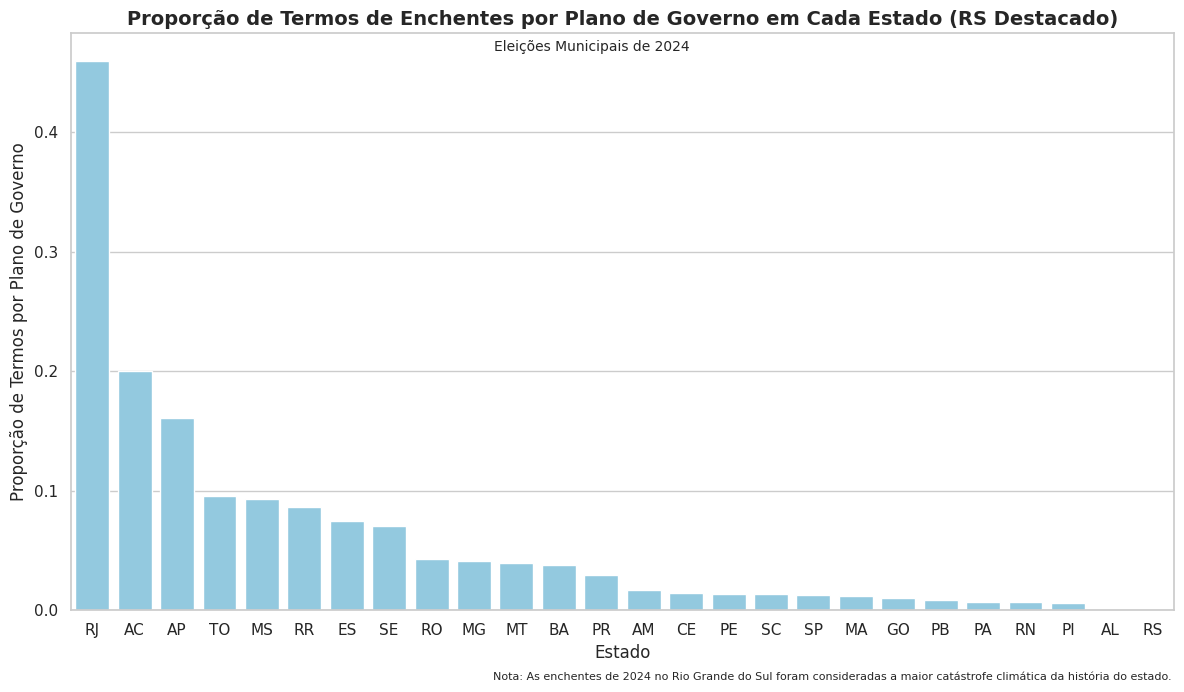

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de estilo com seaborn
sns.set(style="whitegrid")

# Criar DataFrame com as informações combinadas de ocorrências e PDFs
# Supondo que `ocorrencias_termos` e `pdf_counts` já existam como dicionários com valores reais
ocorrencias_df = pd.DataFrame(list(ocorrencias_termos.items()), columns=['estado', 'total_ocorrencias'])
pdf_counts_df = pd.DataFrame(list(pdf_counts.items()), columns=['estado', 'pdfs_totais'])

# Combinar as informações automaticamente usando 'estado' como chave
ocorrencias_df = ocorrencias_df.merge(pdf_counts_df, on='estado')

# Calcular a proporção de termos por PDF
ocorrencias_df['proporcao_termos_por_pdf'] = ocorrencias_df['total_ocorrencias'] / ocorrencias_df['pdfs_totais']

# Ordenar o DataFrame em ordem decrescente de proporção
ocorrencias_df = ocorrencias_df.sort_values(by='proporcao_termos_por_pdf', ascending=False)

# Configurar cores, destacando o RS em uma cor diferente
colors = ['orange' if estado == 'RS' else 'skyblue' for estado in ocorrencias_df['estado']]

# Configurar figura e eixos
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='estado', y='proporcao_termos_por_pdf', data=ocorrencias_df, palette=colors)

# Título e subtítulo
plt.title('Proporção de Termos de Enchentes por Plano de Governo em Cada Estado (RS Destacado)', fontsize=14, weight='bold')
plt.suptitle('Eleições Municipais de 2024', y=0.85, fontsize=10)
plt.xlabel('Estado')
plt.ylabel('Proporção de Termos por Plano de Governo')

# Nota de rodapé posicionada mais próxima ao gráfico
plt.figtext(0.7, 0.05, 'Nota: As enchentes de 2024 no Rio Grande do Sul foram consideradas a maior catástrofe climática da história do estado.', ha='center', fontsize=8)

# Ajuste do layout
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Reduz espaço em branco

# Exibir gráfico
plt.show()

## **Estudo de Caso RS**

In [ ]:
# Carregar o DataFrame
df = pd.read_csv("textos2020.csv")

# Filtrar apenas os dados do estado do RS
df_rs_texto = df[df['estado'] == 'RS'][['texto_corrigido']]

# Salvar o DataFrame filtrado em um arquivo CSV
df_rs_texto.to_csv("dados_rs.csv", index=False)

print("Arquivo 'dados_rs.csv' criado com sucesso.")

Arquivo 'dados_rs.csv' criado com sucesso.


In [ ]:
# Carregar o DataFrame
df_2020 = pd.read_csv("textos2020.csv")

# Calcular a quantidade total de palavras na coluna 'texto_corrigido'
total_palavras_2020 = df_2020['texto_corrigido'].str.split().str.len().sum()

print(f"Quantidade total de palavras na coluna 'texto_corrigido': {total_palavras_2020}")

Quantidade total de palavras na coluna 'texto_corrigido': 34580301


In [ ]:
# Carregar o DataFrame
df_2020 = pd.read_csv("textos2020.csv")

# Calcular a quantidade total de palavras na coluna 'texto_corrigido' por estado
total_palavras_por_estado_2020 = df_2020.groupby('estado')['texto_corrigido'].apply(lambda x: x.str.split().str.len().sum())

print(total_palavras_por_estado_2020)

estado
AC     295799
AL      25433
AM      90757
AP     372003
BA    1079812
CE     388086
ES     305080
GO     116508
MA     264566
MG    1618542
MS     590959
MT     244569
PA     182815
PB     254138
PE     201322
PI     116289
PR     789156
RJ    3087110
RN     156258
RO     200267
RR     135437
RS       4059
SC     133990
SE     473081
SP     622664
TO    1076302
Name: texto_corrigido, dtype: int64


In [ ]:
# Carregar o DataFrame
df_2024 = pd.read_csv("texto_corrigido_utf8.csv")

# Calcular a quantidade total de palavras na coluna 'texto_corrigido'
total_palavras_2024 = df_2024['texto_corrigido'].str.split().str.len().sum()

print(f"Quantidade total de palavras na coluna 'texto_corrigido': {total_palavras_2024}")

Quantidade total de palavras na coluna 'texto_corrigido': 34580301


In [ ]:
# Carregar o DataFrame
df_2024 = pd.read_csv("texto_corrigido_utf8.csv")

# Calcular a quantidade total de palavras na coluna 'texto_corrigido' por estado
total_palavras_por_estado_2024 = df_2024.groupby('estado')['texto_corrigido'].apply(lambda x: x.str.split().str.len().sum())

print(total_palavras_por_estado_2024)

estado
AC     151586
AL     499536
AM     493270
AP     142222
BA    3407804
CE    1221610
ES     747593
GO    1233776
MA    1300368
MG    5057148
MS     590334
MT     812629
PA    1190110
PB    1013748
PE    1143816
PI     997158
PR    2353511
RJ    1263212
RN     887725
RO     350656
RR      73589
RS    1916308
SC    1400372
SE     518880
SP    5248724
TO     564616
Name: texto_corrigido, dtype: int64


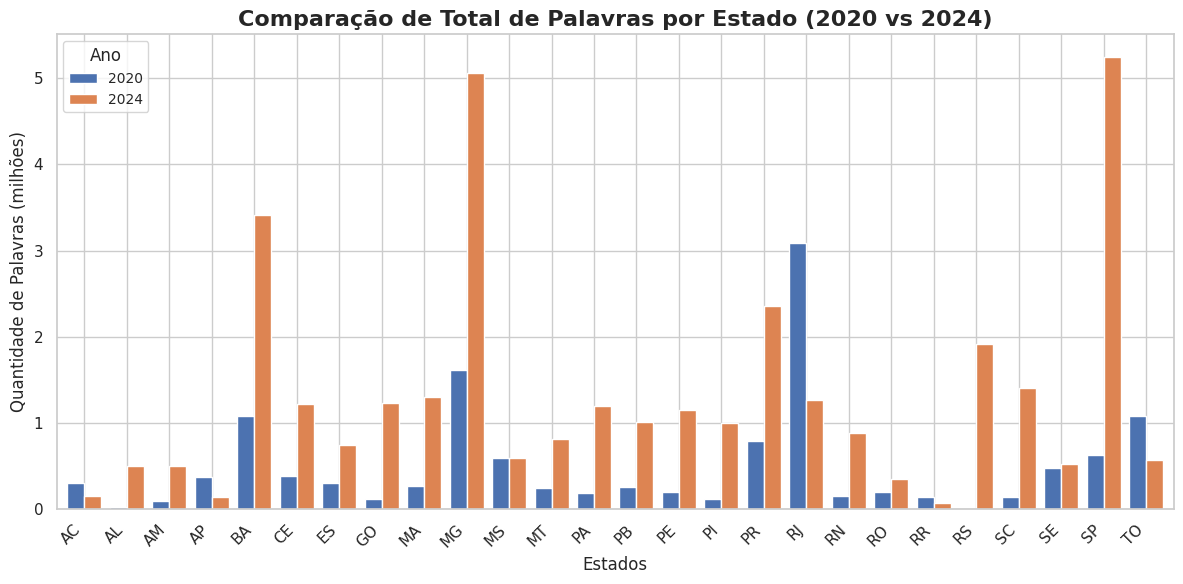

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Supondo que total_palavras_por_estado_2020 e total_palavras_por_estado_2024 são Series ou arrays do NumPy
total_palavras_por_estado_2020 = pd.Series(total_palavras_por_estado_2020, name="2020")
total_palavras_por_estado_2024 = pd.Series(total_palavras_por_estado_2024, name="2024")

# Combinar as duas Series em um único DataFrame
df_comparativo = pd.concat([total_palavras_por_estado_2020, total_palavras_por_estado_2024], axis=1)

# Ajustar a escala para milhões (dividindo por 1.000.000)
df_comparativo_scaled = df_comparativo / 1_000_000

# Criar o gráfico
df_comparativo_scaled.plot(kind='bar', figsize=(12, 6), width=0.8)

# Configurações do gráfico
plt.title("Comparação de Total de Palavras por Estado (2020 vs 2024)", fontsize=16, weight='bold')
plt.xlabel("Estados", fontsize=12)
plt.ylabel("Quantidade de Palavras (milhões)", fontsize=12)  # Atualizar o rótulo do eixo Y
plt.xticks(rotation=45, ha='right')
plt.legend(title="Ano", fontsize=10)
plt.tight_layout()

# Exibir o gráfico
plt.show()